# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


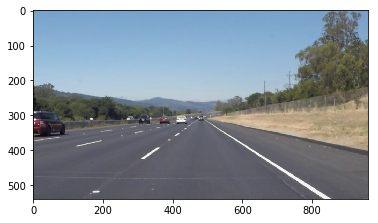

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images  
`cv2.cvtColor()` to grayscale or change color  
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
from IPython.core.debugger import set_trace

In [4]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [5]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

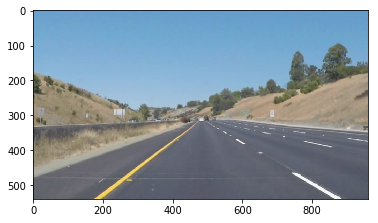

In [6]:
image = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')
plt.imshow(image)

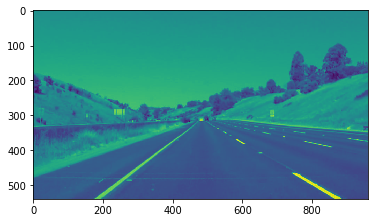

In [7]:
gray = grayscale(image)
plt.imshow(gray)

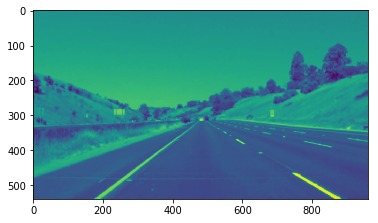

In [8]:
kernal_size = 5
blur_gray = gaussian_blur(gray, kernal_size)
plt.imshow(blur_gray)

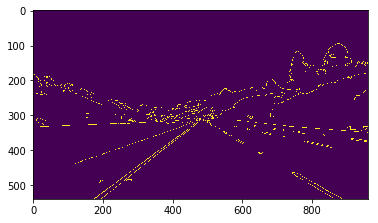

In [9]:
# canny.  Play with parameters to get the best edges
low_threshold = 50
high_threshold = 150
edges = canny(blur_gray, low_threshold, high_threshold)
plt.imshow(edges)

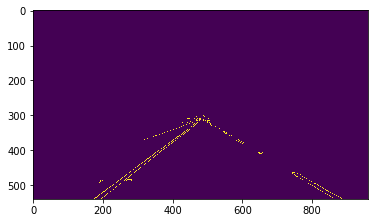

In [10]:
image_shape = image.shape
vertices = np.array([[(0,image_shape[0]),(450, 300), (490, 300), (image_shape[1],image_shape[0])]], dtype=np.int32)
masked_image = region_of_interest(edges, vertices)
plt.imshow(masked_image)

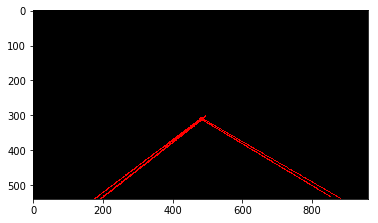

In [11]:
# define the hough transform parameters
rho = 2 # distance resolution in pixels of the hogh grid
theta = np.pi/180 # angular resolution in radians of the hough grid
threshold = 150 #minimum number of votes ( intersections in hough grid cell)
min_line_len = 30 #minimum number of pixels making up a line
max_line_gap = 100 # maximum gap in pixels between connectable lines

line_img = hough_lines(masked_image, rho, theta, threshold, min_line_len, max_line_gap)


plt.imshow(line_img)

In [12]:
line_img.shape

(540, 960, 3)

In [13]:
def slope(line):
    for x1,y1,x2,y2 in line:
        return ((y2-y1)/(x2-x1))

In [14]:
# # plot the lines
# for line in left_lines:
#     for x1, y1, x2, y2 in line:
#         plt.plot((x1, x2), (y1, y2), 'g')

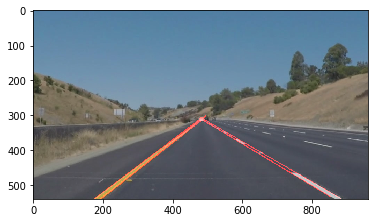

In [15]:
final_image = cv2.addWeighted(image, 0.8, line_img, 1., 0.)
plt.imshow(final_image)

In [16]:
!touch test_images_output

In [17]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.
!ls
# whiteCarLaneSwitch.jpg
mpimg.imsave("test_images_output/whiteCarLaneSwitch.jpg", final_image)

examples  P1.ipynb   set_git.sh   test_images_output  test_videos_output
LICENSE   README.md  test_images  test_videos	      writeup_template.md


In [18]:
!ls test_images_output/

solidWhiteCurve.jpg  solidYellowCurve2.jpg  solidYellowLeft.jpg
solidWhiteRight.jpg  solidYellowCurve.jpg   whiteCarLaneSwitch.jpg


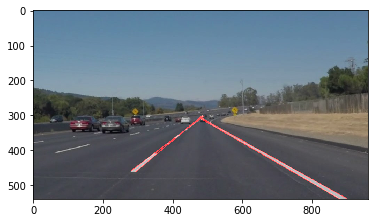

In [19]:
# image_2
kernal_size = 5
low_threshold = 50
high_threshold = 150
rho = 2 # distance resolution in pixels of the hogh grid
theta = np.pi/180 # angular resolution in radians of the hough grid
threshold = 120 #minimum number of votes ( intersections in hough grid cell)
min_line_len = 10 #minimum number of pixels making up a line
max_line_gap = 50 # maximum gap in pixels between connectable lines
vertices = np.array([[(0,image_shape[0]),(450, 300), (490, 300), (image_shape[1],image_shape[0])]], dtype=np.int32)

image = mpimg.imread('test_images/solidWhiteCurve.jpg')
gray = grayscale(image)
blur_gray = gaussian_blur(gray, kernal_size)
edges = canny(blur_gray, low_threshold, high_threshold)
masked_image = region_of_interest(edges, vertices)


line_img = hough_lines(masked_image, rho, theta, threshold, min_line_len, max_line_gap)
final_image = cv2.addWeighted(image, 0.8, line_img, 1., 0.)
mpimg.imsave("test_images_output/solidWhiteCurve.jpg", final_image)
plt.imshow(final_image)

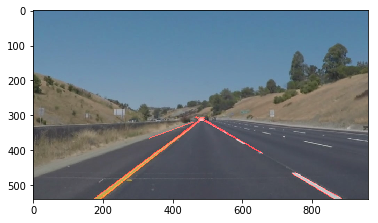

In [20]:
# image_3

image = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')
gray = grayscale(image)
blur_gray = gaussian_blur(gray, kernal_size)
edges = canny(blur_gray, low_threshold, high_threshold)
masked_image = region_of_interest(edges, vertices)


line_img = hough_lines(masked_image, rho, theta, threshold, min_line_len, max_line_gap)
final_image = cv2.addWeighted(image, 0.8, line_img, 1., 0.)
mpimg.imsave("test_images_output/whiteCarLaneSwitch.jpg", final_image)
plt.imshow(final_image)

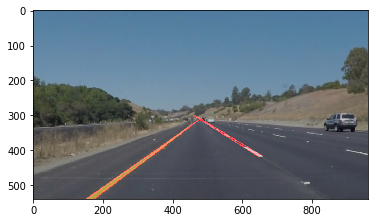

In [21]:
# image_4 solidYellowCurve
image = mpimg.imread('test_images/solidYellowCurve.jpg')
gray = grayscale(image)
blur_gray = gaussian_blur(gray, kernal_size)
edges = canny(blur_gray, low_threshold, high_threshold)
masked_image = region_of_interest(edges, vertices)


line_img = hough_lines(masked_image, rho, theta, threshold, min_line_len, max_line_gap)
final_image = cv2.addWeighted(image, 0.8, line_img, 1., 0.)
mpimg.imsave("test_images_output/solidYellowCurve.jpg", final_image)
plt.imshow(final_image)



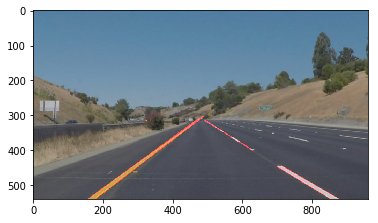

In [22]:
# image_5 solidYellowCurve2
image = mpimg.imread('test_images/solidYellowCurve2.jpg')
gray = grayscale(image)
blur_gray = gaussian_blur(gray, kernal_size)
edges = canny(blur_gray, low_threshold, high_threshold)
masked_image = region_of_interest(edges, vertices)


line_img = hough_lines(masked_image, rho, theta, threshold, min_line_len, max_line_gap)
final_image = cv2.addWeighted(image, 0.8, line_img, 1., 0.)
mpimg.imsave("test_images_output/solidYellowCurve2.jpg", final_image)
plt.imshow(final_image)

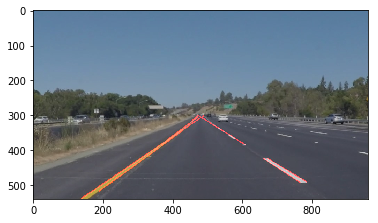

In [23]:
# image_6 solidYellowLeft
image = mpimg.imread('test_images/solidYellowLeft.jpg')
gray = grayscale(image)
blur_gray = gaussian_blur(gray, kernal_size)
edges = canny(blur_gray, low_threshold, high_threshold)
masked_image = region_of_interest(edges, vertices)


line_img = hough_lines(masked_image, rho, theta, threshold, min_line_len, max_line_gap)
final_image = cv2.addWeighted(image, 0.8, line_img, 1., 0.)
mpimg.imsave("test_images_output/solidYellowLeft.jpg", final_image)
plt.imshow(final_image)

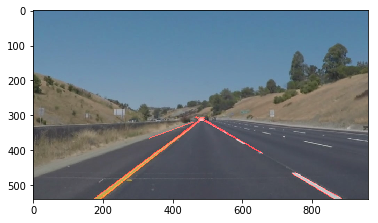

In [24]:
# image_7 whiteCarLaneSwitch
image = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')
gray = grayscale(image)
blur_gray = gaussian_blur(gray, kernal_size)
edges = canny(blur_gray, low_threshold, high_threshold)
masked_image = region_of_interest(edges, vertices)


line_img = hough_lines(masked_image, rho, theta, threshold, min_line_len, max_line_gap)
final_image = cv2.addWeighted(image, 0.8, line_img, 1., 0.)
mpimg.imsave("test_images_output/whiteCarLaneSwitch.jpg", final_image)
plt.imshow(final_image)

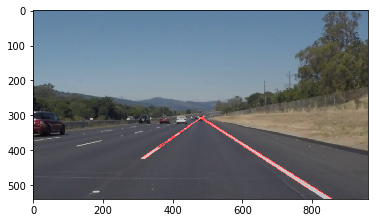

In [25]:
# image_7 solidWhiteRight.jpg
image = mpimg.imread('test_images/solidWhiteRight.jpg')
gray = grayscale(image)
blur_gray = gaussian_blur(gray, kernal_size)
edges = canny(blur_gray, low_threshold, high_threshold)
masked_image = region_of_interest(edges, vertices)


line_img = hough_lines(masked_image, rho, theta, threshold, min_line_len, max_line_gap)
final_image = cv2.addWeighted(image, 0.8, line_img, 1., 0.)
mpimg.imsave("test_images_output/solidWhiteRight.jpg", final_image)
plt.imshow(final_image)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [26]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [43]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    # image_2
    kernal_size = 5
    low_threshold = 50
    high_threshold = 150
    rho = 2 # distance resolution in pixels of the hogh grid
    theta = np.pi/180 # angular resolution in radians of the hough grid
    threshold = 120 #minimum number of votes ( intersections in hough grid cell)
    min_line_len = 10 #minimum number of pixels making up a line
    max_line_gap = 50 # maximum gap in pixels between connectable lines
    vertices = np.array([[(0,image_shape[0]),(450, 300), (490, 300), (image_shape[1],image_shape[0])]], dtype=np.int32)

#     image = mpimg.imread('test_images/solidWhiteCurve.jpg')
    gray = grayscale(image)
    blur_gray = gaussian_blur(gray, kernal_size)
    edges = canny(blur_gray, low_threshold, high_threshold)
    masked_image = region_of_interest(edges, vertices)


    line_img = hough_lines(masked_image, rho, theta, threshold, min_line_len, max_line_gap)
    final_image = cv2.addWeighted(image, 0.8, line_img, 1., 0.)
#     mpimg.imsave("test_images_output/solidWhiteCurve.jpg", final_image)
#     plt.imshow(final_image)
    return final_image

Let's try the one with the solid white lane on the right first ...

In [98]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[[202 514 310 433]]
[[192 508 303 430]]
[[187 512 304 430]]
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


  2%|▏         | 4/222 [00:00<00:05, 38.48it/s]

[[202 514 310 433]]
[[192 508 303 430]]
[[187 512 304 430]]
[[170 538 289 448]]
[[166 526 280 446]]
[[165 527 256 463]]
[[343 407 485 300]]
[[150 538 251 467]]
[[171 539 261 469]]
[[330 417 484 301]]
[[148 538 211 494]]
[[169 538 225 496]]
[[361 387 480 301]]
[[311 429 488 301]]
[[356 395 488 300]]
[[339 402 485 300]]
[[345 403 488 300]]
[[334 412 489 300]]
[[326 411 484 300]]
[[310 422 484 300]]
[[319 424 361 393]]
[[316 425 488 300]]


  6%|▋         | 14/222 [00:00<00:05, 40.45it/s]

[[289 438 489 303]]
[[297 441 483 301]]
[[263 458 483 304]]
[[326 421 487 304]]
[[240 485 489 305]]
[[232 480 476 309]]
[[321 421 490 307]]
[[357 392 476 308]]
[[195 516 307 434]]
[[265 455 298 433]]
[[183 513 294 436]]
[[364 393 488 303]]
[[145 539 277 446]]
[[164 539 285 448]]
[[144 538 275 447]]
[[163 538 285 449]]
[[142 538 247 465]]
[[162 539 258 466]]
[[157 538 221 492]]
[[445 324 475 302]]
[[138 538 207 490]]


 11%|█         | 24/222 [00:00<00:04, 42.66it/s]

[[326 410 391 365]]
[[334 412 478 308]]
[[310 423 490 302]]
[[301 439 490 302]]
[[289 437 487 303]]
[[474 314 491 302]]
[[268 451 487 303]]
[[274 457 476 311]]
[[231 476 489 302]]
[[248 477 473 308]]
[[186 507 300 430]]
[[216 500 290 445]]
[[200 510 308 432]]
[[186 509 299 430]]
[[349 397 491 301]]
[[349 396 478 306]]
[[215 501 289 446]]
[[350 395 489 301]]
[[146 536 277 445]]
[[142 539 247 466]]
[[164 538 261 467]]
[[152 533 250 465]]
[[182 526 240 483]]
[[328 416 473 307]]
[[164 538 225 494]]
[[142 539 214 491]]


 18%|█▊        | 39/222 [00:00<00:04, 42.39it/s]

[[348 402 489 300]]
[[341 400 475 307]]
[[328 409 484 300]]
[[335 412 489 300]]
[[330 407 488 300]]
[[319 423 486 302]]
[[292 436 475 308]]
[[300 437 489 300]]
[[267 452 491 301]]
[[247 478 412 358]]
[[419 346 474 308]]
[[235 476 493 302]]
[[270 451 490 302]]
[[205 509 311 432]]
[[191 508 303 430]]
[[192 506 301 430]]
[[356 398 488 302]]
[[352 398 481 301]]
[[350 398 488 301]]
[[146 538 278 446]]
[[167 537 291 447]]
[[147 539 281 445]]
[[338 404 481 304]]
[[166 539 264 465]]
[[145 539 252 464]]
[[323 413 477 305]]
[[143 538 216 489]]
[[332 415 397 368]]
[[164 538 228 492]]
[[353 391 489 300]]
[[343 398 489 300]]


 20%|█▉        | 44/222 [00:01<00:06, 28.65it/s]

[[329 407 476 304]]
[[313 418 487 300]]
[[320 413 487 300]]
[[303 434 476 304]]


 22%|██▏       | 48/222 [00:01<00:07, 21.80it/s]

[[270 449 476 304]]
[[278 451 342 405]]
[[240 469 474 305]]
[[251 472 471 306]]
[[357 388 477 304]]
[[213 501 470 308]]
[[198 499 304 425]]
[[225 479 305 425]]
[[140 538 282 439]]
[[161 539 283 447]]
[[249 474 292 442]]
[[184 522 292 441]]


 23%|██▎       | 51/222 [00:01<00:08, 19.37it/s]

[[336 401 465 310]]
[[139 538 258 458]]
[[337 403 489 301]]
[[163 535 266 460]]
[[341 399 488 300]]
[[338 400 469 309]]
[[322 412 488 300]]
[[137 538 217 482]]
[[423 345 486 300]]
[[451 326 487 300]]
[[158 538 232 483]]
[[306 423 488 300]]
[[313 423 482 300]]


 26%|██▌       | 57/222 [00:02<00:09, 16.52it/s]

[[342 401 467 310]]
[[218 481 228 475]]
[[325 408 485 300]]
[[330 411 487 301]]
[[307 421 478 306]]
[[312 423 485 302]]
[[285 435 488 303]]
[[296 437 472 309]]


 27%|██▋       | 61/222 [00:02<00:10, 15.85it/s]

[[260 452 474 308]]
[[334 407 486 301]]
[[226 474 473 308]]
[[237 476 488 301]]
[[181 505 294 429]]
[[356 390 470 308]]
[[358 390 469 309]]
[[197 507 303 430]]


 28%|██▊       | 63/222 [00:02<00:10, 15.07it/s]

[[131 538 269 445]]
[[344 396 487 300]]
[[151 538 281 447]]
[[132 538 270 445]]
[[132 538 240 465]]
[[151 538 251 468]]
[[132 539 243 464]]
[[152 537 252 467]]
[[131 538 201 491]]
[[317 414 477 306]]
[[150 538 215 493]]
[[356 386 481 302]]
[[149 539 163 529]]
[[374 381 489 301]]


 30%|███       | 67/222 [00:02<00:10, 15.24it/s]

[[347 393 483 301]]
[[335 398 487 300]]
[[341 400 489 300]]
[[323 408 473 307]]
[[327 409 489 300]]
[[306 418 473 306]]
[[316 419 485 301]]


 32%|███▏      | 71/222 [00:03<00:09, 15.33it/s]

[[298 432 485 301]]
[[286 433 484 304]]
[[271 449 477 305]]
[[261 447 487 301]]
[[270 451 485 301]]
[[362 380 478 304]]
[[316 413 489 301]]
[[240 470 370 382]]
[[353 388 488 301]]
[[199 499 304 426]]
[[187 496 297 425]]


 34%|███▍      | 75/222 [00:03<00:10, 14.07it/s]

[[144 538 283 440]]
[[127 536 274 440]]
[[146 537 283 441]]
[[331 403 488 301]]
[[123 538 245 459]]
[[335 404 474 306]]
[[339 403 485 301]]
[[143 538 256 459]]
[[320 412 480 300]]
[[321 412 481 300]]
[[140 538 220 484]]
[[121 538 207 482]]


 36%|███▌      | 79/222 [00:03<00:09, 14.76it/s]

[[119 539 159 513]]
[[333 398 490 300]]


 36%|███▋      | 81/222 [00:03<00:09, 14.81it/s]

[[319 408 488 302]]
[[302 417 489 300]]
[[311 419 481 300]]
[[283 430 484 304]]
[[298 429 475 305]]
[[257 446 490 300]]
[[271 447 482 300]]


 38%|███▊      | 85/222 [00:04<00:09, 14.96it/s]

[[227 466 474 306]]
[[239 468 487 301]]
[[197 497 301 427]]
[[183 494 295 424]]
[[194 498 302 426]]
[[137 537 281 440]]
[[341 393 482 301]]
[[341 394 491 301]]
[[341 395 487 304]]
[[132 527 274 438]]
[[136 538 254 459]]
[[329 401 479 304]]
[[116 538 247 457]]
[[120 535 245 457]]


 40%|████      | 89/222 [00:04<00:08, 15.04it/s]

[[314 411 478 305]]
[[474 315 489 306]]
[[132 528 207 481]]
[[137 538 219 483]]
[[118 538 209 481]]
[[355 385 484 301]]
[[306 424 487 302]]
[[344 391 484 300]]
[[334 400 492 301]]


 42%|████▏     | 93/222 [00:04<00:08, 15.59it/s]

[[320 408 491 301]]
[[329 410 481 308]]
[[316 419 489 302]]
[[305 419 477 308]]
[[294 433 488 302]]
[[286 431 481 305]]
[[273 448 479 304]]
[[289 428 490 302]]


 44%|████▎     | 97/222 [00:04<00:08, 15.61it/s]

[[231 466 486 300]]
[[242 468 490 301]]
[[190 493 298 423]]
[[203 495 298 429]]
[[132 529 274 437]]
[[346 394 470 307]]
[[351 394 490 300]]
[[203 495 285 438]]
[[132 530 276 437]]


 45%|████▌     | 101/222 [00:05<00:07, 15.18it/s]

[[136 538 259 455]]
[[333 399 480 303]]
[[336 401 398 363]]
[[117 538 247 454]]
[[137 537 224 478]]
[[407 350 481 302]]
[[322 409 393 365]]
[[117 537 215 476]]
[[327 409 488 301]]
[[312 420 490 300]]


 46%|████▋     | 103/222 [00:05<00:08, 14.08it/s]

[[339 398 492 303]]
[[326 410 481 305]]
[[311 418 490 302]]


 48%|████▊     | 107/222 [00:05<00:07, 14.52it/s]

[[292 430 490 301]]
[[308 428 473 308]]
[[268 445 490 301]]
[[288 442 476 306]]
[[238 465 491 301]]
[[249 468 480 306]]
[[197 495 302 424]]
[[212 495 312 425]]
[[364 388 484 304]]


 50%|█████     | 111/222 [00:05<00:07, 14.68it/s]

[[432 342 489 302]]
[[142 532 280 439]]
[[158 533 290 441]]
[[354 395 477 306]]
[[142 530 284 438]]
[[339 403 492 304]]
[[344 403 483 305]]
[[152 539 267 458]]
[[131 538 257 456]]
[[153 538 234 481]]
[[133 539 221 480]]
[[325 412 492 304]]


 53%|█████▎    | 117/222 [00:06<00:06, 15.06it/s]

[[343 396 489 301]]
[[347 398 491 301]]
[[329 404 483 304]]
[[335 406 491 301]]
[[185 506 197 498]]
[[322 416 491 302]]
[[314 414 479 307]]


 54%|█████▎    | 119/222 [00:06<00:06, 15.33it/s]

[[296 426 489 301]]
[[282 444 480 305]]
[[306 419 492 302]]
[[250 465 490 303]]
[[246 460 483 306]]
[[256 464 330 412]]
[[216 492 482 306]]

 55%|█████▌    | 123/222 [00:06<00:06, 15.08it/s]


[[205 489 304 422]]
[[229 473 309 421]]
[[165 528 294 438]]
[[184 503 288 435]]
[[225 475 286 435]]
[[166 528 295 438]]
[[210 485 287 435]]
[[341 401 491 304]]
[[132 538 258 453]]
[[345 402 482 306]]
[[346 402 402 363]]
[[232 482 270 455]]
[[177 521 270 454]]
[[130 538 228 474]]
[[333 411 479 309]]
[[150 538 238 477]]


 57%|█████▋    | 127/222 [00:06<00:06, 15.16it/s]

[[314 418 492 303]]
[[131 538 185 503]]
[[150 538 196 505]]
[[346 397 489 304]]
[[334 406 480 308]]
[[341 408 489 304]]


 59%|█████▉    | 131/222 [00:07<00:06, 14.98it/s]

[[319 416 484 305]]
[[328 418 492 303]]
[[310 431 483 306]]
[[302 429 493 305]]
[[280 446 490 304]]
[[289 447 484 306]]
[[252 466 492 304]]
[[280 456 474 310]]


 60%|█████▉    | 133/222 [00:07<00:06, 14.31it/s]

[[364 388 477 309]]
[[215 490 492 304]]
[[230 492 408 358]]
[[181 527 303 438]]
[[355 395 492 302]]
[[390 370 481 306]]
[[355 393 477 308]]
[[163 525 295 436]]
[[164 525 296 436]]
[[143 538 272 451]]
[[352 401 490 301]]
[[204 509 279 453]]
[[143 539 268 452]]
[[183 524 279 452]]


 62%|██████▏   | 137/222 [00:07<00:06, 14.13it/s]

[[338 409 484 303]]
[[341 408 480 307]]
[[161 539 249 473]]
[[331 407 477 305]]
[[141 538 239 472]]
[[324 419 484 303]]
[[160 538 208 503]]
[[317 419 490 302]]


 64%|██████▎   | 141/222 [00:07<00:05, 14.20it/s]

[[344 407 484 305]]
[[339 404 467 314]]
[[324 415 490 303]]
[[315 430 486 306]]
[[307 430 481 308]]


 65%|██████▌   | 145/222 [00:08<00:05, 13.69it/s]

[[286 444 483 306]]
[[295 446 492 303]]
[[268 465 490 304]]
[[259 464 485 306]]
[[274 463 339 414]]
[[259 463 486 304]]
[[296 445 467 316]]
[[224 489 485 306]]
[[238 489 477 309]]


 66%|██████▌   | 147/222 [00:08<00:05, 14.07it/s]

[[193 523 306 438]]
[[175 523 301 435]]
[[175 522 299 435]]
[[362 395 477 308]]
[[250 479 304 439]]
[[350 399 486 304]]
[[349 401 491 302]]
[[170 538 284 453]]
[[152 539 272 452]]
[[152 538 246 472]]
[[170 538 255 474]]
[[171 538 255 475]]
[[325 421 477 307]]
[[322 419 487 304]]
[[152 538 204 502]]

 68%|██████▊   | 151/222 [00:08<00:04, 14.50it/s]


[[349 408 484 306]]

 69%|██████▉   | 153/222 [00:08<00:04, 14.73it/s]


[[328 416 490 303]]
[[333 418 492 303]]
[[311 427 487 304]]
[[317 429 493 302]]
[[293 439 490 301]]

 71%|███████   | 157/222 [00:08<00:04, 14.71it/s]


[[272 463 484 304]]
[[262 461 490 302]]
[[267 457 319 420]]
[[240 489 483 306]]
[[227 486 491 301]]
[[195 524 310 437]]
[[178 523 300 434]]
[[258 476 311 435]]


 73%|███████▎  | 161/222 [00:09<00:04, 14.26it/s]

[[360 399 491 301]]
[[176 539 289 451]]
[[156 539 278 450]]
[[179 537 261 475]]
[[166 532 250 473]]
[[327 418 479 308]]
[[160 537 207 504]]
[[179 538 222 506]]


 74%|███████▍  | 165/222 [00:09<00:04, 14.14it/s]

[[360 397 477 309]]
[[350 405 477 309]]
[[356 406 480 310]]
[[336 415 484 304]]
[[344 416 491 302]]


 75%|███████▌  | 167/222 [00:09<00:03, 14.43it/s]

[[321 427 492 303]]
[[362 405 481 309]]
[[275 461 483 309]]
[[287 463 483 310]]
[[242 487 477 310]]
[[254 488 491 303]]


 77%|███████▋  | 171/222 [00:09<00:03, 14.92it/s]

[[212 523 482 304]]
[[196 521 316 434]]
[[196 522 312 435]]
[[209 524 321 437]]
[[175 539 291 452]]
[[206 529 300 453]]
[[176 538 290 452]]
[[193 539 300 452]]
[[359 399 485 304]]
[[346 409 477 310]]
[[176 538 261 474]]
[[350 410 471 312]]
[[194 539 273 475]]


 79%|███████▉  | 175/222 [00:10<00:03, 15.17it/s]

[[194 538 237 504]]
[[337 420 404 371]]
[[175 538 221 503]]


 81%|████████  | 179/222 [00:10<00:02, 14.77it/s]

[[340 414 486 304]]
[[325 426 477 312]]
[[307 441 490 303]]


 82%|████████▏ | 181/222 [00:10<00:02, 14.91it/s]

[[283 459 461 320]]
[[296 460 470 314]]
[[251 484 474 310]]
[[265 485 467 316]]
[[371 392 478 308]]
[[207 519 318 433]]
[[225 519 474 310]]
[[181 539 296 449]]

 83%|████████▎ | 185/222 [00:10<00:02, 14.92it/s]


[[200 539 304 452]]
[[181 538 294 450]]
[[181 538 267 471]]
[[358 408 475 310]]
[[200 538 279 474]]
[[338 418 491 303]]
[[180 539 233 498]]


 86%|████████▌ | 191/222 [00:11<00:02, 14.67it/s]

[[340 410 486 300]]
[[333 422 457 318]]
[[324 419 480 306]]
[[306 436 481 304]]


 87%|████████▋ | 193/222 [00:11<00:01, 14.78it/s]

[[282 456 482 306]]
[[293 458 456 322]]
[[250 483 489 303]]
[[265 485 480 305]]
[[205 517 316 434]]
[[236 509 480 305]]
[[402 372 484 310]]
[[361 399 478 311]]
[[361 398 475 312]]

 89%|████████▊ | 197/222 [00:11<00:01, 14.75it/s]


[[368 400 458 327]]
[[178 539 283 457]]
[[362 400 405 364]]
[[198 539 304 450]]
[[178 538 265 472]]
[[350 412 475 307]]
[[203 534 277 474]]
[[348 411 489 305]]
[[199 538 277 475]]
[[344 419 488 303]]
[[198 539 241 503]]
[[459 328 489 306]]


 91%|█████████▏| 203/222 [00:12<00:01, 15.05it/s]

[[349 415 473 311]]
[[324 424 488 301]]
[[335 426 483 302]]
[[318 429 481 310]]
[[342 421 481 305]]
[[291 461 392 379]]
[[281 459 480 303]]


 93%|█████████▎| 207/222 [00:12<00:01, 14.91it/s]

[[249 483 479 303]]
[[460 325 481 308]]
[[268 481 476 307]]
[[220 519 327 433]]
[[204 517 285 454]]
[[210 513 316 431]]
[[196 539 307 449]]
[[175 538 298 446]]
[[176 537 295 447]]
[[197 539 280 469]]
[[176 539 270 468]]
[[208 530 276 473]]
[[351 405 485 304]]


 95%|█████████▌| 211/222 [00:12<00:00, 15.13it/s]

[[344 416 482 301]]
[[177 538 227 499]]


 97%|█████████▋| 215/222 [00:12<00:00, 15.22it/s]

[[334 427 484 301]]
[[314 442 486 303]]
[[295 461 486 301]]
[[308 438 486 308]]
[[259 488 487 303]]
[[260 475 488 303]]


 99%|█████████▊| 219/222 [00:13<00:00, 14.77it/s]

[[203 519 312 434]]
[[216 522 323 436]]
[[238 492 316 433]]
[[224 516 303 452]]
[[178 539 294 449]]
[[180 537 291 450]]
[[358 399 487 302]]
[[175 538 264 471]]
[[356 408 470 316]]
[[196 539 275 473]]


100%|█████████▉| 221/222 [00:13<00:00, 14.96it/s]


[[176 537 225 500]]
[[342 419 486 302]]
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 2.97 s, sys: 269 ms, total: 3.24 s
Wall time: 14.9 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [99]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

[[194 538 490 307]]
[[176 538 364 397]]
[[246 487 486 307]]
[[195 539 255 491]]
[[332 366 459 320]]
[[310 438 473 319]]


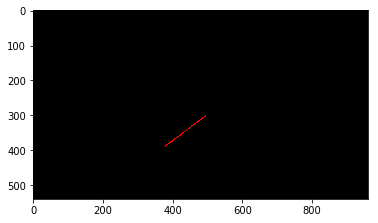

In [46]:
# break down hough_lines and draw lines functions
img = masked_image
lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)


# draw_lines(line_img, lines)
color=[255, 0, 0]
thickness=2
left_lines = []
right_lines = []
left_slopes = []
right_slopes = []
for line in lines:
    for x1,y1,x2,y2 in line:
        if slope(line) > 0:
            right_lines.append(line)
            right_slopes.append(slope(line))
        else:
            left_lines.append(line)
            left_slopes.append(slope(line))
#         cv2.line(line_img, (x1, y1), (x2, y2), color, thickness)
        
for line in left_lines:
    for x1,y1,x2,y2 in line:
        print(line)
#         cv2.line(line_img, (x1, y1), (x2, y2), color, thickness)
        cv2.line(line_img, (378, 389), (494, 302), color, thickness)
lines
plt.imshow(line_img)
# one of these lines shouldn't be there.  I could exlude it by slope or i could play around with thresholding or both.  
# I am seeign valid slopes here of -0.73 - -0.8 and 0.55 - 0.6 .  A bit surpised they don't match more
# average the slopes
# average the starting points
# re-draw the lines 
# i have points so i could do a linear regression 


In [47]:
right_lines

[array([[743, 467, 863, 539]], dtype=int32),
 array([[464, 306, 482, 316]], dtype=int32),
 array([[752, 465, 884, 538]], dtype=int32),
 array([[481, 307, 657, 409]], dtype=int32),
 array([[468, 304, 651, 406]], dtype=int32)]

In [48]:
# extend a line with point slope formula
# (x1, y1), (x2, y2)
# m(x1 - x2) + y2 = y1
# y1 = m(x1 - x2) + y2 
# for left lines, i need to solve for x1.  for right lines x2
# testing that the calculation for x2 is correct
first_line = right_lines[0]
print(first_line)
for x1,y1,x2,y2 in first_line:
#     y1_result = slope(first_line) * (x1 - x2) + y2 
    x2_result = (y1 - y2) / slope(first_line) - x1
    x2_result = abs(x2_result)
# i am looking for x2 result.  can i just look for y result since that isn't multiplied ? 
print(x2_result)
x2


[[743 467 863 539]]
863.0


863

In [49]:
# calculating x2 with changing the y2 value to 540 (bottom of image)
first_line = right_lines[0]
print(first_line)
for x1,y1,x2,y2 in first_line:
    x2_result = (y1 - 540) / slope(first_line) - x1
    x2_result = abs(x2_result)
print(x2_result)
x2


[[743 467 863 539]]
864.666666667


863

In [50]:
# verifying that calculating for x1 works
first_line = left_lines[0]
print(first_line)
for x1,y1,x2,y2 in first_line:
    x1_result = (y1 - y2) / slope(first_line) + x2
print(x1_result)
x1


[[194 538 490 307]]
194.0


194

In [51]:
# calculating x1 with changing the y1 value to 540 (bottom of image)
first_line = left_lines[0]
print(first_line)
for x1,y1,x2,y2 in first_line:
    x1_result = (540 - y2) / slope(first_line) + x2
print(x1_result)
x1

[[194 538 490 307]]
191.437229437


194

[[194 538 490 307]]


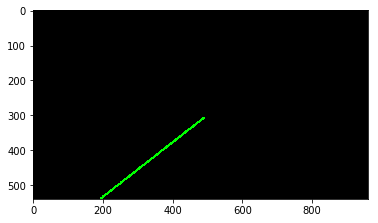

In [52]:
# drawing full extrapolated line and highlighting original line ( green)
line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
first_line = left_lines[0]
print(first_line)
for x1,y1,x2,y2 in first_line:
    x1_result = (540 - y2) / slope(first_line) + x2
    x1_result = int(round(x1_result, 0))
    color=[255, 0, 0]
    thickness=2
    cv2.line(line_img, (x1_result, 540), (x2, y2), color, thickness)
    color=[0, 255, 0]
    thickness=5
    cv2.line(line_img, (x1, y1), (x2, y2), color, thickness)
plt.imshow(line_img)

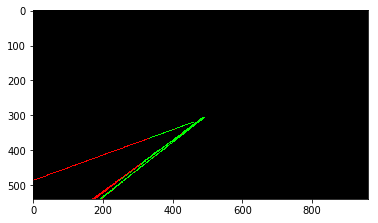

In [53]:
# draw all of the left_lines
line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
for line in left_lines:
    for x1,y1,x2,y2 in line:
        x1_result = (540 - y2) / slope(line) + x2
        x1_result = int(round(x1_result, 0))
        color=[255, 0, 0]
        thickness=2
        cv2.line(line_img, (x1_result, 540), (x2, y2), color, thickness)
        color=[0, 255, 0]
        thickness=2
        cv2.line(line_img, (x1, y1), (x2, y2), color, thickness)
plt.imshow(line_img)

865
885
888
883
891


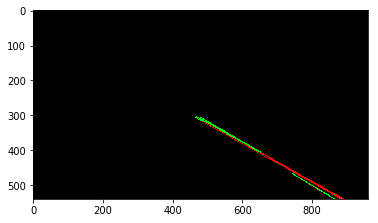

In [54]:
# draw all of the right_lines.  green is original line segments.  red is extrapolated lines
right_line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
for line in right_lines:
    for x1,y1,x2,y2 in line:
        x2_result = (y1 - 540) / slope(line) - x1
        x2_result = int(round(abs(x2_result)))
        print(x2_result)
        color=[255, 0, 0] # red
        thickness=2
        cv2.line(right_line_img, (x1, y1), (x2_result, 540), color, thickness)
        
        color=[0, 255, 0] #green
        thickness=2
        cv2.line(right_line_img, (x1, y1), (x2, y2), color, thickness)
plt.imshow(right_line_img)

In [58]:
# finish full pipeline with extrapolated lines to bottom of image
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    left_lines = []
    right_lines = []
    left_slopes = []
    right_slopes = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            if slope(line) > 0:
                right_lines.append(line)
                right_slopes.append(slope(line))
            else:
                print(slope(line))
                if slope(line) < -0.5:
                    left_lines.append(line)
                    left_slopes.append(slope(line))
    
#     
    for line in right_lines:
        for x1,y1,x2,y2 in line:
            x2_result = (y1 - 540) / slope(line) - x1
            x2_result = int(round(abs(x2_result)))
            color=[255, 0, 0] # red
            thickness=2
            cv2.line(img, (x1, y1), (x2_result, 540), color, thickness)

            color=[0, 255, 0] #green
            thickness=2
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    for line in left_lines:
        for x1,y1,x2,y2 in line:
            x1_result = (540 - y2) / slope(line) + x2
            x1_result = int(round(x1_result, 0))
            color=[255, 0, 0]
            thickness=2
            cv2.line(img, (x1_result, 540), (x2, y2), color, thickness)
            color=[0, 255, 0]
            thickness=2
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

[[194 538 490 307]]
[[176 538 364 397]]
[[246 487 486 307]]
[[195 539 255 491]]
[[310 438 473 319]]


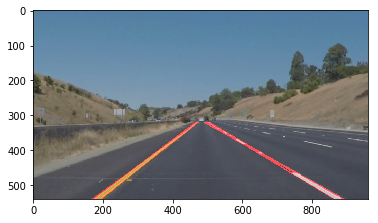

In [95]:
# image_7 whiteCarLaneSwitch.  needs slope filtered
image = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')
gray = grayscale(image)
blur_gray = gaussian_blur(gray, kernal_size)
edges = canny(blur_gray, low_threshold, high_threshold)
masked_image = region_of_interest(edges, vertices)


line_img = hough_lines(masked_image, rho, theta, threshold, min_line_len, max_line_gap)
final_image = cv2.addWeighted(image, 0.8, line_img, 1., 0.)
plt.imshow(final_image)

In [94]:
# finish full pipeline with extrapolated lines to bottom of image and top of image
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    left_lines = []
    right_lines = []
    left_slopes = []
    right_slopes = []
    y_value_of_bottom_of_image = 540
    y_value_top_limit = 320
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            if slope(line) > 0:
                right_lines.append(line)
                right_slopes.append(slope(line))
            else:
                # filter out lines where slope it outside the bounds of a lane line
                if slope(line) < -0.5:
                    left_lines.append(line)
                    left_slopes.append(slope(line))
    
    extrapolated_right_lines = []
    for line in right_lines:
        for x1,y1,x2,y2 in line:
            x1_result = (y_value_top_limit - y2) / slope(line) + x2
            x1_result = int(round(x1_result, 0))
            x2_result = (y1 - y_value_of_bottom_of_image) / slope(line) - x1
            x2_result = int(round(abs(x2_result)))
            extrapolated_right_lines.append([x1, y1, x2_result, y_value_of_bottom_of_image])
            
            color=[255, 0, 0] # red
            thickness=2
            cv2.line(img, (x1_result, y_value_top_limit), (x2_result, y_value_of_bottom_of_image), color, thickness)

            
            
    for line in left_lines:
        for x1,y1,x2,y2 in line:
            print(line)
            x2_result = (y1 - y_value_top_limit) / slope(line) - x1
            x2_result = int(round(abs(x2_result)))
            x1_result = (y_value_of_bottom_of_image - y2) / slope(line) + x2
            x1_result = int(round(x1_result, 0))
            
            color=[255, 0, 0]
            thickness=2
            cv2.line(img, (x1_result, y_value_of_bottom_of_image), (x2_result, y_value_top_limit), color, thickness)
            


[[194 538 490 307]]
[[176 538 364 397]]
[[246 487 486 307]]
[[195 539 255 491]]
[[310 438 473 319]]


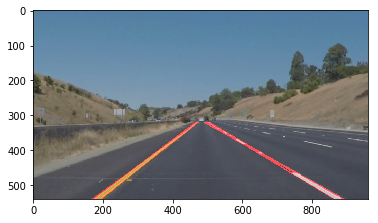

In [96]:
# image_7 whiteCarLaneSwitch.  needs slope filtered
image = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')
gray = grayscale(image)
blur_gray = gaussian_blur(gray, kernal_size)
edges = canny(blur_gray, low_threshold, high_threshold)
masked_image = region_of_interest(edges, vertices)


line_img = hough_lines(masked_image, rho, theta, threshold, min_line_len, max_line_gap)
final_image = cv2.addWeighted(image, 0.8, line_img, 1., 0.)
plt.imshow(final_image)

In [97]:
# averaging lines for each image
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    left_lines = []
    right_lines = []
    left_slopes = []
    right_slopes = []
    y_value_of_bottom_of_image = 540
    y_value_top_limit = 320
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            if slope(line) > 0:
                right_lines.append(line)
                right_slopes.append(slope(line))
            else:
                # filter out lines where slope it outside the bounds of a lane line
                if slope(line) < -0.5:
                    left_lines.append(line)
                    left_slopes.append(slope(line))
    
    extrapolated_right_lines = []
    for line in right_lines:
        for x1,y1,x2,y2 in line:
            x1_result = (y_value_top_limit - y2) / slope(line) + x2
            x1_result = int(round(x1_result, 0))
            x2_result = (y1 - y_value_of_bottom_of_image) / slope(line) - x1
            x2_result = int(round(abs(x2_result)))
            extrapolated_right_lines.append([x1, y1, x2_result, y_value_of_bottom_of_image])
            
            color=[255, 0, 0] # red
            thickness=2
            cv2.line(img, (x1_result, y_value_top_limit), (x2_result, y_value_of_bottom_of_image), color, thickness)

            
            
    for line in left_lines:
        for x1,y1,x2,y2 in line:
            print(line)
            x2_result = (y1 - y_value_top_limit) / slope(line) - x1
            x2_result = int(round(abs(x2_result)))
            x1_result = (y_value_of_bottom_of_image - y2) / slope(line) + x2
            x1_result = int(round(x1_result, 0))
            
            color=[255, 0, 0]
            thickness=2
            cv2.line(img, (x1_result, y_value_of_bottom_of_image), (x2_result, y_value_top_limit), color, thickness)

In [57]:
# image_7 whiteCarLaneSwitch.
image = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')
gray = grayscale(image)
blur_gray = gaussian_blur(gray, kernal_size)
edges = canny(blur_gray, low_threshold, high_threshold)
masked_image = region_of_interest(edges, vertices)


line_img = hough_lines(masked_image, rho, theta, threshold, min_line_len, max_line_gap)
final_image = cv2.addWeighted(image, 0.8, line_img, 1., 0.)
plt.imshow(final_image)

In [40]:
# filter based on slopes

#list(filter(lambda slope: slope < -0.5, right_slopes))

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [68]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[[658, 427, 821, 540]]
[[658, 427, 821, 540], [665, 425, 842, 540]]
[[105 538 455 327]]
[[187 498 429 346]]
[[126 539 333 405]]
[[145 513 456 326]]
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


  1%|          | 4/682 [00:00<00:17, 37.93it/s]

[[658, 427, 821, 540]]
[[658, 427, 821, 540], [665, 425, 842, 540]]
[[105 538 455 327]]
[[187 498 429 346]]
[[126 539 333 405]]
[[145 513 456 326]]
[[515, 325, 821, 540]]
[[515, 325, 821, 540], [685, 439, 840, 540]]
[[515, 325, 821, 540], [685, 439, 840, 540], [678, 442, 819, 540]]
[[515, 325, 821, 540], [685, 439, 840, 540], [678, 442, 819, 540], [679, 440, 818, 540]]
[[515, 325, 821, 540], [685, 439, 840, 540], [678, 442, 819, 540], [679, 440, 818, 540], [689, 440, 843, 540]]
[[515, 325, 821, 540], [685, 439, 840, 540], [678, 442, 819, 540], [679, 440, 818, 540], [689, 440, 843, 540], [502, 311, 817, 540]]
[[105 538 453 329]]
[[196 493 430 346]]
[[202 479 457 325]]
[[127 539 290 433]]
[[713, 457, 841, 540]]
[[713, 457, 841, 540], [704, 459, 820, 540]]
[[713, 457, 841, 540], [704, 459, 820, 540], [714, 457, 842, 540]]
[[106 538 454 328]]
[[217 482 451 331]]
[[181 505 354 393]]
[[412 352 459 323]]
[[541, 345, 844, 540]]
[[541, 345, 844, 540], [752, 481, 843, 540]]
[[541, 345, 844, 540]

  2%|▏         | 14/682 [00:00<00:16, 39.69it/s]

[[120 538 447 333]]
[[139 538 374 385]]
[[240 473 444 336]]
[[532, 336, 859, 540]]
[[120 538 445 335]]
[[142 539 446 334]]
[[247 469 440 339]]
[[250 458 455 325]]
[[507, 315, 853, 540]]
[[507, 315, 853, 540], [503, 310, 822, 540]]
[[174 507 331 406]]
[[268 456 422 352]]
[[143 538 285 443]]
[[361 388 461 318]]
[[393 370 429 347]]
[[342 399 448 332]]
[[417 354 437 341]]
[[123 538 294 431]]
[[127 535 358 390]]
[[506, 313, 829, 540]]
[[506, 313, 829, 540], [522, 328, 861, 540]]
[[124 539 265 448]]
[[144 539 438 340]]
[[305 424 458 321]]
[[670, 420, 861, 540]]
[[670, 420, 861, 540], [522, 328, 837, 540]]
[[145 538 435 342]]
[[362 386 452 327]]
[[165 514 449 330]]
[[146 538 419 354]]
[[126 539 288 434]]
[[686, 432, 859, 540]]
[[686, 432, 859, 540], [513, 321, 838, 540]]
[[686, 432, 859, 540], [513, 321, 838, 540], [679, 434, 837, 540]]
[[686, 432, 859, 540], [513, 321, 838, 540], [679, 434, 837, 540], [522, 329, 864, 540]]
[[686, 432, 859, 540], [513, 321, 838, 540], [679, 434, 837, 540], [5

  3%|▎         | 23/682 [00:00<00:16, 40.43it/s]


[[424 349 438 339]]
[[133 538 315 420]]
[[351 395 381 374]]
[[153 539 435 342]]
[[156 538 430 346]]
[[230 477 448 330]]
[[136 539 453 325]]
[[286 446 433 343]]
[[136 539 449 328]]
[[155 538 429 346]]
[[156 538 416 356]]
[[135 538 150 528]]
[[155 539 414 357]]
[[136 538 450 326]]
[[178 511 445 331]]
[[209 502 352 399]]
[[513, 320, 865, 540]]
[[135 539 447 328]]
[[155 537 425 347]]
[[155 539 248 473]]
[[518, 324, 863, 540]]
[[153 538 423 348]]
[[134 539 445 329]]
[[133 538 294 430]]
[[518, 324, 863, 540]]
[[153 539 413 356]]
[[133 539 447 327]]
[[132 538 277 441]]
[[152 538 419 351]]
[[519, 324, 864, 540]]
[[519, 324, 864, 540], [559, 354, 846, 540]]
[[153 538 418 352]]
[[161 520 447 327]]
[[132 538 223 477]]
[[511, 319, 868, 540]]
[[511, 319, 868, 540], [534, 337, 847, 540]]
[[511, 319, 868, 540], [534, 337, 847, 540], [520, 326, 863, 540]]
[[155 538 406 362]]
[[166 518 442 332]]
[[134 538 249 463]]


  5%|▍         | 33/682 [00:00<00:16, 40.51it/s]

[[687, 429, 866, 540]]
[[687, 429, 866, 540], [506, 314, 841, 540]]
[[687, 429, 866, 540], [506, 314, 841, 540], [676, 430, 844, 540]]
[[137 539 443 332]]
[[157 538 405 364]]
[[280 444 453 323]]
[[157 539 365 393]]
[[164 521 440 335]]
[[706, 441, 872, 540]]
[[706, 441, 872, 540], [700, 442, 851, 540]]
[[706, 441, 872, 540], [700, 442, 851, 540], [505, 312, 840, 540]]
[[706, 441, 872, 540], [700, 442, 851, 540], [505, 312, 840, 540], [699, 444, 853, 540]]
[[139 538 437 337]]
[[158 538 373 387]]
[[316 432 471 301]]
[[738, 458, 875, 540]]
[[738, 458, 875, 540], [800, 505, 855, 540]]
[[738, 458, 875, 540], [800, 505, 855, 540], [514, 320, 851, 540]]
[[738, 458, 875, 540], [800, 505, 855, 540], [514, 320, 851, 540], [728, 459, 853, 540]]
[[139 538 435 338]]
[[199 511 422 349]]
[[342 402 368 383]]
[[357 392 459 316]]
[[159 538 310 432]]
[[505, 310, 857, 540]]
[[505, 310, 857, 540], [766, 481, 857, 540]]
[[505, 310, 857, 540], [766, 481, 857, 540], [775, 480, 878, 540]]
[[140 538 426 345]]
[[

  6%|▌         | 41/682 [00:01<00:16, 38.79it/s]


[[510, 314, 873, 540]]
[[510, 314, 873, 540], [555, 347, 853, 540]]
[[191 521 418 350]]
[[146 538 437 334]]
[[404 360 424 345]]
[[204 511 247 478]]
[[388 368 470 300]]
[[146 539 360 389]]
[[325 421 387 375]]
[[510, 313, 872, 540]]
[[510, 313, 872, 540], [533, 332, 854, 540]]
[[245 482 375 384]]
[[146 539 340 403]]
[[148 537 429 340]]
[[373 379 463 309]]
[[190 522 410 356]]
[[363 391 422 346]]
[[533, 332, 855, 540]]
[[533, 332, 855, 540], [570, 357, 887, 540]]
[[197 517 396 367]]
[[240 474 452 320]]
[[167 538 233 489]]
[[207 497 455 317]]
[[147 538 192 506]]
[[674, 417, 886, 540]]
[[674, 417, 886, 540], [669, 418, 857, 540]]
[[393 362 455 316]]
[[173 535 388 373]]
[[206 498 453 319]]
[[332 414 421 346]]
[[432 331 464 307]]
[[277 446 433 336]]
[[735, 450, 885, 540]]
[[735, 450, 885, 540], [699, 430, 883, 540]]
[[735, 450, 885, 540], [699, 430, 883, 540], [689, 432, 863, 540]]
[[267 454 450 321]]
[[318 424 419 347]]
[[167 538 402 361]]
[[419 341 462 309]]
[[146 538 290 437]]
[[168 539 38

  7%|▋         | 45/682 [00:01<00:27, 23.25it/s]

[[204 510 379 378]]
[[221 485 458 313]]
[[393 365 422 344]]
[[164 539 196 514]]
[[143 539 348 395]]
[[143 538 438 331]]
[[186 523 389 370]]
[[505, 312, 869, 540]]
[[145 538 433 336]]
[[347 402 426 342]]
[[165 538 215 501]]
[[166 539 403 360]]
[[234 477 457 315]]
[[506, 314, 869, 540]]
[[165 539 408 356]]
[[145 539 324 413]]
[[166 538 202 510]]
[[318 417 453 319]]
[[405 357 428 340]]
[[311 422 465 306]]
[[145 538 344 398]]


  7%|▋         | 48/682 [00:01<00:32, 19.71it/s]

[[507, 315, 867, 540]]
[[166 538 443 329]]
[[145 538 342 400]]
[[303 437 467 305]]
[[244 470 459 314]]
[[515, 323, 849, 540]]
[[515, 323, 849, 540], [636, 395, 870, 540]]
[[166 539 411 354]]
[[146 539 306 426]]
[[290 437 458 315]]
[[145 538 444 328]]
[[501, 309, 844, 540]]
[[165 539 400 362]]
[[407 355 440 331]]
[[146 538 291 436]]
[[197 503 460 312]]
[[361 386 470 301]]


  7%|▋         | 51/682 [00:01<00:36, 17.44it/s]

[[663, 411, 877, 540]]
[[663, 411, 877, 540], [504, 312, 855, 540]]
[[206 496 461 311]]
[[165 539 415 350]]
[[144 538 345 397]]
[[435 333 455 317]]
[[392 366 451 321]]
[[682, 423, 879, 540]]
[[682, 423, 879, 540], [507, 315, 852, 540]]
[[682, 423, 879, 540], [507, 315, 852, 540], [533, 335, 859, 540]]
[[682, 423, 879, 540], [507, 315, 852, 540], [533, 335, 859, 540], [673, 423, 856, 540]]
[[682, 423, 879, 540], [507, 315, 852, 540], [533, 335, 859, 540], [673, 423, 856, 540], [686, 424, 880, 540]]
[[144 539 254 460]]
[[165 539 435 335]]
[[221 485 462 310]]
[[164 538 444 327]]
[[325 411 456 316]]
[[703, 437, 882, 540]]
[[703, 437, 882, 540], [533, 336, 861, 540]]
[[703, 437, 882, 540], [533, 336, 861, 540], [500, 309, 856, 540]]
[[703, 437, 882, 540], [533, 336, 861, 540], [500, 309, 856, 540], [695, 437, 861, 540]]
[[703, 437, 882, 540], [533, 336, 861, 540], [500, 309, 856, 540], [695, 437, 861, 540], [503, 312, 854, 540]]
[[703, 437, 882, 540], [533, 336, 861, 540], [500, 309, 856, 5

  8%|▊         | 54/682 [00:01<00:37, 16.53it/s]


[[143 539 348 395]]
[[166 537 446 326]]
[[773, 478, 880, 540]]
[[773, 478, 880, 540], [758, 478, 858, 540]]
[[200 512 448 325]]
[[143 538 451 322]]
[[445 326 459 315]]
[[375 375 471 300]]
[[163 539 291 443]]
[[301 427 457 317]]
[[258 469 436 335]]
[[212 489 306 425]]
[[379 373 471 301]]
[[163 539 450 323]]


  9%|▊         | 58/682 [00:02<00:43, 14.50it/s]

[[142 538 457 317]]
[[162 538 302 436]]
[[259 468 446 327]]
[[321 421 471 300]]
[[141 538 455 318]]
[[200 511 451 322]]
[[265 453 465 308]]
[[142 538 455 319]]
[[162 539 310 428]]
[[232 488 447 326]]
[[406 353 471 302]]


  9%|▉         | 60/682 [00:02<00:43, 14.38it/s]

[[499, 311, 865, 540]]
[[141 538 458 316]]
[[162 538 306 430]]
[[277 452 422 346]]
[[231 488 451 322]]
[[501, 313, 864, 540]]
[[501, 313, 864, 540], [508, 319, 847, 540]]
[[140 539 459 315]]
[[161 537 376 380]]
[[325 417 455 319]]
[[472, 300, 873, 540]]
[[472, 300, 873, 540], [553, 352, 853, 540]]
[[140 538 460 314]]
[[159 538 424 345]]
[[529, 334, 872, 540]]
[[529, 334, 872, 540], [501, 312, 838, 540]]
[[158 538 418 349]]
[[138 539 305 422]]
[[313 418 466 307]]
[[297 429 457 317]]
[[137 538 256 457]]

  9%|▉         | 64/682 [00:02<00:42, 14.64it/s]


[[157 538 437 334]]
[[666, 417, 871, 540]]
[[666, 417, 871, 540], [660, 420, 854, 540]]
[[194 499 461 312]]
[[156 539 421 346]]
[[156 538 439 332]]
[[273 445 456 317]]
[[679, 431, 854, 540]]
[[679, 431, 854, 540], [689, 430, 873, 540]]
[[679, 431, 854, 540], [689, 430, 873, 540], [501, 313, 850, 540]]
[[229 475 459 314]]
[[156 539 437 334]]
[[155 538 448 325]]
[[136 537 350 392]]


 10%|▉         | 66/682 [00:02<00:47, 12.97it/s]

[[703, 446, 853, 540]]
[[703, 446, 853, 540], [472, 300, 870, 540]]
[[703, 446, 853, 540], [472, 300, 870, 540], [711, 445, 876, 540]]
[[703, 446, 853, 540], [472, 300, 870, 540], [711, 445, 876, 540], [519, 328, 873, 540]]
[[156 539 435 336]]
[[137 537 335 403]]
[[354 388 454 320]]
[[279 440 447 326]]
[[734, 466, 850, 540]]
[[734, 466, 850, 540], [747, 465, 873, 540]]
[[734, 466, 850, 540], [747, 465, 873, 540], [733, 464, 851, 540]]
[[156 539 439 333]]
[[228 477 458 316]]
[[139 537 243 465]]
[[406 352 462 312]]
[[773, 490, 850, 540]]
[[773, 490, 850, 540], [786, 490, 870, 540]]
[[773, 490, 850, 540], [786, 490, 870, 540], [773, 491, 849, 540]]
[[245 466 482 300]]
[[158 538 440 333]]
[[203 493 445 329]]

 10%|▉         | 68/682 [00:03<00:46, 13.08it/s]


[[138 539 227 477]]
[[827, 524, 851, 540]]
[[158 538 444 330]]
[[188 505 342 398]]
[[325 411 470 306]]
[[158 539 418 350]]
[[158 539 446 329]]
[[147 533 301 426]]
[[158 524 490 300]]
[[165 534 432 340]]
[[345 398 467 309]]


 11%|█         | 72/682 [00:03<00:44, 13.67it/s]

[[138 538 441 333]]
[[158 539 432 340]]
[[405 354 465 311]]
[[304 425 461 315]]
[[505, 318, 860, 540]]
[[181 508 489 300]]
[[158 538 318 422]]
[[351 400 452 324]]
[[396 362 472 303]]
[[158 524 212 488]]
[[326 418 456 320]]
[[494, 306, 829, 540]]
[[494, 306, 829, 540], [506, 319, 860, 540]]
[[137 538 489 301]]
[[157 538 262 462]]
[[157 539 450 326]]
[[227 489 428 343]]
[[138 537 488 301]]
[[643, 404, 868, 540]]


 11%|█         | 74/682 [00:03<00:45, 13.37it/s]

[[643, 404, 868, 540], [490, 305, 827, 540]]
[[138 537 451 325]]
[[156 538 346 404]]
[[254 460 462 315]]
[[137 539 344 399]]
[[240 478 383 377]]
[[504, 318, 857, 540]]
[[504, 318, 857, 540], [493, 306, 829, 540]]
[[138 538 489 301]]
[[208 503 438 336]]
[[157 539 241 478]]
[[374 378 472 304]]
[[499, 313, 835, 540]]
[[499, 313, 835, 540], [700, 439, 863, 540]]
[[138 539 349 396]]
[[220 495 426 345]]
[[173 528 215 497]]
[[378 374 457 320]]
[[139 537 487 302]]
[[280 451 342 405]]
[[382 372 472 305]]


 11%|█▏        | 78/682 [00:03<00:43, 13.83it/s]

[[661, 424, 839, 540]]
[[661, 424, 839, 540], [672, 424, 866, 540]]
[[661, 424, 839, 540], [672, 424, 866, 540], [472, 300, 857, 540]]
[[138 539 339 403]]
[[165 534 487 300]]
[[306 425 485 300]]
[[562, 360, 866, 540]]
[[562, 360, 866, 540], [693, 437, 865, 540]]
[[562, 360, 866, 540], [693, 437, 865, 540], [684, 437, 838, 540]]
[[562, 360, 866, 540], [693, 437, 865, 540], [684, 437, 838, 540], [482, 300, 837, 540]]
[[562, 360, 866, 540], [693, 437, 865, 540], [684, 437, 838, 540], [482, 300, 837, 540], [681, 437, 840, 540]]
[[411 355 437 337]]
[[261 466 382 378]]
[[139 538 336 405]]
[[198 511 257 467]]
[[453 318 473 302]]
[[159 539 449 328]]
[[375 376 487 300]]
[[340 402 481 300]]
[[534, 341, 866, 540]]
[[534, 341, 866, 540], [719, 453, 864, 540]]
[[534, 341, 866, 540], [719, 453, 864, 540], [707, 453, 839, 540]]
[[534, 341, 866, 540], [719, 453, 864, 540], [707, 453, 839, 540], [803, 514, 844, 540]]
[[534, 341, 866, 540], [719, 453, 864, 540], [707, 453, 839, 540], [803, 514, 844, 540

 12%|█▏        | 80/682 [00:03<00:42, 14.03it/s]

[[753, 474, 864, 540], [738, 475, 844, 540]]
[[753, 474, 864, 540], [738, 475, 844, 540], [739, 474, 837, 540]]
[[753, 474, 864, 540], [738, 475, 844, 540], [739, 474, 837, 540], [740, 474, 842, 540]]
[[203 495 482 300]]
[[158 539 487 300]]
[[194 513 439 335]]
[[137 538 443 331]]
[[801, 502, 864, 540]]
[[801, 502, 864, 540], [782, 501, 842, 540]]
[[174 527 487 300]]
[[241 469 483 300]]
[[300 427 453 323]]
[[137 539 221 481]]
[[201 496 482 300]]
[[340 406 486 300]]
[[155 538 325 419]]
[[137 538 347 396]]
[[156 539 278 451]]
[[356 396 458 319]]


 12%|█▏        | 84/682 [00:04<00:41, 14.31it/s]

[[484, 300, 816, 540]]
[[188 516 486 300]]
[[233 473 481 300]]
[[136 539 231 473]]
[[214 497 260 463]]
[[156 539 215 495]]
[[136 538 321 413]]
[[485, 300, 816, 540]]
[[221 492 486 300]]
[[224 479 480 300]]
[[134 538 380 372]]
[[371 378 472 302]]
[[451 323 482 300]]
[[479, 300, 848, 540]]
[[167 530 484 300]]
[[298 426 460 316]]
[[192 500 316 414]]
[[228 476 480 300]]
[[480, 300, 850, 540]]
[[480, 300, 850, 540], [507, 321, 831, 540]]
[[134 538 378 373]]

 13%|█▎        | 86/682 [00:04<00:42, 14.00it/s]


[[208 501 485 300]]
[[382 370 472 302]]
[[155 538 483 300]]
[[479, 300, 850, 540]]
[[479, 300, 850, 540], [506, 320, 832, 540]]
[[132 538 485 300]]
[[154 538 284 444]]
[[279 449 454 322]]
[[372 377 472 302]]
[[154 539 359 390]]
[[480, 301, 834, 540]]
[[480, 301, 834, 540], [480, 300, 850, 540]]
[[131 538 485 300]]
[[253 467 482 301]]
[[152 538 315 423]]
[[162 530 385 373]]


 13%|█▎        | 90/682 [00:04<00:41, 14.21it/s]

[[505, 319, 833, 540]]
[[505, 319, 833, 540], [555, 354, 864, 540]]
[[130 539 483 301]]
[[193 507 486 301]]
[[369 379 473 304]]
[[229 482 340 407]]
[[338 398 468 310]]
[[671, 422, 859, 540]]
[[671, 422, 859, 540], [658, 422, 841, 540]]
[[671, 422, 859, 540], [658, 422, 841, 540], [491, 307, 834, 540]]
[[149 538 438 335]]
[[129 539 482 301]]
[[678, 435, 839, 540]]
[[678, 435, 839, 540], [693, 436, 861, 540]]
[[678, 435, 839, 540], [693, 436, 861, 540], [484, 302, 838, 540]]
[[130 539 481 302]]
[[149 538 440 334]]
[[717, 454, 860, 540]]

 13%|█▎        | 92/682 [00:04<00:41, 14.11it/s]


[[717, 454, 860, 540], [706, 452, 836, 540]]
[[717, 454, 860, 540], [706, 452, 836, 540], [479, 300, 834, 540]]
[[717, 454, 860, 540], [706, 452, 836, 540], [479, 300, 834, 540], [566, 364, 840, 540]]
[[717, 454, 860, 540], [706, 452, 836, 540], [479, 300, 834, 540], [566, 364, 840, 540], [703, 451, 834, 540]]
[[131 539 482 303]]
[[151 539 356 395]]
[[150 538 488 301]]
[[151 538 439 336]]
[[756, 477, 858, 540]]
[[756, 477, 858, 540], [735, 474, 834, 540]]
[[756, 477, 858, 540], [735, 474, 834, 540], [479, 302, 833, 540]]
[[756, 477, 858, 540], [735, 474, 834, 540], [479, 302, 833, 540], [480, 301, 836, 540]]
[[254 466 488 302]]
[[211 487 488 301]]
[[153 538 433 342]]
[[133 538 300 426]]
[[133 539 488 300]]
[[561, 356, 837, 540]]
[[561, 356, 837, 540], [469, 302, 838, 540]]
[[561, 356, 837, 540], [469, 302, 838, 540], [485, 305, 832, 540]]
[[135 539 485 303]]
[[154 538 488 304]]
[[228 477 488 302]]


 14%|█▍        | 96/682 [00:05<00:40, 14.36it/s]

[[156 539 352 401]]
[[136 539 488 302]]
[[156 538 435 342]]
[[136 538 272 447]]
[[475, 302, 843, 540]]
[[156 538 430 346]]
[[201 496 488 303]]
[[314 419 487 302]]
[[136 539 244 466]]
[[476, 302, 841, 540]]
[[137 539 488 303]]
[[157 538 425 350]]
[[298 430 487 302]]
[[479, 303, 844, 540]]
[[272 456 488 304]]
[[137 538 485 303]]
[[137 539 488 302]]
[[156 538 333 414]]


 15%|█▍        | 100/682 [00:05<00:40, 14.48it/s]

[[470, 301, 854, 540]]
[[470, 301, 854, 540], [477, 301, 821, 540]]
[[224 479 488 301]]
[[188 517 365 389]]
[[137 539 488 302]]
[[156 538 422 351]]
[[475, 300, 845, 540]]
[[475, 300, 845, 540], [474, 300, 832, 540]]
[[418 347 488 300]]
[[162 521 488 301]]
[[156 538 338 410]]
[[138 538 179 511]]
[[271 458 453 326]]
[[483, 301, 826, 540]]
[[483, 301, 826, 540], [473, 300, 829, 540]]
[[483, 301, 826, 540], [473, 300, 829, 540], [481, 302, 843, 540]]
[[137 538 488 301]]
[[173 526 403 364]]
[[277 452 433 342]]
[[423 348 443 334]]
[[138 538 488 302]]
[[474, 300, 831, 540]]

 15%|█▍        | 102/682 [00:05<00:40, 14.37it/s]


[[474, 300, 831, 540], [544, 349, 860, 540]]
[[136 538 485 302]]
[[157 538 276 454]]
[[344 406 488 302]]
[[386 371 471 307]]
[[250 472 360 393]]
[[473, 300, 858, 540]]
[[473, 300, 858, 540], [662, 428, 835, 540]]
[[473, 300, 858, 540], [662, 428, 835, 540], [669, 425, 860, 540]]
[[135 538 485 302]]
[[156 537 425 348]]
[[338 403 485 300]]
[[156 539 318 422]]
[[694, 439, 855, 540]]
[[694, 439, 855, 540], [758, 489, 834, 540]]
[[694, 439, 855, 540], [758, 489, 834, 540], [738, 476, 833, 540]]
[[694, 439, 855, 540], [758, 489, 834, 540], [738, 476, 833, 540], [682, 439, 832, 540]]
[[134 538 301 426]]
[[135 539 485 302]]
[[155 538 414 356]]
[[211 498 426 347]]


 16%|█▌        | 106/682 [00:05<00:41, 13.77it/s]

[[723, 457, 856, 540]]
[[723, 457, 856, 540], [708, 456, 833, 540]]
[[723, 457, 856, 540], [708, 456, 833, 540], [711, 459, 833, 540]]
[[134 539 487 301]]
[[154 538 434 341]]
[[156 537 407 361]]
[[755, 477, 857, 540]]
[[755, 477, 857, 540], [479, 302, 835, 540]]
[[755, 477, 857, 540], [479, 302, 835, 540], [485, 304, 838, 540]]
[[755, 477, 857, 540], [479, 302, 835, 540], [485, 304, 838, 540], [741, 479, 838, 540]]
[[179 508 487 301]]
[[153 538 420 351]]
[[422 343 485 300]]
[[434 334 484 300]]
[[245 463 438 337]]
[[407 354 487 300]]
[[473, 300, 860, 540]]
[[473, 300, 860, 540], [800, 505, 857, 540]]
[[473, 300, 860, 540], [800, 505, 857, 540], [786, 507, 834, 540]]
[[204 492 487 301]]
[[153 538 421 350]]
[[132 538 161 519]]
[[153 539 401 365]]
[[417 347 487 300]]


 16%|█▌        | 108/682 [00:05<00:41, 13.77it/s]

[[486, 307, 861, 540]]
[[133 539 316 416]]
[[152 538 429 344]]
[[249 462 487 302]]
[[282 449 312 427]]
[[363 385 478 302]]
[[153 539 412 357]]
[[472, 301, 857, 540]]
[[215 485 484 304]]
[[154 538 415 355]]
[[132 538 200 493]]
[[153 538 427 346]]
[[412 351 486 301]]
[[484, 307, 831, 540]]
[[156 538 394 371]]
[[134 539 263 452]]
[[320 416 485 301]]
[[316 417 486 306]]
[[318 424 487 302]]
[[134 538 305 426]]
[[473, 302, 854, 540]]
[[156 538 407 362]]
[[134 538 313 421]]
[[243 466 442 336]]

 16%|█▋        | 112/682 [00:06<00:40, 14.04it/s]


[[390 369 467 311]]
[[476, 303, 829, 540]]
[[476, 303, 829, 540], [473, 303, 855, 540]]
[[156 539 398 369]]
[[135 538 276 446]]
[[161 522 487 303]]
[[155 538 430 345]]
[[303 428 485 301]]
[[479, 304, 830, 540]]
[[479, 304, 830, 540], [483, 304, 842, 540]]
[[299 431 489 303]]
[[156 538 418 354]]
[[206 493 488 303]]
[[136 538 220 482]]
[[157 538 397 370]]


 17%|█▋        | 114/682 [00:06<00:40, 14.09it/s]

[[475, 302, 857, 540]]
[[475, 302, 857, 540], [493, 314, 830, 540]]
[[137 539 480 308]]
[[157 538 391 374]]
[[394 365 487 302]]
[[662, 419, 858, 540]]
[[662, 419, 858, 540], [483, 304, 834, 540]]
[[662, 419, 858, 540], [483, 304, 834, 540], [481, 304, 831, 540]]
[[137 539 480 308]]
[[157 538 396 370]]
[[391 367 487 302]]
[[158 538 359 397]]
[[266 453 320 416]]
[[475, 302, 858, 540]]
[[475, 302, 858, 540], [672, 432, 838, 540]]
[[475, 302, 858, 540], [672, 432, 838, 540], [485, 307, 862, 540]]
[[475, 302, 858, 540], [672, 432, 838, 540], [485, 307, 862, 540], [683, 431, 859, 540]]
[[220 484 489 303]]
[[157 538 397 369]]
[[149 531 394 366]]
[[137 538 480 307]]
[[158 538 377 384]]
[[695, 446, 839, 540]]
[[695, 446, 839, 540], [476, 303, 856, 540]]
[[695, 446, 839, 540], [476, 303, 856, 540], [713, 449, 860, 540]]
[[695, 446, 839, 540], [476, 303, 856, 540], [713, 449, 860, 540], [479, 304, 857, 540]]
[[137 539 481 307]]
[[362 393 490 303]]
[[233 486 488 301]]
[[137 538 244 466]]
[[290 437

 17%|█▋        | 118/682 [00:06<00:39, 14.17it/s]


[[157 538 385 378]]
[[539, 345, 838, 540]]
[[539, 345, 838, 540], [724, 464, 837, 540]]
[[539, 345, 838, 540], [724, 464, 837, 540], [480, 304, 858, 540]]
[[539, 345, 838, 540], [724, 464, 837, 540], [480, 304, 858, 540], [750, 471, 861, 540]]
[[539, 345, 838, 540], [724, 464, 837, 540], [480, 304, 858, 540], [750, 471, 861, 540], [484, 303, 836, 540]]
[[539, 345, 838, 540], [724, 464, 837, 540], [480, 304, 858, 540], [750, 471, 861, 540], [484, 303, 836, 540], [476, 303, 839, 540]]
[[213 488 385 372]]
[[156 538 380 381]]
[[136 538 209 489]]
[[373 379 485 303]]
[[136 539 481 307]]
[[440 336 468 316]]
[[539, 345, 840, 540]]
[[539, 345, 840, 540], [761, 488, 838, 540]]
[[539, 345, 840, 540], [761, 488, 838, 540], [774, 487, 860, 540]]
[[539, 345, 840, 540], [761, 488, 838, 540], [774, 487, 860, 540], [761, 490, 837, 540]]
[[539, 345, 840, 540], [761, 488, 838, 540], [774, 487, 860, 540], [761, 490, 837, 540], [475, 302, 854, 540]]
[[212 489 375 379]]
[[220 495 327 418]]
[[136 538 235 47

 18%|█▊        | 120/682 [00:06<00:39, 14.26it/s]

[[481, 304, 857, 540]]
[[137 539 485 304]]
[[228 490 468 316]]
[[271 450 478 305]]
[[280 453 480 308]]
[[479, 304, 856, 540]]
[[138 538 412 353]]
[[228 490 489 301]]
[[361 387 488 301]]
[[158 538 349 404]]
[[481, 305, 857, 540]]
[[139 538 392 367]]
[[162 537 298 439]]
[[309 433 379 382]]
[[240 482 483 306]]
[[424 343 486 301]]
[[206 506 489 301]]


 18%|█▊        | 124/682 [00:07<00:39, 14.21it/s]

[[480, 305, 858, 540]]
[[480, 305, 858, 540], [488, 305, 825, 540]]
[[139 538 391 368]]
[[159 538 330 418]]
[[226 492 483 306]]
[[351 394 482 305]]
[[481, 305, 857, 540]]
[[481, 305, 857, 540], [551, 353, 841, 540]]
[[257 471 481 309]]
[[140 539 358 391]]
[[162 539 483 306]]
[[179 526 222 494]]
[[417 350 480 305]]
[[252 464 462 317]]
[[485, 309, 857, 540]]
[[485, 309, 857, 540], [484, 309, 843, 540]]
[[485, 309, 857, 540], [484, 309, 843, 540], [489, 305, 826, 540]]
[[177 528 479 309]]
[[297 432 471 314]]
[[141 538 372 382]]
[[252 465 471 312]]


 18%|█▊        | 126/682 [00:07<00:38, 14.32it/s]

[[560, 359, 837, 540]]
[[560, 359, 837, 540], [482, 306, 859, 540]]
[[163 539 483 307]]
[[193 505 471 311]]
[[325 414 480 306]]
[[347 404 372 387]]
[[141 538 322 416]]
[[486, 308, 860, 540]]
[[486, 308, 860, 540], [655, 420, 842, 540]]
[[486, 308, 860, 540], [655, 420, 842, 540], [534, 341, 864, 540]]
[[486, 308, 860, 540], [655, 420, 842, 540], [534, 341, 864, 540], [470, 300, 838, 540]]
[[164 538 483 307]]
[[143 539 317 418]]
[[306 427 480 306]]
[[667, 429, 838, 540]]
[[667, 429, 838, 540], [469, 302, 867, 540]]
[[667, 429, 838, 540], [469, 302, 867, 540], [678, 428, 867, 540]]
[[667, 429, 838, 540], [469, 302, 867, 540], [678, 428, 867, 540], [686, 433, 858, 540]]
[[667, 429, 838, 540], [469, 302, 867, 540], [678, 428, 867, 540], [686, 433, 858, 540], [490, 306, 835, 540]]
[[164 538 489 302]]
[[298 431 481 307]]
[[148 536 316 419]]
[[290 438 471 312]]


 19%|█▉        | 130/682 [00:07<00:38, 14.37it/s]

[[483, 308, 841, 540]]
[[483, 308, 841, 540], [688, 442, 838, 540]]
[[483, 308, 841, 540], [688, 442, 838, 540], [698, 442, 863, 540]]
[[483, 308, 841, 540], [688, 442, 838, 540], [698, 442, 863, 540], [700, 442, 863, 540]]
[[164 538 403 365]]
[[144 537 404 361]]
[[227 480 424 347]]
[[445 332 470 313]]
[[303 441 479 308]]
[[471, 301, 841, 540]]
[[471, 301, 841, 540], [735, 461, 862, 540]]
[[471, 301, 841, 540], [735, 461, 862, 540], [715, 460, 839, 540]]
[[471, 301, 841, 540], [735, 461, 862, 540], [715, 460, 839, 540], [489, 306, 834, 540]]
[[471, 301, 841, 540], [735, 461, 862, 540], [715, 460, 839, 540], [489, 306, 834, 540], [470, 301, 840, 540]]
[[471, 301, 841, 540], [735, 461, 862, 540], [715, 460, 839, 540], [489, 306, 834, 540], [470, 301, 840, 540], [728, 460, 863, 540]]
[[164 539 489 303]]
[[143 539 262 458]]
[[306 428 479 307]]
[[142 538 417 352]]
[[203 511 489 304]]
[[539, 345, 862, 540]]
[[539, 345, 862, 540], [767, 482, 864, 540]]
[[539, 345, 862, 540], [767, 482, 864, 5

 19%|█▉        | 132/682 [00:07<00:38, 14.38it/s]


[[273 449 487 304]]
[[186 523 478 311]]
[[425 349 483 310]]
[[142 538 404 361]]
[[406 358 477 310]]
[[153 530 477 311]]
[[470, 301, 868, 540]]
[[204 510 488 304]]
[[295 435 478 307]]
[[141 538 408 358]]
[[163 539 487 304]]


 20%|█▉        | 134/682 [00:07<00:39, 13.81it/s]

[[471, 301, 841, 540]]
[[471, 301, 841, 540], [473, 300, 860, 540]]
[[164 539 481 309]]
[[142 538 407 359]]
[[409 356 480 308]]
[[221 498 479 311]]
[[472, 300, 858, 540]]
[[472, 300, 858, 540], [471, 301, 839, 540]]
[[145 536 414 354]]
[[163 538 255 472]]
[[163 539 480 309]]
[[356 401 481 311]]
[[173 533 479 311]]
[[471, 301, 840, 540]]
[[471, 301, 840, 540], [474, 300, 860, 540]]
[[142 538 406 360]]
[[164 539 480 309]]
[[370 391 480 312]]
[[223 497 478 312]]
[[398 364 479 309]]


 20%|██        | 138/682 [00:08<00:39, 13.79it/s]

[[468, 303, 862, 540]]
[[468, 303, 862, 540], [485, 311, 838, 540]]
[[468, 303, 862, 540], [485, 311, 838, 540], [474, 301, 858, 540]]
[[245 469 480 310]]
[[205 511 477 313]]
[[165 538 479 310]]
[[144 538 388 373]]
[[472, 301, 841, 540]]
[[472, 301, 841, 540], [474, 300, 859, 540]]
[[472, 301, 841, 540], [474, 300, 859, 540], [471, 301, 838, 540]]
[[143 538 387 373]]
[[165 538 480 309]]
[[323 425 481 311]]
[[366 386 479 309]]
[[659, 424, 838, 540]]
[[659, 424, 838, 540], [666, 421, 866, 540]]
[[659, 424, 838, 540], [666, 421, 866, 540], [658, 422, 840, 540]]
[[164 539 479 310]]
[[142 538 398 365]]
[[400 362 478 309]]
[[677, 435, 839, 540]]
[[677, 435, 839, 540], [686, 433, 864, 540]]
[[677, 435, 839, 540], [686, 433, 864, 540], [677, 434, 840, 540]]
[[163 538 485 305]]
[[257 461 475 309]]
[[426 348 486 307]]
[[142 538 380 377]]
[[141 538 397 365]]

 21%|██        | 142/682 [00:08<00:38, 14.05it/s]


[[713, 449, 865, 540]]
[[713, 449, 865, 540], [471, 301, 841, 540]]
[[713, 449, 865, 540], [471, 301, 841, 540], [470, 301, 838, 540]]
[[713, 449, 865, 540], [471, 301, 841, 540], [470, 301, 838, 540], [701, 449, 841, 540]]
[[713, 449, 865, 540], [471, 301, 841, 540], [470, 301, 838, 540], [701, 449, 841, 540], [711, 448, 863, 540]]
[[226 494 477 312]]
[[266 455 473 310]]
[[142 539 331 411]]
[[163 539 475 312]]
[[742, 468, 862, 540]]
[[742, 468, 862, 540], [731, 470, 839, 540]]
[[742, 468, 862, 540], [731, 470, 839, 540], [471, 302, 838, 540]]
[[742, 468, 862, 540], [731, 470, 839, 540], [471, 302, 838, 540], [473, 301, 843, 540]]
[[164 539 479 310]]
[[143 539 314 423]]
[[278 447 475 309]]
[[191 520 477 313]]


 21%|██        | 144/682 [00:08<00:38, 14.10it/s]

[[787, 493, 866, 540]]
[[787, 493, 866, 540], [469, 302, 864, 540]]
[[787, 493, 866, 540], [469, 302, 864, 540], [785, 493, 864, 540]]
[[787, 493, 866, 540], [469, 302, 864, 540], [785, 493, 864, 540], [472, 301, 842, 540]]
[[166 537 475 313]]
[[142 538 386 373]]
[[317 419 478 310]]
[[164 539 475 313]]
[[459 325 478 312]]
[[410 359 482 310]]
[[268 454 467 315]]
[[143 538 201 498]]
[[187 509 311 423]]
[[467, 304, 877, 540]]
[[165 538 483 307]]
[[207 496 473 310]]
[[144 539 262 457]]
[[354 394 472 314]]
[[165 539 484 307]]
[[485, 311, 837, 540]]
[[164 539 475 313]]
[[143 538 306 428]]
[[331 409 477 310]]
[[282 443 330 411]]


 22%|██▏       | 148/682 [00:08<00:36, 14.61it/s]

[[550, 353, 875, 540]]
[[550, 353, 875, 540], [471, 301, 840, 540]]
[[162 539 472 314]]
[[284 441 467 317]]
[[142 538 365 387]]
[[471, 301, 839, 540]]
[[471, 301, 839, 540], [473, 300, 859, 540]]
[[163 538 413 357]]
[[227 480 475 312]]
[[142 538 337 406]]
[[163 539 466 319]]
[[472, 301, 840, 540]]
[[472, 301, 840, 540], [466, 304, 875, 540]]
[[166 537 475 313]]
[[143 537 474 313]]
[[163 539 415 356]]
[[142 538 305 428]]


 22%|██▏       | 152/682 [00:08<00:36, 14.37it/s]

[[471, 301, 869, 540]]
[[471, 301, 869, 540], [467, 304, 876, 540]]
[[471, 301, 869, 540], [467, 304, 876, 540], [497, 317, 840, 540]]
[[201 497 474 312]]
[[163 538 468 317]]
[[142 538 265 455]]
[[222 483 284 442]]
[[470, 302, 865, 540]]
[[470, 302, 865, 540], [471, 302, 841, 540]]
[[470, 302, 865, 540], [471, 302, 841, 540], [467, 304, 856, 540]]
[[470, 302, 865, 540], [471, 302, 841, 540], [467, 304, 856, 540], [651, 418, 850, 540]]
[[164 538 474 313]]
[[142 538 486 306]]
[[290 437 473 313]]
[[471, 302, 871, 540]]
[[471, 302, 871, 540], [702, 451, 844, 540]]
[[471, 302, 871, 540], [702, 451, 844, 540], [676, 427, 871, 540]]
[[471, 302, 871, 540], [702, 451, 844, 540], [676, 427, 871, 540], [668, 429, 848, 540]]
[[471, 302, 871, 540], [702, 451, 844, 540], [676, 427, 871, 540], [668, 429, 848, 540], [469, 304, 866, 540]]
[[164 539 475 313]]
[[142 538 485 307]]
[[295 434 471 315]]
[[702, 441, 867, 540]]


 23%|██▎       | 154/682 [00:09<00:38, 13.88it/s]

[[702, 441, 867, 540], [475, 300, 845, 540]]
[[702, 441, 867, 540], [475, 300, 845, 540], [691, 443, 846, 540]]
[[164 539 468 318]]
[[228 480 461 322]]
[[143 538 484 308]]
[[403 367 484 309]]
[[728, 457, 867, 540]]
[[728, 457, 867, 540], [718, 460, 846, 540]]
[[145 537 486 307]]
[[277 456 488 308]]
[[166 538 406 364]]
[[767, 480, 867, 540]]
[[767, 480, 867, 540], [753, 482, 847, 540]]
[[168 538 411 362]]
[[147 538 259 462]]
[[210 494 487 307]]
[[146 538 488 307]]
[[225 495 305 438]]
[[400 371 485 310]]
[[473, 304, 867, 540]]

 23%|██▎       | 158/682 [00:09<00:37, 14.04it/s]


[[473, 304, 867, 540], [800, 512, 845, 540]]
[[166 525 487 308]]
[[168 539 399 371]]
[[284 453 489 309]]
[[193 507 482 312]]
[[273 462 487 312]]
[[168 538 250 480]]
[[180 529 303 442]]
[[149 538 288 444]]
[[150 538 488 310]]
[[170 539 398 374]]
[[240 476 486 310]]
[[234 491 487 313]]


 23%|██▎       | 160/682 [00:09<00:36, 14.18it/s]

[[471, 306, 876, 540]]
[[471, 306, 876, 540], [457, 300, 858, 540]]
[[151 538 290 444]]
[[171 539 396 376]]
[[324 419 489 311]]
[[286 454 476 321]]
[[206 500 487 310]]
[[457, 300, 857, 540]]
[[457, 300, 857, 540], [482, 313, 874, 540]]
[[212 497 489 310]]
[[283 457 487 314]]
[[232 494 345 414]]
[[450 338 489 311]]
[[153 538 249 473]]
[[457, 300, 857, 540]]
[[457, 300, 857, 540], [470, 306, 876, 540]]
[[457, 300, 857, 540], [470, 306, 876, 540], [625, 402, 856, 540]]
[[173 538 393 379]]
[[228 488 372 388]]
[[204 503 486 313]]
[[154 538 225 490]]
[[472, 305, 850, 540]]
[[472, 305, 850, 540], [474, 304, 868, 540]]
[[175 538 489 310]]
[[178 523 359 397]]
[[236 481 474 320]]
[[203 504 490 310]]


 24%|██▍       | 164/682 [00:09<00:38, 13.33it/s]

[[657, 414, 878, 540]]
[[657, 414, 878, 540], [471, 305, 851, 540]]
[[657, 414, 878, 540], [471, 305, 851, 540], [473, 305, 853, 540]]
[[657, 414, 878, 540], [471, 305, 851, 540], [473, 305, 853, 540], [652, 417, 859, 540]]
[[447 340 489 309]]
[[174 538 385 385]]
[[154 538 248 473]]
[[360 398 489 308]]
[[155 539 349 404]]
[[272 458 468 321]]
[[474, 304, 854, 540]]
[[474, 304, 854, 540], [473, 304, 853, 540]]
[[474, 304, 854, 540], [473, 304, 853, 540], [667, 424, 852, 540]]
[[474, 304, 854, 540], [473, 304, 853, 540], [667, 424, 852, 540], [681, 425, 874, 540]]
[[174 538 490 309]]
[[290 446 488 308]]
[[155 538 261 464]]
[[155 539 324 421]]
[[698, 436, 878, 540]]
[[698, 436, 878, 540], [688, 436, 856, 540]]
[[698, 436, 878, 540], [688, 436, 856, 540], [688, 438, 856, 540]]
[[698, 436, 878, 540], [688, 436, 856, 540], [688, 438, 856, 540], [696, 436, 878, 540]]
[[176 538 490 310]]
[[191 513 490 311]]
[[282 452 488 308]]


 25%|██▍       | 168/682 [00:10<00:37, 13.58it/s]

[[725, 451, 879, 540]]
[[725, 451, 879, 540], [714, 452, 859, 540]]
[[174 539 490 309]]
[[257 469 485 310]]
[[155 539 326 420]]
[[746, 471, 860, 540]]
[[746, 471, 860, 540], [756, 469, 879, 540]]
[[746, 471, 860, 540], [756, 469, 879, 540], [760, 470, 881, 540]]
[[176 538 487 312]]
[[279 454 490 307]]
[[155 538 239 480]]
[[156 537 276 456]]
[[374 389 474 314]]
[[174 539 490 309]]
[[483, 313, 870, 540]]
[[483, 313, 870, 540], [789, 496, 860, 540]]
[[483, 313, 870, 540], [789, 496, 860, 540], [802, 495, 880, 540]]
[[483, 313, 870, 540], [789, 496, 860, 540], [802, 495, 880, 540], [473, 303, 881, 540]]
[[157 539 489 307]]
[[406 370 487 311]]
[[176 539 423 359]]
[[176 538 491 309]]
[[348 407 477 314]]


 25%|██▍       | 170/682 [00:10<00:37, 13.75it/s]

[[164 535 490 307]]
[[178 538 410 369]]
[[158 538 221 495]]
[[438 346 487 310]]
[[472, 303, 881, 540]]
[[158 539 327 421]]
[[178 538 391 383]]
[[338 415 479 313]]
[[274 469 487 309]]
[[471, 303, 883, 540]]
[[418 356 488 307]]
[[159 538 490 307]]
[[179 538 378 393]]
[[160 539 490 308]]
[[327 430 475 319]]
[[473, 303, 885, 540]]
[[473, 303, 885, 540], [617, 391, 872, 540]]
[[282 464 490 308]]
[[161 538 465 325]]
[[374 390 470 315]]
[[160 538 490 307]]
[[181 537 378 393]]


 26%|██▌       | 174/682 [00:10<00:36, 14.04it/s]

[[627, 397, 874, 540]]
[[627, 397, 874, 540], [468, 305, 893, 540]]
[[627, 397, 874, 540], [468, 305, 893, 540], [471, 304, 897, 540]]
[[162 539 373 391]]
[[229 504 490 308]]
[[161 538 477 317]]
[[250 488 292 456]]
[[222 509 270 472]]
[[472, 302, 869, 540]]
[[472, 302, 869, 540], [565, 354, 889, 540]]
[[182 538 269 473]]
[[162 538 490 308]]
[[209 519 428 354]]
[[346 408 490 307]]
[[471, 302, 869, 540]]
[[471, 302, 869, 540], [574, 359, 887, 540]]
[[471, 302, 869, 540], [574, 359, 887, 540], [476, 300, 862, 540]]
[[229 493 479 312]]
[[183 539 423 358]]
[[163 539 237 486]]
[[279 456 487 310]]
[[471, 302, 869, 540]]
[[471, 302, 869, 540], [556, 349, 896, 540]]
[[471, 302, 869, 540], [556, 349, 896, 540], [469, 303, 900, 540]]
[[471, 302, 869, 540], [556, 349, 896, 540], [469, 303, 900, 540], [667, 419, 875, 540]]
[[471, 302, 869, 540], [556, 349, 896, 540], [469, 303, 900, 540], [667, 419, 875, 540], [675, 417, 887, 540]]
[[242 485 486 308]]
[[185 539 364 404]]
[[201 514 479 312]]
[[185 5

 26%|██▌       | 178/682 [00:10<00:35, 14.11it/s]

[[469, 304, 893, 540]]
[[469, 304, 893, 540], [695, 434, 867, 540]]
[[469, 304, 893, 540], [695, 434, 867, 540], [694, 428, 897, 540]]
[[469, 304, 893, 540], [695, 434, 867, 540], [694, 428, 897, 540], [467, 305, 894, 540]]
[[168 538 479 312]]
[[264 481 486 308]]
[[321 429 476 313]]
[[230 505 412 367]]
[[264 470 331 420]]
[[188 538 246 493]]
[[722, 443, 890, 540]]
[[722, 443, 890, 540], [711, 444, 871, 540]]
[[722, 443, 890, 540], [711, 444, 871, 540], [780, 477, 893, 540]]
[[222 514 489 306]]
[[300 445 474 314]]
[[169 539 490 306]]
[[749, 460, 894, 540]]
[[749, 460, 894, 540], [749, 466, 873, 540]]
[[749, 460, 894, 540], [749, 466, 873, 540], [751, 460, 896, 540]]
[[177 534 378 388]]
[[193 537 488 307]]
[[331 422 475 314]]
[[170 539 489 307]]
[[261 485 490 307]]


 27%|██▋       | 182/682 [00:11<00:35, 14.10it/s]

[[470, 305, 895, 540]]
[[470, 305, 895, 540], [795, 484, 896, 540]]
[[470, 305, 895, 540], [795, 484, 896, 540], [779, 485, 874, 540]]
[[470, 305, 895, 540], [795, 484, 896, 540], [779, 485, 874, 540], [471, 304, 898, 540]]
[[171 538 488 307]]
[[203 530 488 308]]
[[228 498 306 440]]
[[172 538 487 309]]
[[846, 512, 897, 540]]
[[846, 512, 897, 540], [476, 301, 874, 540]]
[[846, 512, 897, 540], [476, 301, 874, 540], [470, 304, 882, 540]]
[[846, 512, 897, 540], [476, 301, 874, 540], [470, 304, 882, 540], [833, 514, 877, 540]]
[[171 539 382 385]]
[[192 539 489 307]]
[[324 427 475 314]]
[[456, 301, 921, 540]]
[[192 538 482 311]]
[[171 538 485 310]]
[[407 364 478 312]]


 27%|██▋       | 184/682 [00:11<00:34, 14.42it/s]

[[468, 305, 911, 540]]
[[193 538 489 307]]
[[171 538 350 408]]
[[325 426 476 313]]
[[484, 311, 898, 540]]
[[484, 311, 898, 540], [456, 300, 889, 540]]
[[171 538 487 308]]
[[192 538 487 307]]
[[266 482 389 383]]
[[207 528 287 464]]
[[303 443 475 314]]
[[471, 304, 898, 540]]
[[471, 304, 898, 540], [455, 300, 890, 540]]
[[429 352 489 308]]
[[174 539 345 411]]
[[194 538 409 370]]
[[358 403 476 311]]
[[193 538 488 308]]
[[254 478 487 308]]


 28%|██▊       | 188/682 [00:11<00:36, 13.44it/s]

[[634, 401, 877, 540]]
[[634, 401, 877, 540], [470, 304, 896, 540]]
[[634, 401, 877, 540], [470, 304, 896, 540], [455, 300, 886, 540]]
[[176 537 319 430]]
[[194 538 420 361]]
[[244 487 473 315]]
[[193 538 482 312]]
[[173 538 370 394]]
[[481, 312, 877, 540]]
[[481, 312, 877, 540], [469, 304, 893, 540]]
[[240 490 473 315]]
[[194 539 353 414]]
[[193 538 487 308]]
[[299 445 485 309]]
[[661, 416, 876, 540]]
[[661, 416, 876, 540], [671, 415, 898, 540]]
[[282 459 475 314]]
[[196 536 419 361]]
[[239 491 474 314]]
[[194 538 369 401]]
[[423 356 489 308]]
[[173 538 265 471]]
[[678, 425, 877, 540]]
[[678, 425, 877, 540], [690, 425, 898, 540]]
[[678, 425, 877, 540], [690, 425, 898, 540], [468, 304, 896, 540]]
[[174 539 476 312]]
[[221 518 370 398]]

 28%|██▊       | 190/682 [00:11<00:36, 13.62it/s]


[[193 538 409 369]]
[[419 359 485 311]]
[[173 538 215 507]]
[[571, 365, 899, 540]]
[[571, 365, 899, 540], [710, 438, 902, 540]]
[[571, 365, 899, 540], [710, 438, 902, 540], [700, 439, 875, 540]]
[[571, 365, 899, 540], [710, 438, 902, 540], [700, 439, 875, 540], [705, 437, 900, 540]]
[[290 453 408 364]]
[[197 534 486 308]]
[[201 517 328 424]]
[[218 506 475 313]]
[[213 524 351 413]]
[[174 539 475 312]]
[[727, 455, 875, 540]]
[[727, 455, 875, 540], [743, 455, 896, 540]]
[[727, 455, 875, 540], [743, 455, 896, 540], [464, 307, 901, 540]]
[[174 539 473 314]]
[[193 538 407 370]]
[[413 363 488 308]]
[[216 522 472 315]]


 28%|██▊       | 194/682 [00:12<00:36, 13.41it/s]

[[468, 304, 877, 540]]
[[468, 304, 877, 540], [779, 475, 898, 540]]
[[468, 304, 877, 540], [779, 475, 898, 540], [762, 474, 876, 540]]
[[205 530 322 436]]
[[206 515 473 314]]
[[173 539 471 315]]
[[193 538 387 386]]
[[227 513 462 323]]
[[807, 500, 876, 540]]
[[807, 500, 876, 540], [822, 499, 899, 540]]
[[807, 500, 876, 540], [822, 499, 899, 540], [466, 304, 890, 540]]
[[173 538 474 312]]
[[193 538 299 455]]
[[295 458 474 313]]
[[193 537 398 376]]
[[291 450 484 309]]
[[451, 302, 922, 540]]
[[172 539 472 313]]
[[191 538 380 390]]
[[399 373 477 312]]
[[338 422 485 307]]


 29%|██▊       | 196/682 [00:12<00:35, 13.50it/s]

[[464, 305, 903, 540]]
[[171 539 471 313]]
[[191 539 308 445]]
[[190 538 390 381]]
[[243 484 486 307]]
[[452, 300, 905, 540]]
[[172 538 472 312]]
[[192 539 313 441]]
[[348 413 477 312]]
[[464, 305, 904, 540]]
[[171 539 472 312]]
[[195 534 377 391]]
[[171 538 472 311]]
[[191 539 319 436]]
[[282 467 473 313]]


 29%|██▉       | 200/682 [00:12<00:35, 13.74it/s]

[[622, 396, 872, 540]]
[[622, 396, 872, 540], [466, 304, 891, 540]]
[[622, 396, 872, 540], [466, 304, 891, 540], [453, 302, 899, 540]]
[[171 539 301 441]]
[[201 531 317 438]]
[[198 519 471 314]]
[[311 443 482 309]]
[[191 538 368 399]]
[[450, 301, 900, 540]]
[[450, 301, 900, 540], [465, 305, 874, 540]]
[[450, 301, 900, 540], [465, 305, 874, 540], [466, 304, 894, 540]]
[[258 474 472 313]]
[[190 538 361 404]]
[[170 539 472 311]]
[[334 424 469 318]]
[[464, 306, 871, 540]]
[[464, 306, 871, 540], [466, 304, 892, 540]]
[[464, 306, 871, 540], [466, 304, 892, 540], [647, 412, 871, 540]]
[[188 538 476 313]]
[[415 356 472 313]]
[[169 539 467 315]]
[[222 500 468 315]]
[[220 515 295 455]]


 30%|██▉       | 202/682 [00:12<00:34, 13.76it/s]

[[469, 303, 864, 540]]
[[469, 303, 864, 540], [666, 418, 897, 540]]
[[248 480 472 312]]
[[418 358 484 307]]
[[188 538 349 412]]
[[167 538 294 445]]
[[342 416 472 314]]
[[689, 430, 889, 540]]
[[689, 430, 889, 540], [681, 430, 865, 540]]
[[689, 430, 889, 540], [681, 430, 865, 540], [466, 304, 892, 540]]
[[689, 430, 889, 540], [681, 430, 865, 540], [466, 304, 892, 540], [463, 305, 870, 540]]
[[689, 430, 889, 540], [681, 430, 865, 540], [466, 304, 892, 540], [463, 305, 870, 540], [682, 431, 860, 540]]
[[205 511 471 311]]
[[186 538 481 308]]
[[187 539 323 432]]
[[712, 444, 886, 540]]
[[712, 444, 886, 540], [706, 445, 864, 540]]
[[712, 444, 886, 540], [706, 445, 864, 540], [706, 447, 866, 540]]
[[187 538 481 308]]
[[198 516 471 311]]
[[167 539 362 392]]
[[285 462 471 312]]


 30%|███       | 206/682 [00:12<00:34, 13.75it/s]

[[451, 300, 887, 540]]
[[451, 300, 887, 540], [735, 465, 864, 540]]
[[451, 300, 887, 540], [735, 465, 864, 540], [745, 463, 885, 540]]
[[451, 300, 887, 540], [735, 465, 864, 540], [745, 463, 885, 540], [464, 305, 890, 540]]
[[413 357 466 315]]
[[186 538 473 314]]
[[271 460 471 314]]
[[405 369 482 309]]
[[187 538 474 314]]
[[167 538 319 424]]
[[775, 488, 861, 540]]
[[775, 488, 861, 540], [450, 301, 883, 540]]
[[775, 488, 861, 540], [450, 301, 883, 540], [451, 300, 884, 540]]
[[775, 488, 861, 540], [450, 301, 883, 540], [451, 300, 884, 540], [464, 305, 887, 540]]
[[775, 488, 861, 540], [450, 301, 883, 540], [451, 300, 884, 540], [464, 305, 887, 540], [790, 488, 880, 540]]
[[208 507 472 315]]
[[275 468 403 368]]
[[188 538 266 477]]
[[186 538 459 325]]
[[356 406 481 309]]
[[198 516 362 393]]
[[451, 303, 880, 540]]
[[167 537 472 315]]
[[186 538 459 325]]
[[343 416 473 315]]
[[226 493 469 316]]


 30%|███       | 208/682 [00:13<00:34, 13.70it/s]

[[171 533 471 315]]
[[186 538 467 318]]
[[230 502 394 378]]
[[226 492 470 314]]
[[259 479 486 308]]
[[452, 300, 868, 540]]
[[183 539 385 381]]
[[163 538 470 315]]
[[258 479 486 307]]
[[187 520 470 314]]
[[451, 300, 867, 540]]
[[451, 300, 867, 540], [464, 306, 889, 540]]
[[162 538 470 314]]
[[228 502 477 314]]
[[315 428 475 312]]
[[183 539 391 377]]


 31%|███       | 212/682 [00:13<00:33, 14.14it/s]

[[451, 300, 866, 540]]
[[451, 300, 866, 540], [464, 305, 889, 540]]
[[161 538 470 314]]
[[180 538 486 307]]
[[320 431 484 307]]
[[464, 305, 857, 540]]
[[464, 305, 857, 540], [466, 304, 876, 540]]
[[445 331 468 314]]
[[160 539 470 314]]
[[179 538 476 314]]
[[180 539 230 500]]
[[464, 305, 856, 540]]
[[464, 305, 856, 540], [452, 300, 884, 540]]
[[159 539 362 392]]
[[178 538 476 314]]
[[356 398 468 314]]
[[425 348 469 314]]
[[464, 305, 856, 540]]
[[464, 305, 856, 540], [451, 301, 882, 540]]
[[166 534 469 314]]
[[179 538 476 315]]
[[178 538 475 314]]
[[256 468 469 318]]


 32%|███▏      | 216/682 [00:13<00:32, 14.35it/s]

[[463, 306, 856, 540]]
[[463, 306, 856, 540], [676, 427, 880, 540]]
[[463, 306, 856, 540], [676, 427, 880, 540], [669, 428, 849, 540]]
[[463, 306, 856, 540], [676, 427, 880, 540], [669, 428, 849, 540], [679, 428, 875, 540]]
[[159 539 351 400]]
[[179 538 479 312]]
[[178 538 479 311]]
[[162 535 328 418]]
[[322 422 364 391]]
[[463, 306, 853, 540]]
[[463, 306, 853, 540], [698, 440, 872, 540]]
[[463, 306, 853, 540], [698, 440, 872, 540], [553, 355, 852, 540]]
[[463, 306, 853, 540], [698, 440, 872, 540], [553, 355, 852, 540], [689, 441, 854, 540]]
[[463, 306, 853, 540], [698, 440, 872, 540], [553, 355, 852, 540], [689, 441, 854, 540], [449, 302, 881, 540]]
[[463, 306, 853, 540], [698, 440, 872, 540], [553, 355, 852, 540], [689, 441, 854, 540], [449, 302, 881, 540], [480, 315, 871, 540]]
[[463, 306, 853, 540], [698, 440, 872, 540], [553, 355, 852, 540], [689, 441, 854, 540], [449, 302, 881, 540], [480, 315, 871, 540], [689, 442, 852, 540]]
[[177 538 475 314]]
[[157 538 475 315]]
[[324 420 469

 32%|███▏      | 218/682 [00:13<00:32, 14.36it/s]

[[462, 306, 854, 540]]
[[462, 306, 854, 540], [463, 305, 871, 540]]
[[462, 306, 854, 540], [463, 305, 871, 540], [463, 304, 870, 540]]
[[462, 306, 854, 540], [463, 305, 871, 540], [463, 304, 870, 540], [796, 507, 850, 540]]
[[462, 306, 854, 540], [463, 305, 871, 540], [463, 304, 870, 540], [796, 507, 850, 540], [809, 504, 874, 540]]
[[175 538 474 313]]
[[383 376 474 312]]
[[210 498 456 325]]
[[154 538 389 373]]
[[175 539 479 310]]
[[455 325 469 314]]
[[174 538 304 440]]
[[153 538 467 318]]
[[392 370 468 311]]
[[464, 304, 872, 540]]
[[153 539 475 313]]
[[174 539 474 313]]
[[174 538 302 442]]
[[152 538 472 314]]


 33%|███▎      | 222/682 [00:14<00:33, 13.73it/s]

[[467, 303, 849, 540]]
[[467, 303, 849, 540], [452, 301, 883, 540]]
[[151 539 475 312]]
[[172 537 385 382]]
[[172 539 315 432]]
[[465, 304, 846, 540]]
[[465, 304, 846, 540], [453, 302, 881, 540]]
[[151 538 474 312]]
[[171 538 380 387]]
[[342 412 479 312]]
[[285 445 488 308]]
[[466, 303, 848, 540]]
[[466, 303, 848, 540], [452, 300, 884, 540]]
[[151 539 475 312]]
[[171 538 360 400]]
[[358 400 479 312]]
[[454 326 472 312]]
[[226 487 267 458]]
[[172 539 240 488]]


 33%|███▎      | 224/682 [00:14<00:38, 11.86it/s]

[[467, 303, 847, 540]]
[[467, 303, 847, 540], [468, 303, 861, 540]]
[[151 538 475 312]]
[[172 539 277 462]]
[[237 491 470 316]]
[[443 331 469 312]]
[[466, 303, 846, 540]]
[[466, 303, 846, 540], [465, 305, 872, 540]]
[[153 539 476 312]]
[[198 521 470 316]]
[[288 445 470 313]]
[[174 538 286 454]]


 33%|███▎      | 226/682 [00:14<00:44, 10.33it/s]

[[467, 303, 847, 540]]
[[467, 303, 847, 540], [454, 301, 852, 540]]
[[467, 303, 847, 540], [454, 301, 852, 540], [665, 422, 869, 540]]
[[467, 303, 847, 540], [454, 301, 852, 540], [665, 422, 869, 540], [660, 424, 852, 540]]
[[467, 303, 847, 540], [454, 301, 852, 540], [665, 422, 869, 540], [660, 424, 852, 540], [667, 422, 870, 540]]
[[174 539 476 312]]
[[317 423 475 312]]
[[204 502 308 431]]
[[173 538 219 504]]
[[680, 435, 848, 540]]
[[680, 435, 848, 540], [465, 304, 875, 540]]
[[680, 435, 848, 540], [465, 304, 875, 540], [694, 435, 871, 540]]
[[680, 435, 848, 540], [465, 304, 875, 540], [694, 435, 871, 540], [463, 305, 873, 540]]
[[310 427 476 310]]
[[173 539 470 315]]
[[157 534 273 455]]
[[235 493 472 315]]
[[152 538 483 307]]


 33%|███▎      | 228/682 [00:14<00:46,  9.81it/s]

[[705, 450, 849, 540]]
[[705, 450, 849, 540], [465, 305, 872, 540]]
[[705, 450, 849, 540], [465, 305, 872, 540], [766, 479, 871, 540]]
[[705, 450, 849, 540], [465, 305, 872, 540], [766, 479, 871, 540], [466, 303, 876, 540]]
[[705, 450, 849, 540], [465, 305, 872, 540], [766, 479, 871, 540], [466, 303, 876, 540], [717, 449, 869, 540]]
[[152 539 300 435]]
[[172 539 476 310]]
[[151 538 459 322]]
[[735, 469, 850, 540]]
[[735, 469, 850, 540], [746, 467, 873, 540]]
[[735, 469, 850, 540], [746, 467, 873, 540], [466, 304, 875, 540]]
[[172 538 380 382]]
[[151 539 476 311]]
[[152 537 476 310]]


 34%|███▍      | 232/682 [00:15<00:42, 10.47it/s]

[[468, 302, 850, 540]]
[[468, 302, 850, 540], [468, 301, 853, 540]]
[[468, 302, 850, 540], [468, 301, 853, 540], [779, 496, 851, 540]]
[[468, 302, 850, 540], [468, 301, 853, 540], [779, 496, 851, 540], [790, 492, 874, 540]]
[[150 538 476 310]]
[[171 539 476 309]]
[[171 538 340 411]]
[[149 539 476 310]]
[[227 494 478 311]]
[[203 512 481 310]]
[[148 538 476 309]]
[[148 538 475 309]]
[[198 515 478 311]]
[[167 538 480 311]]
[[442 331 469 311]]
[[299 434 362 389]]


 34%|███▍      | 234/682 [00:15<00:39, 11.39it/s]

[[467, 304, 875, 540]]
[[147 538 258 461]]
[[167 538 478 312]]
[[303 430 477 312]]
[[437 340 477 311]]
[[430 341 471 312]]
[[166 538 445 335]]
[[147 539 296 435]]
[[749, 480, 854, 540]]
[[749, 480, 854, 540], [605, 390, 851, 540]]
[[749, 480, 854, 540], [605, 390, 851, 540], [466, 305, 875, 540]]
[[167 538 477 313]]
[[225 486 476 311]]
[[147 539 311 425]]
[[168 538 478 313]]
[[467, 305, 848, 540]]
[[467, 305, 848, 540], [615, 396, 843, 540]]
[[467, 305, 848, 540], [615, 396, 843, 540], [469, 302, 865, 540]]
[[167 539 478 313]]
[[147 538 218 489]]
[[281 447 476 311]]
[[204 500 475 311]]


 35%|███▍      | 238/682 [00:15<00:34, 12.90it/s]

[[467, 304, 877, 540]]
[[467, 304, 877, 540], [468, 303, 851, 540]]
[[166 538 478 312]]
[[223 486 474 311]]
[[145 538 328 414]]
[[638, 408, 853, 540]]
[[638, 408, 853, 540], [469, 301, 867, 540]]
[[164 538 477 311]]
[[289 440 476 309]]
[[145 538 266 454]]
[[255 463 474 310]]
[[656, 419, 850, 540]]
[[656, 419, 850, 540], [466, 303, 876, 540]]
[[171 534 479 311]]
[[143 538 354 395]]
[[384 374 468 311]]
[[164 538 477 311]]
[[220 487 474 310]]
[[468, 302, 851, 540]]
[[468, 302, 851, 540], [562, 356, 851, 540]]
[[468, 302, 851, 540], [562, 356, 851, 540], [673, 428, 846, 540]]
[[468, 302, 851, 540], [562, 356, 851, 540], [673, 428, 846, 540], [676, 426, 875, 540]]
[[163 539 477 311]]
[[270 453 475 310]]
[[142 538 337 406]]
[[202 499 471 311]]


 35%|███▌      | 242/682 [00:15<00:32, 13.64it/s]

[[695, 443, 850, 540]]
[[695, 443, 850, 540], [797, 497, 871, 540]]
[[695, 443, 850, 540], [797, 497, 871, 540], [702, 441, 874, 540]]
[[695, 443, 850, 540], [797, 497, 871, 540], [702, 441, 874, 540], [757, 473, 873, 540]]
[[695, 443, 850, 540], [797, 497, 871, 540], [702, 441, 874, 540], [757, 473, 873, 540], [471, 301, 855, 540]]
[[203 499 471 312]]
[[164 539 477 312]]
[[143 538 340 405]]
[[234 488 284 451]]
[[334 409 469 311]]
[[735, 458, 872, 540]]
[[735, 458, 872, 540], [471, 301, 853, 540]]
[[735, 458, 872, 540], [471, 301, 853, 540], [723, 460, 851, 540]]
[[165 538 477 312]]
[[195 505 473 311]]
[[443 330 470 311]]
[[145 539 336 406]]
[[760, 483, 852, 540]]
[[760, 483, 852, 540], [776, 482, 876, 540]]
[[760, 483, 852, 540], [776, 482, 876, 540], [468, 304, 875, 540]]
[[760, 483, 852, 540], [776, 482, 876, 540], [468, 304, 875, 540], [773, 481, 875, 540]]
[[760, 483, 852, 540], [776, 482, 876, 540], [468, 304, 875, 540], [773, 481, 875, 540], [456, 300, 871, 540]]
[[171 519 477 3

 36%|███▌      | 246/682 [00:16<00:30, 14.18it/s]

[[165 538 476 312]]
[[143 538 477 313]]
[[165 539 428 348]]
[[421 347 470 312]]
[[144 538 476 314]]
[[165 539 476 313]]
[[318 420 472 313]]
[[467, 306, 856, 540]]
[[166 539 476 313]]
[[145 538 477 314]]
[[467, 307, 857, 540]]
[[143 538 476 314]]
[[165 539 476 313]]


 36%|███▋      | 248/682 [00:16<00:32, 13.44it/s]

[[457, 303, 884, 540]]
[[457, 303, 884, 540], [469, 305, 847, 540]]
[[143 538 476 313]]
[[215 503 476 314]]
[[165 539 475 313]]
[[468, 305, 844, 540]]
[[468, 305, 844, 540], [464, 307, 884, 540]]
[[143 539 477 314]]
[[211 504 371 391]]
[[286 442 466 316]]
[[164 538 286 450]]
[[320 426 406 365]]
[[143 538 472 316]]
[[468, 305, 846, 540]]
[[468, 305, 846, 540], [486, 312, 865, 540]]
[[143 539 480 312]]
[[406 363 475 313]]
[[197 514 343 411]]
[[253 464 307 427]]
[[213 504 275 458]]
[[274 459 384 381]]
[[165 539 240 483]]
[[336 408 468 313]]


 37%|███▋      | 252/682 [00:16<00:31, 13.56it/s]

[[456, 300, 873, 540]]
[[456, 300, 873, 540], [469, 304, 848, 540]]
[[144 537 476 313]]
[[190 519 353 404]]
[[408 356 469 313]]
[[164 538 186 522]]
[[347 408 475 312]]
[[214 491 278 447]]
[[359 393 469 311]]
[[651, 419, 847, 540]]
[[651, 419, 847, 540], [455, 300, 873, 540]]
[[651, 419, 847, 540], [455, 300, 873, 540], [655, 415, 871, 540]]
[[223 498 395 373]]
[[144 538 478 313]]
[[166 539 225 495]]
[[375 382 469 312]]
[[147 537 347 402]]
[[168 537 476 313]]
[[480, 312, 847, 540]]
[[480, 312, 847, 540], [665, 429, 850, 540]]
[[480, 312, 847, 540], [665, 429, 850, 540], [675, 427, 864, 540]]
[[480, 312, 847, 540], [665, 429, 850, 540], [675, 427, 864, 540], [674, 427, 871, 540]]
[[167 539 400 369]]
[[145 539 346 403]]
[[332 412 469 313]]


 38%|███▊      | 256/682 [00:16<00:30, 14.03it/s]

[[697, 441, 869, 540]]
[[697, 441, 869, 540], [686, 441, 845, 540]]
[[697, 441, 869, 540], [686, 441, 845, 540], [696, 441, 868, 540]]
[[697, 441, 869, 540], [686, 441, 845, 540], [696, 441, 868, 540], [686, 443, 843, 540]]
[[697, 441, 869, 540], [686, 441, 845, 540], [696, 441, 868, 540], [686, 443, 843, 540], [473, 302, 839, 540]]
[[697, 441, 869, 540], [686, 441, 845, 540], [696, 441, 868, 540], [686, 443, 843, 540], [473, 302, 839, 540], [686, 442, 843, 540]]
[[146 538 349 401]]
[[168 539 370 392]]
[[168 538 395 373]]
[[453 328 474 313]]
[[253 467 473 313]]
[[723, 457, 867, 540]]
[[723, 457, 867, 540], [713, 457, 845, 540]]
[[280 449 337 409]]
[[230 495 474 312]]
[[457 325 474 313]]
[[157 533 470 314]]
[[169 538 391 376]]
[[408 362 480 313]]
[[148 538 297 437]]
[[760, 478, 867, 540]]
[[760, 478, 867, 540], [468, 305, 845, 540]]
[[760, 478, 867, 540], [468, 305, 845, 540], [753, 482, 846, 540]]
[[240 488 474 312]]
[[303 433 469 313]]
[[148 538 293 440]]


 38%|███▊      | 258/682 [00:16<00:29, 14.14it/s]

[[794, 507, 846, 540]]
[[794, 507, 846, 540], [809, 507, 866, 540]]
[[150 539 474 312]]
[[212 509 468 317]]
[[260 474 474 313]]
[[274 454 469 313]]
[[151 538 474 312]]
[[172 539 473 312]]
[[286 445 468 313]]
[[239 490 474 313]]
[[469, 305, 846, 540]]
[[152 539 352 398]]
[[205 515 474 313]]
[[336 409 469 313]]
[[172 539 474 312]]


 38%|███▊      | 262/682 [00:17<00:29, 14.21it/s]

[[469, 306, 846, 540]]
[[172 538 370 389]]
[[151 538 472 313]]
[[175 537 474 312]]
[[152 538 373 383]]
[[606, 391, 850, 540]]
[[606, 391, 850, 540], [453, 301, 884, 540]]
[[171 539 362 395]]
[[151 538 474 312]]
[[150 538 470 314]]
[[181 532 472 313]]
[[457, 300, 872, 540]]
[[457, 300, 872, 540], [616, 398, 851, 540]]
[[152 539 474 313]]
[[175 537 439 339]]
[[389 378 475 314]]
[[152 538 457 324]]
[[280 459 475 313]]
[[470, 305, 847, 540]]

 39%|███▊      | 264/682 [00:17<00:29, 14.24it/s]


[[470, 305, 847, 540], [471, 303, 864, 540]]
[[151 539 475 312]]
[[172 539 474 312]]
[[390 377 475 313]]
[[426 344 472 311]]
[[174 537 226 497]]
[[470, 305, 848, 540]]
[[470, 305, 848, 540], [459, 305, 882, 540]]
[[267 466 476 314]]
[[149 538 474 311]]
[[149 539 468 316]]
[[250 480 466 318]]
[[665, 418, 876, 540]]
[[665, 418, 876, 540], [656, 420, 848, 540]]
[[665, 418, 876, 540], [656, 420, 848, 540], [468, 306, 875, 540]]
[[665, 418, 876, 540], [656, 420, 848, 540], [468, 306, 875, 540], [666, 419, 871, 540]]
[[148 539 474 311]]
[[168 538 360 398]]
[[249 478 476 313]]


 39%|███▉      | 268/682 [00:17<00:28, 14.47it/s]

[[675, 432, 849, 540]]
[[675, 432, 849, 540], [681, 429, 874, 540]]
[[675, 432, 849, 540], [681, 429, 874, 540], [461, 303, 869, 540]]
[[148 539 473 312]]
[[167 538 477 313]]
[[261 469 476 312]]
[[699, 447, 849, 540]]
[[699, 447, 849, 540], [706, 444, 872, 540]]
[[699, 447, 849, 540], [706, 444, 872, 540], [710, 445, 873, 540]]
[[168 538 478 313]]
[[148 539 325 415]]
[[157 533 474 311]]
[[729, 465, 849, 540]]
[[729, 465, 849, 540], [737, 463, 871, 540]]
[[729, 465, 849, 540], [737, 463, 871, 540], [739, 463, 872, 540]]
[[168 538 477 314]]
[[196 506 475 311]]
[[148 539 323 417]]
[[780, 487, 872, 540]]
[[780, 487, 872, 540], [768, 489, 850, 540]]
[[275 452 476 312]]
[[168 538 477 314]]
[[169 539 481 313]]
[[229 482 391 372]]
[[149 538 237 477]]


 40%|███▉      | 272/682 [00:17<00:28, 14.21it/s]

[[468, 308, 871, 540]]
[[150 539 472 314]]
[[169 538 478 314]]
[[150 537 322 420]]
[[170 538 479 314]]
[[460, 300, 860, 540]]
[[216 493 477 311]]
[[387 379 477 313]]
[[170 538 479 314]]
[[169 538 478 314]]
[[453, 302, 903, 540]]
[[453, 302, 903, 540], [460, 300, 861, 540]]
[[151 539 473 314]]
[[170 538 479 314]]
[[329 422 477 314]]
[[452, 303, 900, 540]]

 40%|████      | 274/682 [00:18<00:28, 14.35it/s]


[[171 538 479 315]]
[[152 539 475 313]]
[[456 329 478 313]]
[[217 494 477 312]]
[[453, 303, 901, 540]]
[[453, 303, 901, 540], [461, 300, 862, 540]]
[[172 538 481 314]]
[[234 481 353 400]]
[[153 538 476 312]]
[[153 539 477 312]]
[[461, 300, 861, 540]]
[[461, 300, 861, 540], [459, 302, 890, 540]]
[[172 538 480 314]]
[[153 539 461 323]]
[[153 538 299 436]]


 41%|████      | 278/682 [00:18<00:27, 14.45it/s]

[[463, 308, 898, 540]]
[[463, 308, 898, 540], [641, 408, 861, 540]]
[[171 538 475 317]]
[[153 538 475 313]]
[[214 496 477 312]]
[[459, 300, 896, 540]]
[[459, 300, 896, 540], [456, 301, 888, 540]]
[[459, 300, 896, 540], [456, 301, 888, 540], [664, 414, 883, 540]]
[[459, 300, 896, 540], [456, 301, 888, 540], [664, 414, 883, 540], [566, 358, 858, 540]]
[[151 539 470 316]]
[[171 538 358 402]]
[[169 538 475 316]]
[[676, 429, 861, 540]]
[[676, 429, 861, 540], [681, 425, 887, 540]]
[[676, 429, 861, 540], [681, 425, 887, 540], [733, 455, 885, 540]]
[[151 539 477 311]]
[[171 538 414 362]]
[[319 429 479 312]]


 41%|████      | 280/682 [00:18<00:27, 14.41it/s]

[[459, 300, 863, 540]]
[[459, 300, 863, 540], [707, 440, 881, 540]]
[[459, 300, 863, 540], [707, 440, 881, 540], [697, 440, 857, 540]]
[[171 538 481 313]]
[[152 539 471 316]]
[[388 378 490 309]]
[[152 538 473 313]]
[[463, 305, 856, 540]]
[[463, 305, 856, 540], [737, 458, 879, 540]]
[[463, 305, 856, 540], [737, 458, 879, 540], [462, 302, 857, 540]]
[[463, 305, 856, 540], [737, 458, 879, 540], [462, 302, 857, 540], [725, 460, 855, 540]]
[[463, 305, 856, 540], [737, 458, 879, 540], [462, 302, 857, 540], [725, 460, 855, 540], [725, 458, 856, 540]]
[[463, 305, 856, 540], [737, 458, 879, 540], [462, 302, 857, 540], [725, 460, 855, 540], [725, 458, 856, 540], [731, 457, 882, 540]]
[[171 538 474 318]]
[[152 539 474 314]]
[[762, 483, 857, 540]]
[[762, 483, 857, 540], [462, 308, 880, 540]]
[[762, 483, 857, 540], [462, 308, 880, 540], [777, 481, 876, 540]]
[[154 538 476 313]]
[[250 481 474 318]]
[[174 539 286 455]]
[[155 537 472 315]]


 42%|████▏     | 284/682 [00:18<00:28, 13.83it/s]

[[460, 301, 857, 540]]
[[460, 301, 857, 540], [462, 310, 877, 540]]
[[154 539 476 313]]
[[207 513 479 315]]
[[173 538 486 311]]
[[456, 303, 884, 540]]
[[456, 303, 884, 540], [462, 308, 867, 540]]
[[155 538 473 316]]
[[174 538 374 393]]
[[342 414 477 316]]
[[455, 303, 884, 540]]
[[455, 303, 884, 540], [454, 304, 865, 540]]
[[155 538 476 313]]
[[175 539 312 436]]
[[352 406 476 316]]
[[197 521 365 399]]


 42%|████▏     | 286/682 [00:18<00:27, 14.15it/s]

[[454, 303, 867, 540]]
[[454, 303, 867, 540], [455, 302, 885, 540]]
[[193 525 401 369]]
[[153 538 473 314]]
[[155 538 470 317]]
[[786, 497, 858, 540]]
[[786, 497, 858, 540], [453, 302, 883, 540]]
[[786, 497, 858, 540], [453, 302, 883, 540], [612, 395, 864, 540]]
[[153 538 477 312]]
[[174 539 475 312]]
[[174 538 372 389]]
[[154 537 472 314]]
[[455, 301, 854, 540]]
[[455, 301, 854, 540], [457, 301, 872, 540]]
[[153 539 477 312]]
[[273 463 479 313]]
[[223 500 342 413]]
[[153 538 472 314]]
[[174 537 365 398]]


 43%|████▎     | 290/682 [00:19<00:28, 13.75it/s]

[[451, 304, 878, 540]]
[[451, 304, 878, 540], [461, 302, 843, 540]]
[[175 539 380 385]]
[[352 400 476 313]]
[[175 525 326 416]]
[[232 495 485 311]]
[[461, 308, 848, 540]]
[[461, 308, 848, 540], [460, 302, 841, 540]]
[[461, 308, 848, 540], [460, 302, 841, 540], [462, 307, 865, 540]]
[[461, 308, 848, 540], [460, 302, 841, 540], [462, 307, 865, 540], [446, 302, 875, 540]]
[[461, 308, 848, 540], [460, 302, 841, 540], [462, 307, 865, 540], [446, 302, 875, 540], [462, 306, 866, 540]]
[[351 402 477 314]]
[[324 427 476 316]]
[[157 538 274 456]]
[[176 538 304 442]]
[[156 538 476 314]]
[[255 478 479 315]]
[[254 480 485 312]]
[[534, 348, 844, 540]]
[[534, 348, 844, 540], [666, 431, 842, 540]]
[[534, 348, 844, 540], [666, 431, 842, 540], [680, 432, 868, 540]]
[[534, 348, 844, 540], [666, 431, 842, 540], [680, 432, 868, 540], [444, 304, 872, 540]]
[[534, 348, 844, 540], [666, 431, 842, 540], [680, 432, 868, 540], [444, 304, 872, 540], [670, 429, 871, 540]]
[[298 439 476 315]]
[[196 523 486 312]]
[[

 43%|████▎     | 292/682 [00:19<00:28, 13.79it/s]

[[688, 444, 843, 540]]
[[688, 444, 843, 540], [695, 442, 866, 540]]
[[688, 444, 843, 540], [695, 442, 866, 540], [452, 305, 878, 540]]
[[688, 444, 843, 540], [695, 442, 866, 540], [452, 305, 878, 540], [697, 442, 866, 540]]
[[155 538 475 314]]
[[232 496 485 312]]
[[175 538 205 516]]
[[397 371 488 300]]
[[350 403 366 391]]
[[404 370 445 339]]
[[230 501 328 425]]
[[723, 457, 867, 540]]
[[723, 457, 867, 540], [452, 303, 849, 540]]
[[723, 457, 867, 540], [452, 303, 849, 540], [714, 458, 845, 540]]
[[723, 457, 867, 540], [452, 303, 849, 540], [714, 458, 845, 540], [714, 460, 844, 540]]
[[153 539 477 313]]
[[179 537 379 387]]
[[260 474 484 311]]
[[208 515 273 465]]
[[748, 480, 847, 540]]
[[748, 480, 847, 540], [461, 306, 867, 540]]
[[748, 480, 847, 540], [461, 306, 867, 540], [758, 477, 871, 540]]
[[154 539 475 314]]
[[176 538 352 406]]
[[224 501 486 310]]
[[154 538 477 312]]


 43%|████▎     | 296/682 [00:19<00:26, 14.52it/s]

[[451, 302, 855, 540]]
[[451, 302, 855, 540], [793, 507, 848, 540]]
[[451, 302, 855, 540], [793, 507, 848, 540], [807, 504, 871, 540]]
[[451, 302, 855, 540], [793, 507, 848, 540], [807, 504, 871, 540], [454, 302, 870, 540]]
[[250 472 482 310]]
[[210 513 477 312]]
[[234 481 489 309]]
[[431 343 476 311]]
[[181 532 429 351]]
[[170 526 227 486]]
[[154 538 474 314]]
[[461, 308, 880, 540]]
[[153 539 456 327]]
[[178 537 471 317]]
[[363 400 485 309]]
[[269 470 483 309]]
[[469, 306, 859, 540]]
[[176 539 479 311]]
[[154 539 484 308]]
[[382 380 473 309]]
[[463, 300, 859, 540]]
[[282 459 483 308]]
[[153 538 472 315]]
[[154 539 484 308]]
[[363 393 469 311]]
[[180 535 443 337]]


 44%|████▍     | 300/682 [00:19<00:27, 14.05it/s]

[[463, 300, 862, 540]]
[[463, 300, 862, 540], [463, 303, 844, 540]]
[[175 539 472 315]]
[[154 538 483 308]]
[[339 416 422 355]]
[[297 439 476 309]]
[[464, 303, 860, 540]]
[[464, 303, 860, 540], [463, 303, 844, 540]]
[[154 539 485 308]]
[[248 485 483 308]]
[[388 375 473 309]]
[[175 538 249 484]]
[[454, 301, 869, 540]]
[[454, 301, 869, 540], [463, 300, 835, 540]]
[[184 519 485 309]]
[[174 538 418 361]]
[[155 539 483 309]]
[[222 505 441 340]]
[[454, 301, 868, 540]]

 44%|████▍     | 302/682 [00:20<00:26, 14.20it/s]


[[454, 301, 868, 540], [463, 300, 860, 540]]
[[454, 301, 868, 540], [463, 300, 860, 540], [456, 300, 841, 540]]
[[454, 301, 868, 540], [463, 300, 860, 540], [456, 300, 841, 540], [464, 302, 859, 540]]
[[155 539 375 385]]
[[186 531 483 308]]
[[156 538 485 308]]
[[280 462 475 316]]
[[663, 423, 867, 540]]
[[663, 423, 867, 540], [656, 425, 841, 540]]
[[663, 423, 867, 540], [656, 425, 841, 540], [709, 457, 844, 540]]
[[155 539 486 307]]
[[413 360 472 315]]
[[175 538 330 426]]
[[319 433 470 315]]
[[301 446 333 421]]
[[389 374 473 309]]
[[462, 306, 868, 540]]
[[462, 306, 868, 540], [463, 303, 844, 540]]
[[462, 306, 868, 540], [463, 303, 844, 540], [682, 442, 844, 540]]
[[462, 306, 868, 540], [463, 303, 844, 540], [682, 442, 844, 540], [685, 435, 861, 540]]
[[462, 306, 868, 540], [463, 303, 844, 540], [682, 442, 844, 540], [685, 435, 861, 540], [693, 438, 864, 540]]
[[423 352 478 310]]
[[155 539 350 402]]
[[182 534 484 307]]
[[357 397 476 308]]


 45%|████▍     | 306/682 [00:20<00:26, 14.24it/s]

[[720, 454, 864, 540]]
[[720, 454, 864, 540], [463, 304, 848, 540]]
[[720, 454, 864, 540], [463, 304, 848, 540], [749, 483, 843, 540]]
[[720, 454, 864, 540], [463, 304, 848, 540], [749, 483, 843, 540], [709, 449, 867, 540]]
[[720, 454, 864, 540], [463, 304, 848, 540], [749, 483, 843, 540], [709, 449, 867, 540], [700, 452, 839, 540]]
[[153 538 484 306]]
[[221 504 482 308]]
[[153 539 372 385]]
[[433 343 475 311]]
[[443 334 477 308]]
[[369 387 468 310]]
[[173 539 483 306]]
[[749, 472, 863, 540]]
[[749, 472, 863, 540], [792, 509, 840, 540]]
[[749, 472, 863, 540], [792, 509, 840, 540], [470, 303, 837, 540]]
[[749, 472, 863, 540], [792, 509, 840, 540], [470, 303, 837, 540], [730, 470, 839, 540]]
[[749, 472, 863, 540], [792, 509, 840, 540], [470, 303, 837, 540], [730, 470, 839, 540], [741, 469, 861, 540]]
[[152 538 484 306]]
[[180 534 473 314]]
[[212 498 293 440]]
[[472, 302, 840, 540]]
[[472, 302, 840, 540], [770, 494, 840, 540]]
[[472, 302, 840, 540], [770, 494, 840, 540], [786, 494, 862, 5

 45%|████▌     | 308/682 [00:20<00:29, 12.81it/s]

[[471, 303, 865, 540]]
[[172 538 475 310]]
[[152 539 305 431]]
[[262 461 354 395]]
[[359 393 470 310]]
[[172 539 483 305]]
[[151 538 484 305]]
[[463, 305, 887, 540]]
[[182 531 483 305]]
[[151 538 485 305]]
[[153 536 475 310]]
[[388 372 470 308]]
[[463, 304, 885, 540]]
[[149 538 482 305]]
[[337 415 483 305]]
[[454 323 473 309]]
[[170 539 474 310]]
[[150 539 484 305]]
[[322 426 475 302]]


 46%|████▌     | 312/682 [00:20<00:28, 13.14it/s]

[[465, 305, 889, 540]]
[[465, 305, 889, 540], [464, 300, 850, 540]]
[[149 538 482 305]]
[[447 329 477 306]]
[[169 538 301 439]]
[[303 438 419 353]]
[[383 375 468 309]]
[[464, 300, 851, 540]]
[[464, 300, 851, 540], [470, 302, 867, 540]]
[[146 539 478 307]]
[[245 480 416 355]]
[[167 539 259 470]]
[[146 538 297 433]]
[[474, 302, 841, 540]]
[[474, 302, 841, 540], [467, 305, 875, 540]]
[[146 539 478 307]]
[[166 538 394 372]]
[[236 475 488 305]]
[[146 538 241 472]]


 46%|████▌     | 314/682 [00:21<00:28, 13.04it/s]

[[464, 300, 849, 540]]
[[464, 300, 849, 540], [464, 303, 874, 540]]
[[209 495 474 310]]
[[166 537 421 351]]
[[145 539 333 408]]
[[166 538 398 369]]
[[145 538 201 499]]
[[475, 302, 841, 540]]
[[475, 302, 841, 540], [663, 419, 873, 540]]
[[475, 302, 841, 540], [663, 419, 873, 540], [665, 419, 874, 540]]
[[165 538 410 360]]
[[404 363 421 351]]
[[165 525 319 418]]
[[284 444 482 306]]
[[298 434 474 307]]
[[173 518 341 404]]
[[677, 433, 843, 540]]
[[677, 433, 843, 540], [682, 431, 873, 540]]
[[677, 433, 843, 540], [682, 431, 873, 540], [685, 431, 874, 540]]
[[677, 433, 843, 540], [682, 431, 873, 540], [685, 431, 874, 540], [675, 433, 847, 540]]
[[677, 433, 843, 540], [682, 431, 873, 540], [685, 431, 874, 540], [675, 433, 847, 540], [684, 431, 873, 540]]
[[201 501 473 311]]
[[165 538 406 363]]
[[145 538 199 501]]
[[166 539 369 391]]
[[146 537 345 402]]


 47%|████▋     | 318/682 [00:21<00:26, 13.62it/s]

[[699, 448, 846, 540]]
[[699, 448, 846, 540], [709, 446, 871, 540]]
[[699, 448, 846, 540], [709, 446, 871, 540], [806, 504, 868, 540]]
[[699, 448, 846, 540], [709, 446, 871, 540], [806, 504, 868, 540], [706, 446, 870, 540]]
[[699, 448, 846, 540], [709, 446, 871, 540], [806, 504, 868, 540], [706, 446, 870, 540], [464, 302, 876, 540]]
[[177 518 477 308]]
[[166 539 368 392]]
[[166 538 401 367]]
[[226 483 487 307]]
[[739, 465, 870, 540]]
[[739, 465, 870, 540], [464, 302, 844, 540]]
[[739, 465, 870, 540], [464, 302, 844, 540], [730, 467, 848, 540]]
[[739, 465, 870, 540], [464, 302, 844, 540], [730, 467, 848, 540], [741, 465, 871, 540]]
[[147 539 477 308]]
[[167 539 368 392]]
[[217 489 486 307]]
[[166 538 397 370]]
[[784, 490, 872, 540]]
[[784, 490, 872, 540], [466, 301, 851, 540]]
[[784, 490, 872, 540], [466, 301, 851, 540], [770, 490, 848, 540]]
[[784, 490, 872, 540], [466, 301, 851, 540], [770, 490, 848, 540], [470, 305, 849, 540]]
[[147 539 477 308]]
[[166 538 395 372]]
[[288 441 486 307

 47%|████▋     | 320/682 [00:21<00:26, 13.82it/s]

[[465, 303, 876, 540], [465, 304, 855, 540]]
[[177 532 324 425]]
[[163 528 477 309]]
[[306 438 478 309]]
[[228 484 482 307]]
[[167 538 387 378]]
[[465, 302, 878, 540]]
[[465, 302, 878, 540], [464, 304, 858, 540]]
[[375 379 476 308]]
[[185 513 392 368]]
[[267 467 474 311]]
[[167 538 373 388]]
[[465, 302, 877, 540]]
[[465, 302, 877, 540], [476, 311, 858, 540]]
[[147 538 252 465]]
[[147 539 477 308]]
[[188 524 311 432]]
[[438 334 472 308]]
[[305 438 474 311]]
[[174 534 254 474]]
[[274 461 326 421]]


 48%|████▊     | 324/682 [00:21<00:26, 13.66it/s]

[[465, 304, 875, 540]]
[[465, 304, 875, 540], [476, 311, 858, 540]]
[[147 539 384 373]]
[[214 505 472 311]]
[[191 522 247 479]]
[[283 454 477 308]]
[[401 359 473 308]]
[[465, 304, 874, 540]]
[[465, 304, 874, 540], [476, 311, 859, 540]]
[[243 483 477 307]]
[[145 538 249 466]]
[[146 539 468 313]]
[[165 538 363 394]]
[[299 433 469 310]]
[[460, 300, 876, 540]]
[[460, 300, 876, 540], [458, 300, 858, 540]]
[[227 483 367 385]]
[[165 538 363 394]]
[[146 539 477 307]]
[[285 452 477 308]]


 48%|████▊     | 326/682 [00:21<00:25, 13.82it/s]

[[465, 303, 846, 540]]
[[465, 303, 846, 540], [488, 316, 874, 540]]
[[178 517 472 312]]
[[165 538 483 307]]
[[166 538 352 403]]
[[146 539 467 314]]
[[662, 419, 873, 540]]
[[662, 419, 873, 540], [657, 422, 847, 540]]
[[197 504 471 313]]
[[165 538 482 308]]
[[166 539 328 421]]
[[681, 431, 871, 540]]
[[681, 431, 871, 540], [466, 303, 846, 540]]
[[681, 431, 871, 540], [466, 303, 846, 540], [673, 432, 846, 540]]
[[146 539 469 313]]
[[166 538 483 308]]
[[167 539 324 424]]


 48%|████▊     | 330/682 [00:22<00:25, 13.92it/s]

[[466, 304, 846, 540]]
[[466, 304, 846, 540], [695, 446, 845, 540]]
[[466, 304, 846, 540], [695, 446, 845, 540], [702, 445, 867, 540]]
[[466, 304, 846, 540], [695, 446, 845, 540], [702, 445, 867, 540], [707, 446, 870, 540]]
[[162 528 470 313]]
[[165 538 481 309]]
[[165 539 311 433]]
[[728, 466, 846, 540]]
[[728, 466, 846, 540], [736, 464, 868, 540]]
[[728, 466, 846, 540], [736, 464, 868, 540], [459, 301, 873, 540]]
[[728, 466, 846, 540], [736, 464, 868, 540], [459, 301, 873, 540], [738, 464, 872, 540]]
[[728, 466, 846, 540], [736, 464, 868, 540], [459, 301, 873, 540], [738, 464, 872, 540], [458, 300, 842, 540]]
[[166 537 474 313]]
[[182 514 464 317]]
[[145 539 469 312]]
[[465, 305, 870, 540]]
[[465, 305, 870, 540], [776, 486, 870, 540]]
[[465, 305, 870, 540], [776, 486, 870, 540], [467, 302, 851, 540]]
[[465, 305, 870, 540], [776, 486, 870, 540], [467, 302, 851, 540], [762, 488, 849, 540]]
[[143 539 333 406]]
[[212 504 355 397]]
[[165 524 469 312]]
[[163 538 480 308]]
[[465, 305, 872, 

 49%|████▉     | 334/682 [00:22<00:24, 14.09it/s]

[[466, 302, 848, 540]]
[[161 538 481 306]]
[[140 539 338 401]]
[[164 537 307 430]]
[[349 395 475 307]]
[[210 489 477 308]]
[[466, 303, 846, 540]]
[[222 494 473 312]]
[[140 538 232 474]]
[[273 446 471 312]]
[[160 538 393 369]]
[[139 538 309 423]]
[[459, 305, 882, 540]]
[[222 494 473 312]]
[[138 538 452 326]]
[[187 519 261 464]]
[[210 489 472 312]]
[[282 449 484 307]]
[[466, 307, 870, 540]]

 49%|████▉     | 336/682 [00:22<00:24, 14.20it/s]


[[466, 307, 870, 540], [468, 302, 835, 540]]
[[138 539 473 313]]
[[316 425 483 308]]
[[239 480 484 308]]
[[159 538 261 466]]
[[466, 306, 870, 540]]
[[466, 306, 870, 540], [466, 305, 842, 540]]
[[138 538 471 313]]
[[215 497 484 308]]
[[158 538 218 495]]
[[467, 305, 843, 540]]
[[467, 305, 843, 540], [458, 306, 878, 540]]
[[310 423 474 313]]
[[157 538 485 308]]
[[136 538 247 465]]
[[137 539 472 313]]


 50%|████▉     | 338/682 [00:22<00:25, 13.53it/s]

[[648, 420, 842, 540]]
[[648, 420, 842, 540], [461, 306, 867, 540]]
[[648, 420, 842, 540], [461, 306, 867, 540], [658, 417, 865, 540]]
[[648, 420, 842, 540], [461, 306, 867, 540], [658, 417, 865, 540], [648, 419, 842, 540]]
[[156 538 485 308]]
[[136 539 472 313]]
[[666, 430, 843, 540]]
[[666, 430, 843, 540], [673, 428, 869, 540]]
[[666, 430, 843, 540], [673, 428, 869, 540], [667, 431, 842, 540]]
[[161 534 483 308]]
[[136 539 357 390]]
[[212 488 477 310]]
[[156 538 484 308]]
[[466, 305, 844, 540]]
[[466, 305, 844, 540], [697, 442, 867, 540]]
[[466, 305, 844, 540], [697, 442, 867, 540], [688, 444, 843, 540]]
[[466, 305, 844, 540], [697, 442, 867, 540], [688, 444, 843, 540], [695, 442, 865, 540]]
[[156 538 485 308]]
[[306 426 479 310]]
[[218 483 368 385]]
[[136 538 206 491]]
[[204 494 477 310]]


 50%|█████     | 342/682 [00:23<00:25, 13.59it/s]

[[458, 301, 840, 540]]
[[458, 301, 840, 540], [725, 467, 842, 540]]
[[458, 301, 840, 540], [725, 467, 842, 540], [729, 460, 863, 540]]
[[458, 301, 840, 540], [725, 467, 842, 540], [729, 460, 863, 540], [462, 300, 864, 540]]
[[458, 301, 840, 540], [725, 467, 842, 540], [729, 460, 863, 540], [462, 300, 864, 540], [468, 305, 859, 540]]
[[157 538 485 308]]
[[137 538 334 406]]
[[401 361 476 310]]
[[299 431 474 313]]
[[204 494 478 310]]
[[573, 372, 866, 540]]
[[573, 372, 866, 540], [762, 482, 864, 540]]
[[573, 372, 866, 540], [762, 482, 864, 540], [468, 306, 844, 540]]
[[573, 372, 866, 540], [762, 482, 864, 540], [468, 306, 844, 540], [760, 489, 839, 540]]
[[156 538 485 308]]
[[144 534 472 313]]
[[434 338 471 313]]
[[136 539 296 431]]
[[454, 303, 864, 540]]
[[454, 303, 864, 540], [459, 300, 846, 540]]
[[156 538 484 308]]
[[137 539 478 309]]
[[137 538 289 436]]
[[384 374 482 303]]
[[157 538 486 308]]


 51%|█████     | 346/682 [00:23<00:25, 13.29it/s]

[[155 538 486 307]]
[[221 483 475 312]]
[[427 343 472 312]]
[[136 539 322 414]]
[[469, 307, 872, 540]]
[[137 539 309 423]]
[[157 538 481 311]]
[[164 521 477 310]]
[[156 538 486 307]]
[[476, 312, 873, 540]]
[[138 539 470 315]]
[[172 527 484 308]]
[[158 538 487 308]]
[[157 538 485 308]]


 51%|█████     | 348/682 [00:23<00:24, 13.66it/s]

[[473, 310, 871, 540]]
[[192 503 475 313]]
[[158 538 487 308]]
[[152 528 316 421]]
[[460, 305, 869, 540]]
[[460, 305, 869, 540], [469, 303, 835, 540]]
[[158 538 486 308]]
[[139 539 475 313]]
[[237 474 484 308]]
[[470, 303, 835, 540]]
[[470, 303, 835, 540], [461, 305, 869, 540]]
[[158 538 486 308]]
[[139 539 474 313]]
[[177 514 483 308]]
[[160 538 389 377]]
[[461, 305, 868, 540]]
[[461, 305, 868, 540], [469, 303, 835, 540]]
[[159 538 487 308]]
[[140 539 477 312]]
[[160 538 205 506]]
[[222 494 285 451]]


 52%|█████▏    | 352/682 [00:23<00:23, 14.09it/s]

[[670, 426, 860, 540]]
[[670, 426, 860, 540], [663, 427, 836, 540]]
[[158 538 487 308]]
[[140 538 474 313]]
[[140 539 482 309]]
[[468, 304, 859, 540]]
[[468, 304, 859, 540], [683, 441, 841, 540]]
[[468, 304, 859, 540], [683, 441, 841, 540], [460, 305, 866, 540]]
[[468, 304, 859, 540], [683, 441, 841, 540], [460, 305, 866, 540], [689, 438, 861, 540]]
[[468, 304, 859, 540], [683, 441, 841, 540], [460, 305, 866, 540], [689, 438, 861, 540], [461, 305, 870, 540]]
[[468, 304, 859, 540], [683, 441, 841, 540], [460, 305, 866, 540], [689, 438, 861, 540], [461, 305, 870, 540], [696, 440, 863, 540]]
[[159 538 408 363]]
[[402 361 473 313]]
[[139 539 474 313]]
[[168 520 482 308]]
[[710, 457, 838, 540]]
[[710, 457, 838, 540], [721, 456, 861, 540]]
[[139 538 475 312]]
[[158 538 420 354]]
[[754, 477, 859, 540]]
[[754, 477, 859, 540], [744, 479, 838, 540]]
[[754, 477, 859, 540], [744, 479, 838, 540], [466, 310, 874, 540]]
[[754, 477, 859, 540], [744, 479, 838, 540], [466, 310, 874, 540], [757, 478, 864

 52%|█████▏    | 356/682 [00:24<00:22, 14.39it/s]

[[804, 507, 859, 540]]
[[804, 507, 859, 540], [790, 508, 839, 540]]
[[404 359 469 315]]
[[138 538 329 410]]
[[159 539 240 482]]
[[361 396 484 307]]
[[251 474 305 434]]
[[138 539 473 313]]
[[159 538 293 444]]
[[324 422 476 312]]
[[325 421 473 306]]
[[139 538 470 315]]
[[159 538 388 377]]
[[254 470 486 307]]
[[139 538 473 313]]
[[159 538 391 375]]
[[165 533 418 355]]
[[461, 305, 855, 540]]
[[272 449 482 308]]
[[157 538 416 356]]
[[167 519 481 308]]
[[418 348 484 303]]
[[158 538 393 373]]


 53%|█████▎    | 360/682 [00:24<00:22, 14.01it/s]

[[469, 307, 843, 540]]
[[210 490 473 313]]
[[157 538 405 364]]
[[136 539 297 431]]
[[456, 305, 879, 540]]
[[456, 305, 879, 540], [469, 302, 836, 540]]
[[155 538 412 358]]
[[219 484 482 307]]
[[135 539 473 312]]
[[469, 303, 835, 540]]
[[469, 303, 835, 540], [462, 305, 869, 540]]
[[156 538 405 363]]
[[136 539 473 312]]
[[351 396 471 306]]
[[477 316 491 307]]
[[194 499 345 400]]


 53%|█████▎    | 364/682 [00:24<00:22, 14.11it/s]

[[461, 305, 867, 540]]
[[461, 305, 867, 540], [469, 303, 836, 540]]
[[154 528 481 308]]
[[158 538 390 375]]
[[157 538 403 365]]
[[665, 423, 862, 540]]
[[665, 423, 862, 540], [659, 426, 834, 540]]
[[665, 423, 862, 540], [659, 426, 834, 540], [695, 449, 840, 540]]
[[156 527 483 307]]
[[158 538 383 380]]
[[389 374 415 355]]
[[138 538 206 493]]
[[220 494 400 367]]
[[688, 437, 860, 540]]
[[688, 437, 860, 540], [471, 304, 835, 540]]
[[688, 437, 860, 540], [471, 304, 835, 540], [680, 439, 840, 540]]
[[688, 437, 860, 540], [471, 304, 835, 540], [680, 439, 840, 540], [713, 461, 839, 540]]
[[688, 437, 860, 540], [471, 304, 835, 540], [680, 439, 840, 540], [713, 461, 839, 540], [690, 446, 840, 540]]
[[159 538 367 392]]
[[139 538 254 461]]
[[140 539 484 307]]
[[309 436 478 304]]


 54%|█████▎    | 366/682 [00:24<00:22, 14.01it/s]

[[713, 452, 860, 540]]
[[713, 452, 860, 540], [706, 455, 843, 540]]
[[713, 452, 860, 540], [706, 455, 843, 540], [705, 455, 841, 540]]
[[713, 452, 860, 540], [706, 455, 843, 540], [705, 455, 841, 540], [717, 453, 865, 540]]
[[713, 452, 860, 540], [706, 455, 843, 540], [705, 455, 841, 540], [717, 453, 865, 540], [571, 365, 843, 540]]
[[713, 452, 860, 540], [706, 455, 843, 540], [705, 455, 841, 540], [717, 453, 865, 540], [571, 365, 843, 540], [739, 477, 839, 540]]
[[713, 452, 860, 540], [706, 455, 843, 540], [705, 455, 841, 540], [717, 453, 865, 540], [571, 365, 843, 540], [739, 477, 839, 540], [457, 305, 865, 540]]
[[202 510 414 356]]
[[140 539 484 307]]
[[363 388 471 307]]
[[161 539 288 447]]
[[739, 476, 841, 540]]
[[739, 476, 841, 540], [461, 308, 865, 540]]
[[739, 476, 841, 540], [461, 308, 865, 540], [471, 307, 861, 540]]
[[739, 476, 841, 540], [461, 308, 865, 540], [471, 307, 861, 540], [747, 473, 863, 540]]
[[739, 476, 841, 540], [461, 308, 865, 540], [471, 307, 861, 540], [747, 

 54%|█████▍    | 370/682 [00:25<00:23, 13.56it/s]

[[462, 307, 881, 540]]
[[191 505 484 307]]
[[369 389 471 315]]
[[164 538 397 369]]
[[143 539 227 481]]
[[375 380 468 308]]
[[467, 308, 884, 540]]
[[163 539 395 370]]
[[397 367 414 355]]
[[142 538 485 307]]
[[176 529 222 495]]
[[346 400 471 306]]
[[202 497 483 307]]
[[458, 300, 873, 540]]
[[458, 300, 873, 540], [462, 306, 854, 540]]
[[165 523 259 458]]
[[162 539 382 379]]
[[304 429 476 305]]
[[393 369 487 300]]
[[162 538 407 360]]
[[147 535 226 480]]
[[264 456 312 422]]


 55%|█████▍    | 372/682 [00:25<00:22, 13.95it/s]

[[465, 304, 843, 540]]
[[465, 304, 843, 540], [464, 305, 871, 540]]
[[163 538 394 370]]
[[400 364 486 306]]
[[229 480 487 300]]
[[387 374 407 360]]
[[142 538 334 408]]
[[263 467 291 446]]
[[403 358 473 302]]
[[276 458 480 304]]
[[465, 304, 841, 540]]
[[465, 304, 841, 540], [459, 308, 878, 540]]
[[178 515 480 304]]
[[163 538 386 376]]
[[143 538 307 427]]
[[233 489 479 304]]
[[624, 405, 844, 540]]
[[624, 405, 844, 540], [462, 306, 869, 540]]
[[174 518 480 304]]
[[163 538 391 372]]
[[163 539 362 394]]
[[377 381 400 365]]
[[143 538 295 435]]
[[375 378 474 301]]
[[243 482 464 316]]


 55%|█████▌    | 376/682 [00:25<00:21, 13.93it/s]

[[462, 307, 866, 540]]
[[462, 307, 866, 540], [466, 305, 844, 540]]
[[462, 307, 866, 540], [466, 305, 844, 540], [637, 414, 841, 540]]
[[187 509 481 304]]
[[176 530 297 442]]
[[261 468 478 305]]
[[354 393 473 304]]
[[163 539 328 419]]
[[142 538 290 438]]
[[457, 302, 840, 540]]
[[457, 302, 840, 540], [660, 422, 864, 540]]
[[457, 302, 840, 540], [660, 422, 864, 540], [676, 439, 838, 540]]
[[143 539 478 305]]
[[163 538 376 383]]
[[252 473 488 301]]
[[673, 437, 839, 540]]
[[673, 437, 839, 540], [460, 308, 863, 540]]
[[673, 437, 839, 540], [460, 308, 863, 540], [680, 434, 858, 540]]
[[673, 437, 839, 540], [460, 308, 863, 540], [680, 434, 858, 540], [684, 435, 859, 540]]
[[673, 437, 839, 540], [460, 308, 863, 540], [680, 434, 858, 540], [684, 435, 859, 540], [463, 306, 870, 540]]
[[143 539 475 307]]
[[162 538 489 300]]
[[163 539 334 414]]


 55%|█████▌    | 378/682 [00:25<00:21, 13.97it/s]

[[710, 450, 860, 540]]
[[710, 450, 860, 540], [463, 306, 842, 540]]
[[710, 450, 860, 540], [463, 306, 842, 540], [697, 450, 837, 540]]
[[710, 450, 860, 540], [463, 306, 842, 540], [697, 450, 837, 540], [708, 449, 859, 540]]
[[141 539 474 306]]
[[160 538 413 354]]
[[140 538 255 460]]
[[346 402 482 303]]
[[553, 355, 864, 540]]
[[553, 355, 864, 540], [742, 469, 860, 540]]
[[553, 355, 864, 540], [742, 469, 860, 540], [729, 471, 839, 540]]
[[553, 355, 864, 540], [742, 469, 860, 540], [729, 471, 839, 540], [729, 470, 840, 540]]
[[553, 355, 864, 540], [742, 469, 860, 540], [729, 471, 839, 540], [729, 470, 840, 540], [461, 307, 865, 540]]
[[553, 355, 864, 540], [742, 469, 860, 540], [729, 471, 839, 540], [729, 470, 840, 540], [461, 307, 865, 540], [739, 468, 859, 540]]
[[232 475 476 305]]
[[160 537 482 303]]
[[159 538 485 302]]
[[138 538 190 502]]
[[467, 304, 860, 540]]
[[467, 304, 860, 540], [461, 307, 866, 540]]
[[467, 304, 860, 540], [461, 307, 866, 540], [464, 309, 865, 540]]
[[467, 304, 8

 56%|█████▌    | 382/682 [00:25<00:21, 14.21it/s]

[[464, 306, 871, 540]]
[[137 538 279 442]]
[[158 538 482 303]]
[[227 478 472 307]]
[[165 534 484 303]]
[[462, 308, 881, 540]]
[[137 538 375 377]]
[[159 538 481 304]]
[[159 539 484 303]]
[[186 506 307 422]]
[[462, 308, 880, 540]]
[[137 538 484 304]]
[[159 539 481 305]]
[[158 538 284 447]]
[[465, 307, 868, 540]]

 56%|█████▋    | 384/682 [00:26<00:20, 14.32it/s]


[[465, 307, 868, 540], [463, 308, 850, 540]]
[[137 538 484 304]]
[[158 539 481 305]]
[[465, 307, 867, 540]]
[[465, 307, 867, 540], [450, 300, 852, 540]]
[[162 521 485 304]]
[[222 493 480 306]]
[[135 539 482 305]]
[[431 338 473 308]]
[[167 532 478 306]]
[[468, 305, 831, 540]]
[[468, 305, 831, 540], [464, 307, 867, 540]]
[[134 539 483 304]]
[[157 537 347 403]]
[[292 441 398 366]]
[[402 358 479 300]]
[[471, 305, 832, 540]]

 57%|█████▋    | 388/682 [00:26<00:21, 13.99it/s]


[[471, 305, 832, 540], [464, 308, 866, 540]]
[[135 538 481 305]]
[[165 533 476 307]]
[[245 476 473 311]]
[[659, 419, 861, 540]]
[[659, 419, 861, 540], [648, 421, 840, 540]]
[[659, 419, 861, 540], [648, 421, 840, 540], [477, 310, 861, 540]]
[[659, 419, 861, 540], [648, 421, 840, 540], [477, 310, 861, 540], [473, 308, 861, 540]]
[[659, 419, 861, 540], [648, 421, 840, 540], [477, 310, 861, 540], [473, 308, 861, 540], [657, 419, 864, 540]]
[[659, 419, 861, 540], [648, 421, 840, 540], [477, 310, 861, 540], [473, 308, 861, 540], [657, 419, 864, 540], [463, 308, 865, 540]]
[[219 494 480 305]]
[[134 539 481 305]]
[[428 338 474 307]]
[[155 538 328 417]]
[[134 538 466 314]]
[[675, 430, 860, 540]]
[[675, 430, 860, 540], [469, 303, 832, 540]]
[[675, 430, 860, 540], [469, 303, 832, 540], [668, 432, 835, 540]]
[[675, 430, 860, 540], [469, 303, 832, 540], [668, 432, 835, 540], [468, 306, 860, 540]]
[[675, 430, 860, 540], [469, 303, 832, 540], [668, 432, 835, 540], [468, 306, 860, 540], [677, 430, 86

 57%|█████▋    | 390/682 [00:26<00:20, 14.26it/s]

[[715, 464, 836, 540]]
[[715, 464, 836, 540], [700, 445, 859, 540]]
[[715, 464, 836, 540], [700, 445, 859, 540], [691, 447, 839, 540]]
[[715, 464, 836, 540], [700, 445, 859, 540], [691, 447, 839, 540], [699, 445, 858, 540]]
[[715, 464, 836, 540], [700, 445, 859, 540], [691, 447, 839, 540], [699, 445, 858, 540], [691, 448, 838, 540]]
[[153 538 357 395]]
[[133 538 288 434]]
[[133 539 481 305]]
[[355 396 472 305]]
[[277 452 478 306]]
[[732, 465, 857, 540]]
[[732, 465, 857, 540], [469, 305, 834, 540]]
[[732, 465, 857, 540], [469, 305, 834, 540], [470, 304, 833, 540]]
[[732, 465, 857, 540], [469, 305, 834, 540], [470, 304, 833, 540], [723, 470, 835, 540]]
[[133 539 477 307]]
[[333 411 487 303]]
[[215 496 398 364]]
[[402 358 481 301]]
[[181 520 227 486]]
[[772, 490, 856, 540]]
[[772, 490, 856, 540], [470, 305, 834, 540]]
[[772, 490, 856, 540], [470, 305, 834, 540], [759, 493, 831, 540]]
[[133 539 477 307]]
[[364 389 485 304]]
[[332 412 486 304]]
[[154 539 326 418]]
[[153 538 488 303]]
[[237 

 58%|█████▊    | 394/682 [00:26<00:20, 14.15it/s]


[[153 538 411 357]]
[[133 539 478 307]]
[[365 382 476 307]]
[[416 352 493 302]]
[[132 538 291 434]]
[[466, 308, 869, 540]]
[[265 459 487 303]]
[[152 526 478 307]]
[[132 539 476 307]]
[[179 521 278 450]]
[[212 498 385 373]]
[[465, 308, 870, 540]]
[[152 538 488 303]]
[[132 539 477 307]]


 58%|█████▊    | 396/682 [00:26<00:19, 14.42it/s]

[[465, 305, 856, 540]]
[[153 538 489 303]]
[[133 539 481 304]]
[[363 389 490 303]]
[[466, 305, 857, 540]]
[[466, 305, 857, 540], [469, 307, 829, 540]]
[[152 538 487 304]]
[[133 539 481 304]]
[[467, 305, 829, 540]]
[[467, 305, 829, 540], [479, 311, 847, 540]]
[[152 538 487 304]]
[[132 539 356 388]]
[[364 384 479 307]]
[[196 496 477 307]]
[[467, 305, 830, 540]]

 59%|█████▊    | 400/682 [00:27<00:19, 14.18it/s]


[[467, 305, 830, 540], [471, 305, 848, 540]]
[[152 538 487 304]]
[[131 539 318 413]]
[[369 381 479 307]]
[[205 490 477 307]]
[[471, 306, 846, 540]]
[[471, 306, 846, 540], [469, 308, 827, 540]]
[[151 538 483 306]]
[[130 539 309 419]]
[[293 431 478 307]]
[[131 538 180 505]]
[[184 504 355 389]]
[[472, 306, 847, 540]]
[[472, 306, 847, 540], [660, 431, 822, 540]]
[[472, 306, 847, 540], [660, 431, 822, 540], [672, 431, 846, 540]]
[[472, 306, 847, 540], [660, 431, 822, 540], [672, 431, 846, 540], [471, 306, 845, 540]]
[[472, 306, 847, 540], [660, 431, 822, 540], [672, 431, 846, 540], [471, 306, 845, 540], [666, 429, 852, 540]]
[[151 539 484 306]]
[[130 538 278 439]]
[[228 473 488 304]]
[[180 518 265 457]]
[[230 483 312 424]]
[[363 384 484 300]]


 59%|█████▉    | 402/682 [00:27<00:19, 14.25it/s]

[[471, 306, 844, 540]]
[[471, 306, 844, 540], [682, 447, 825, 540]]
[[471, 306, 844, 540], [682, 447, 825, 540], [691, 444, 846, 540]]
[[130 537 488 304]]
[[151 538 480 308]]
[[149 538 307 428]]
[[381 373 485 300]]
[[721, 463, 845, 540]]
[[721, 463, 845, 540], [709, 464, 821, 540]]
[[721, 463, 845, 540], [709, 464, 821, 540], [709, 465, 821, 540]]
[[150 539 480 308]]
[[154 521 481 308]]
[[129 538 384 372]]
[[150 538 305 430]]
[[759, 487, 844, 540]]
[[759, 487, 844, 540], [473, 306, 822, 540]]
[[759, 487, 844, 540], [473, 306, 822, 540], [754, 494, 823, 540]]
[[294 439 486 305]]
[[401 359 481 307]]
[[130 536 472 314]]
[[406 360 492 304]]
[[148 538 301 434]]
[[128 538 489 304]]


 60%|█████▉    | 406/682 [00:27<00:19, 14.36it/s]

[[472, 306, 845, 540]]
[[242 475 481 308]]
[[307 423 484 304]]
[[231 472 314 417]]
[[148 538 328 416]]
[[156 521 255 455]]
[[472, 307, 844, 540]]
[[203 502 481 308]]
[[247 462 485 302]]
[[382 372 481 307]]
[[128 538 487 305]]
[[148 538 314 426]]
[[472, 306, 846, 540]]
[[472, 306, 846, 540], [451, 300, 851, 540]]
[[150 539 481 308]]
[[128 538 487 305]]
[[343 406 377 381]]
[[286 437 485 303]]
[[148 538 340 408]]
[[473, 307, 847, 540]]

 60%|█████▉    | 408/682 [00:27<00:19, 14.11it/s]


[[473, 307, 847, 540], [472, 310, 828, 540]]
[[130 539 329 409]]
[[151 538 257 464]]
[[151 539 481 308]]
[[275 444 485 303]]
[[130 538 368 383]]
[[472, 307, 847, 540]]
[[472, 307, 847, 540], [472, 310, 829, 540]]
[[130 538 488 305]]
[[158 534 482 307]]
[[259 455 484 304]]
[[472, 308, 845, 540]]
[[472, 308, 845, 540], [473, 309, 829, 540]]
[[132 537 489 305]]
[[152 539 487 305]]
[[255 458 485 303]]


 60%|██████    | 412/682 [00:28<00:19, 13.87it/s]

[[473, 308, 846, 540]]
[[473, 308, 846, 540], [473, 309, 828, 540]]
[[134 536 491 304]]
[[152 539 482 307]]
[[165 530 487 305]]
[[420 346 487 301]]
[[260 455 486 303]]
[[475, 305, 823, 540]]
[[475, 305, 823, 540], [477, 309, 847, 540]]
[[131 538 359 389]]
[[152 538 251 469]]
[[396 364 473 308]]
[[152 539 483 307]]
[[191 512 483 308]]
[[247 463 486 302]]
[[474, 305, 852, 540]]
[[474, 305, 852, 540], [667, 426, 850, 540]]
[[474, 305, 852, 540], [667, 426, 850, 540], [717, 467, 822, 540]]
[[474, 305, 852, 540], [667, 426, 850, 540], [717, 467, 822, 540], [658, 429, 822, 540]]
[[474, 305, 852, 540], [667, 426, 850, 540], [717, 467, 822, 540], [658, 429, 822, 540], [659, 429, 827, 540]]
[[474, 305, 852, 540], [667, 426, 850, 540], [717, 467, 822, 540], [658, 429, 822, 540], [659, 429, 827, 540], [662, 426, 852, 540]]
[[151 539 484 306]]
[[130 539 277 443]]
[[255 457 481 305]]
[[440 331 479 304]]
[[130 538 322 413]]


 61%|██████    | 414/682 [00:28<00:19, 13.84it/s]

[[476, 303, 828, 540]]
[[476, 303, 828, 540], [680, 442, 826, 540]]
[[476, 303, 828, 540], [680, 442, 826, 540], [687, 439, 849, 540]]
[[476, 303, 828, 540], [680, 442, 826, 540], [687, 439, 849, 540], [689, 439, 854, 540]]
[[151 539 484 305]]
[[318 415 486 302]]
[[167 515 327 408]]
[[421 350 494 302]]
[[130 539 225 475]]
[[717, 456, 852, 540]]
[[717, 456, 852, 540], [475, 308, 832, 540]]
[[717, 456, 852, 540], [475, 308, 832, 540], [707, 457, 830, 540]]
[[717, 456, 852, 540], [475, 308, 832, 540], [707, 457, 830, 540], [712, 462, 828, 540]]
[[717, 456, 852, 540], [475, 308, 832, 540], [707, 457, 830, 540], [712, 462, 828, 540], [475, 304, 825, 540]]
[[153 539 490 303]]
[[201 493 488 300]]
[[450 323 479 303]]
[[132 539 300 426]]
[[153 538 484 306]]
[[756, 479, 854, 540]]
[[756, 479, 854, 540], [475, 308, 832, 540]]
[[756, 479, 854, 540], [475, 308, 832, 540], [742, 482, 832, 540]]
[[132 539 293 431]]
[[153 538 485 306]]
[[297 430 487 302]]
[[790, 513, 830, 540]]
[[790, 513, 830, 540], 

 61%|██████▏   | 418/682 [00:28<00:18, 14.40it/s]

[[470, 309, 874, 540]]
[[154 539 485 307]]
[[197 497 477 309]]
[[249 463 482 306]]
[[476, 307, 849, 540]]
[[154 539 486 307]]
[[213 487 490 300]]
[[134 537 370 383]]
[[476, 307, 852, 540]]
[[476, 307, 852, 540], [476, 309, 834, 540]]
[[167 531 486 308]]
[[134 538 315 420]]
[[199 497 490 301]]
[[155 539 486 307]]
[[344 401 481 305]]


 62%|██████▏   | 422/682 [00:28<00:18, 14.00it/s]

[[477, 310, 829, 540]]
[[477, 310, 829, 540], [477, 307, 850, 540]]
[[243 468 490 302]]
[[156 538 486 307]]
[[427 343 490 300]]
[[135 539 253 460]]
[[477, 307, 852, 540]]
[[477, 307, 852, 540], [476, 310, 831, 540]]
[[254 461 490 302]]
[[156 538 486 307]]
[[136 538 196 498]]
[[136 539 318 417]]
[[156 539 486 308]]
[[476, 309, 833, 540]]
[[476, 309, 833, 540], [484, 315, 858, 540]]
[[155 539 488 305]]
[[318 418 489 303]]
[[135 539 311 421]]
[[194 500 490 301]]


 62%|██████▏   | 424/682 [00:28<00:18, 13.89it/s]

[[472, 308, 860, 540]]
[[472, 308, 860, 540], [485, 310, 828, 540]]
[[155 538 489 304]]
[[134 539 286 437]]
[[282 441 490 301]]
[[217 484 490 300]]
[[662, 422, 852, 540]]
[[662, 422, 852, 540], [476, 308, 833, 540]]
[[662, 422, 852, 540], [476, 308, 833, 540], [664, 422, 855, 540]]
[[662, 422, 852, 540], [476, 308, 833, 540], [664, 422, 855, 540], [652, 424, 839, 540]]
[[154 538 486 306]]
[[208 490 490 300]]
[[261 455 484 305]]
[[133 538 222 480]]
[[672, 436, 832, 540]]
[[672, 436, 832, 540], [681, 435, 856, 540]]
[[672, 436, 832, 540], [681, 435, 856, 540], [682, 435, 857, 540]]
[[155 539 486 307]]
[[134 538 286 439]]
[[444 334 485 306]]
[[258 457 490 301]]
[[435 336 473 310]]


 63%|██████▎   | 428/682 [00:29<00:18, 13.71it/s]

[[709, 452, 856, 540]]
[[709, 452, 856, 540], [699, 454, 833, 540]]
[[709, 452, 856, 540], [699, 454, 833, 540], [466, 306, 859, 540]]
[[156 538 486 307]]
[[189 504 491 301]]
[[434 337 482 304]]
[[136 539 489 301]]
[[727, 472, 832, 540]]
[[727, 472, 832, 540], [744, 473, 856, 540]]
[[727, 472, 832, 540], [744, 473, 856, 540], [727, 473, 830, 540]]
[[727, 472, 832, 540], [744, 473, 856, 540], [727, 473, 830, 540], [468, 306, 858, 540]]
[[392 372 484 307]]
[[239 471 490 302]]
[[156 539 487 307]]
[[136 539 259 456]]
[[169 517 490 301]]
[[483, 314, 832, 540]]
[[483, 314, 832, 540], [769, 499, 830, 540]]
[[483, 314, 832, 540], [769, 499, 830, 540], [477, 309, 848, 540]]
[[483, 314, 832, 540], [769, 499, 830, 540], [477, 309, 848, 540], [477, 307, 849, 540]]
[[186 506 491 301]]
[[157 538 489 305]]
[[475 317 489 307]]
[[157 539 379 383]]
[[136 539 240 469]]


 63%|██████▎   | 430/682 [00:29<00:18, 13.46it/s]

[[273 456 490 304]]
[[192 502 491 301]]
[[442 331 473 310]]
[[157 537 257 469]]
[[137 538 311 421]]
[[156 538 489 305]]
[[155 538 490 304]]
[[136 538 295 431]]
[[187 505 490 301]]
[[136 539 490 300]]
[[472, 301, 827, 540]]
[[155 538 490 304]]
[[136 539 490 300]]


 64%|██████▎   | 434/682 [00:29<00:18, 13.63it/s]

[[482, 307, 827, 540]]
[[135 539 467 315]]
[[155 539 421 352]]
[[238 479 490 302]]
[[241 468 490 301]]
[[481, 307, 829, 540]]
[[481, 307, 829, 540], [483, 313, 831, 540]]
[[155 539 391 373]]
[[146 531 463 318]]
[[254 458 490 304]]
[[168 515 339 403]]
[[155 538 430 345]]
[[485, 310, 826, 540]]
[[485, 310, 826, 540], [483, 314, 857, 540]]
[[431 338 472 310]]
[[212 487 472 312]]
[[155 539 385 377]]
[[348 401 490 301]]
[[394 369 424 349]]
[[133 538 231 474]]
[[154 538 491 302]]


 64%|██████▍   | 436/682 [00:29<00:17, 14.02it/s]

[[481, 308, 853, 540]]
[[481, 308, 853, 540], [482, 307, 827, 540]]
[[213 486 490 300]]
[[153 538 485 306]]
[[159 535 379 381]]
[[171 512 362 387]]
[[655, 416, 852, 540]]
[[655, 416, 852, 540], [483, 314, 833, 540]]
[[655, 416, 852, 540], [483, 314, 833, 540], [571, 364, 823, 540]]
[[655, 416, 852, 540], [483, 314, 833, 540], [571, 364, 823, 540], [470, 308, 859, 540]]
[[226 478 479 308]]
[[154 538 486 306]]
[[133 539 266 450]]
[[660, 426, 830, 540]]
[[660, 426, 830, 540], [672, 427, 853, 540]]
[[660, 426, 830, 540], [672, 427, 853, 540], [470, 307, 857, 540]]
[[175 511 472 311]]
[[153 539 490 303]]
[[132 538 288 436]]
[[565, 361, 831, 540]]

 65%|██████▍   | 440/682 [00:30<00:17, 14.21it/s]


[[565, 361, 831, 540], [680, 442, 831, 540]]
[[565, 361, 831, 540], [680, 442, 831, 540], [695, 441, 853, 540]]
[[565, 361, 831, 540], [680, 442, 831, 540], [695, 441, 853, 540], [680, 440, 833, 540]]
[[565, 361, 831, 540], [680, 442, 831, 540], [695, 441, 853, 540], [680, 440, 833, 540], [696, 441, 858, 540]]
[[246 464 490 300]]
[[217 493 490 301]]
[[133 539 451 324]]
[[154 538 408 360]]
[[706, 457, 834, 540]]
[[706, 457, 834, 540], [722, 458, 858, 540]]
[[706, 457, 834, 540], [722, 458, 858, 540], [720, 458, 857, 540]]
[[706, 457, 834, 540], [722, 458, 858, 540], [720, 458, 857, 540], [706, 458, 833, 540]]
[[153 538 484 306]]
[[248 462 479 307]]
[[132 539 483 303]]
[[478, 308, 836, 540]]
[[478, 308, 836, 540], [761, 481, 859, 540]]
[[478, 308, 836, 540], [761, 481, 859, 540], [478, 307, 836, 540]]
[[152 538 490 302]]
[[132 538 271 445]]
[[196 496 458 320]]
[[478, 307, 837, 540]]
[[396 360 450 323]]
[[274 442 485 305]]
[[149 538 483 305]]

 65%|██████▍   | 442/682 [00:30<00:18, 13.33it/s]


[[130 538 242 463]]
[[150 539 479 309]]
[[130 539 441 330]]
[[181 503 490 302]]
[[383 374 481 305]]
[[149 538 482 305]]
[[246 462 483 303]]
[[149 539 489 301]]
[[129 539 238 466]]
[[475, 305, 864, 540]]
[[148 539 482 305]]
[[397 359 474 307]]
[[128 538 295 429]]
[[206 488 465 314]]
[[189 511 490 301]]


 65%|██████▌   | 446/682 [00:30<00:16, 13.90it/s]

[[473, 306, 862, 540]]
[[150 537 480 306]]
[[219 479 475 307]]
[[128 538 188 498]]
[[144 528 235 468]]
[[468, 307, 870, 540]]
[[468, 307, 870, 540], [753, 486, 841, 540]]
[[383 369 475 307]]
[[128 538 349 394]]
[[149 538 489 300]]
[[149 539 490 300]]
[[129 539 292 430]]
[[800, 519, 832, 540]]
[[800, 519, 832, 540], [473, 308, 831, 540]]
[[800, 519, 832, 540], [473, 308, 831, 540], [507, 329, 860, 540]]
[[150 539 490 301]]
[[183 504 306 422]]
[[247 462 474 309]]
[[130 539 258 453]]
[[149 538 241 474]]


 66%|██████▌   | 448/682 [00:30<00:16, 14.09it/s]

[[474, 308, 832, 540]]
[[474, 308, 832, 540], [473, 305, 851, 540]]
[[150 539 490 301]]
[[264 451 478 307]]
[[130 539 225 475]]
[[145 529 271 445]]
[[493, 321, 860, 540]]
[[493, 321, 860, 540], [479, 306, 826, 540]]
[[493, 321, 860, 540], [479, 306, 826, 540], [474, 308, 860, 540]]
[[356 387 477 305]]
[[161 530 490 300]]
[[127 538 354 390]]
[[238 467 468 312]]
[[474, 306, 835, 540]]
[[474, 306, 835, 540], [474, 303, 856, 540]]
[[474, 306, 835, 540], [474, 303, 856, 540], [656, 417, 862, 540]]
[[126 538 351 391]]
[[148 538 484 303]]
[[199 492 483 301]]
[[127 539 197 492]]


 66%|██████▋   | 452/682 [00:30<00:16, 13.78it/s]

[[473, 305, 834, 540]]
[[473, 305, 834, 540], [677, 429, 856, 540]]
[[473, 305, 834, 540], [677, 429, 856, 540], [667, 430, 837, 540]]
[[473, 305, 834, 540], [677, 429, 856, 540], [667, 430, 837, 540], [471, 301, 856, 540]]
[[148 539 484 304]]
[[400 361 424 345]]
[[192 497 483 301]]
[[144 528 483 300]]
[[564, 363, 861, 540]]
[[564, 363, 861, 540], [483, 314, 861, 540]]
[[564, 363, 861, 540], [483, 314, 861, 540], [699, 443, 861, 540]]
[[564, 363, 861, 540], [483, 314, 861, 540], [699, 443, 861, 540], [690, 445, 836, 540]]
[[564, 363, 861, 540], [483, 314, 861, 540], [699, 443, 861, 540], [690, 445, 836, 540], [698, 450, 837, 540]]
[[564, 363, 861, 540], [483, 314, 861, 540], [699, 443, 861, 540], [690, 445, 836, 540], [698, 450, 837, 540], [700, 443, 862, 540]]
[[147 538 480 305]]
[[128 539 478 303]]
[[259 452 479 304]]
[[148 538 481 305]]
[[731, 462, 861, 540]]
[[731, 462, 861, 540], [716, 463, 834, 540]]
[[731, 462, 861, 540], [716, 463, 834, 540], [478, 308, 838, 540]]
[[731, 462, 8

 67%|██████▋   | 454/682 [00:31<00:16, 14.06it/s]

[[473, 303, 840, 540]]
[[473, 303, 840, 540], [485, 303, 840, 540]]
[[473, 303, 840, 540], [485, 303, 840, 540], [757, 487, 836, 540]]
[[473, 303, 840, 540], [485, 303, 840, 540], [757, 487, 836, 540], [771, 486, 861, 540]]
[[127 539 344 393]]
[[147 539 485 302]]
[[356 387 484 301]]
[[200 491 484 300]]
[[272 450 389 368]]
[[161 516 478 303]]
[[146 538 485 301]]
[[146 539 486 301]]
[[473, 302, 866, 540]]
[[302 429 481 304]]
[[125 539 323 406]]
[[146 539 275 446]]
[[225 483 314 419]]
[[199 490 478 302]]
[[478, 303, 831, 540]]
[[126 536 373 375]]
[[144 538 332 407]]
[[265 444 480 304]]
[[217 486 485 305]]
[[371 380 399 362]]


 67%|██████▋   | 458/682 [00:31<00:15, 14.21it/s]

[[732, 473, 837, 540]]
[[732, 473, 837, 540], [473, 304, 863, 540]]
[[146 523 480 306]]
[[158 528 350 398]]
[[359 390 485 305]]
[[124 538 394 362]]
[[477, 306, 851, 540]]
[[477, 306, 851, 540], [475, 306, 835, 540]]
[[144 538 485 308]]
[[124 538 481 307]]
[[482, 308, 828, 540]]
[[482, 308, 828, 540], [472, 306, 860, 540]]
[[125 538 264 448]]
[[145 538 416 355]]
[[126 539 394 364]]
[[145 539 328 415]]
[[409 354 488 301]]
[[394 369 492 301]]


 68%|██████▊   | 462/682 [00:31<00:15, 14.22it/s]

[[474, 305, 836, 540]]
[[474, 305, 836, 540], [478, 305, 855, 540]]
[[143 538 487 306]]
[[315 414 486 303]]
[[236 465 326 408]]
[[124 537 278 440]]
[[246 470 486 302]]
[[474, 305, 836, 540]]
[[474, 305, 836, 540], [476, 309, 860, 540]]
[[242 473 486 303]]
[[308 420 484 302]]
[[396 365 490 306]]
[[140 528 345 395]]
[[123 539 487 303]]
[[305 428 487 305]]
[[663, 428, 836, 540]]
[[663, 428, 836, 540], [670, 426, 860, 540]]
[[663, 428, 836, 540], [670, 426, 860, 540], [671, 426, 862, 540]]
[[663, 428, 836, 540], [670, 426, 860, 540], [671, 426, 862, 540], [675, 427, 863, 540]]
[[215 492 481 306]]
[[313 416 478 305]]
[[143 527 289 432]]
[[185 512 480 306]]
[[269 444 437 334]]


 68%|██████▊   | 464/682 [00:31<00:15, 13.81it/s]

[[685, 443, 835, 540]]
[[685, 443, 835, 540], [752, 476, 858, 540]]
[[685, 443, 835, 540], [752, 476, 858, 540], [692, 440, 859, 540]]
[[685, 443, 835, 540], [752, 476, 858, 540], [692, 440, 859, 540], [696, 441, 860, 540]]
[[128 538 278 440]]
[[149 538 480 307]]
[[327 415 481 308]]
[[194 496 385 368]]
[[390 366 479 306]]
[[712, 461, 835, 540]]
[[712, 461, 835, 540], [722, 458, 858, 540]]
[[151 539 481 308]]
[[152 525 365 382]]
[[266 449 477 307]]
[[395 364 478 304]]
[[151 538 480 308]]
[[478, 308, 834, 540]]
[[478, 308, 834, 540], [747, 483, 832, 540]]
[[478, 308, 834, 540], [747, 483, 832, 540], [769, 485, 858, 540]]
[[478, 308, 834, 540], [747, 483, 832, 540], [769, 485, 858, 540], [759, 481, 857, 540]]
[[265 459 481 308]]
[[131 539 287 434]]
[[283 438 474 310]]
[[151 539 480 308]]


 69%|██████▊   | 468/682 [00:32<00:14, 14.48it/s]

[[477, 307, 837, 540]]
[[326 417 481 309]]
[[176 507 477 311]]
[[151 538 389 372]]
[[130 538 274 444]]
[[256 454 481 308]]
[[150 539 462 321]]
[[129 538 333 405]]
[[150 538 379 378]]
[[483, 311, 867, 540]]
[[127 538 490 303]]
[[214 494 488 303]]
[[149 538 314 423]]
[[353 391 486 302]]
[[475, 306, 864, 540]]
[[475, 306, 864, 540], [505, 326, 848, 540]]
[[165 514 482 308]]
[[150 539 370 385]]
[[129 539 214 483]]
[[129 538 376 377]]
[[333 411 485 308]]


 69%|██████▉   | 472/682 [00:32<00:14, 14.51it/s]

[[456, 300, 870, 540]]
[[456, 300, 870, 540], [476, 307, 837, 540]]
[[428 346 488 307]]
[[151 539 364 390]]
[[129 538 482 309]]
[[316 415 487 304]]
[[190 510 356 398]]
[[475, 308, 861, 540]]
[[475, 308, 861, 540], [616, 399, 847, 540]]
[[130 538 481 310]]
[[151 539 345 403]]
[[191 512 481 309]]
[[473, 309, 859, 540]]
[[473, 309, 859, 540], [477, 309, 834, 540]]
[[473, 309, 859, 540], [477, 309, 834, 540], [455, 302, 866, 540]]
[[131 538 486 308]]
[[161 533 385 377]]
[[402 362 467 317]]
[[152 539 333 412]]
[[132 537 481 310]]


 70%|██████▉   | 474/682 [00:32<00:14, 14.67it/s]

[[473, 309, 859, 540]]
[[473, 309, 859, 540], [479, 310, 834, 540]]
[[153 539 488 305]]
[[132 538 494 303]]
[[153 538 321 421]]
[[318 426 470 312]]
[[461, 300, 832, 540]]
[[461, 300, 832, 540], [460, 300, 860, 540]]
[[461, 300, 832, 540], [460, 300, 860, 540], [669, 425, 854, 540]]
[[461, 300, 832, 540], [460, 300, 860, 540], [669, 425, 854, 540], [577, 369, 832, 540]]
[[461, 300, 832, 540], [460, 300, 860, 540], [669, 425, 854, 540], [577, 369, 832, 540], [658, 427, 840, 540]]
[[153 539 366 390]]
[[168 514 489 305]]
[[132 538 490 306]]
[[172 526 488 305]]
[[461, 300, 832, 540]]
[[461, 300, 832, 540], [688, 438, 853, 540]]
[[461, 300, 832, 540], [688, 438, 853, 540], [678, 438, 830, 540]]
[[461, 300, 832, 540], [688, 438, 853, 540], [678, 438, 830, 540], [459, 300, 859, 540]]
[[253 470 481 311]]
[[132 538 486 308]]
[[199 507 258 465]]
[[153 539 213 496]]
[[703, 456, 833, 540]]
[[703, 456, 833, 540], [713, 454, 855, 540]]
[[154 539 481 310]]
[[133 538 379 378]]
[[316 427 473 309]]

 70%|███████   | 478/682 [00:32<00:14, 14.56it/s]


[[325 413 481 308]]
[[461, 300, 832, 540]]
[[461, 300, 832, 540], [747, 475, 855, 540]]
[[461, 300, 832, 540], [747, 475, 855, 540], [735, 476, 833, 540]]
[[155 539 481 310]]
[[278 445 481 308]]
[[134 538 375 381]]
[[795, 504, 855, 540]]
[[795, 504, 855, 540], [463, 300, 834, 540]]
[[157 539 494 303]]
[[154 528 327 412]]
[[307 426 496 303]]
[[157 538 481 311]]
[[137 539 238 471]]


 70%|███████   | 480/682 [00:32<00:14, 14.29it/s]

[[460, 300, 860, 540]]
[[460, 300, 860, 540], [457, 301, 841, 540]]
[[204 495 481 309]]
[[157 538 486 308]]
[[244 469 422 349]]
[[136 538 175 514]]
[[459, 300, 857, 540]]
[[459, 300, 857, 540], [457, 300, 843, 540]]
[[158 539 423 353]]
[[139 538 294 434]]
[[207 494 422 349]]
[[139 539 481 309]]
[[457, 300, 842, 540]]
[[457, 300, 842, 540], [480, 310, 848, 540]]
[[158 538 491 305]]
[[139 539 488 304]]
[[188 519 266 463]]
[[233 475 496 304]]


 71%|███████   | 484/682 [00:33<00:13, 14.24it/s]

[[474, 308, 831, 540]]
[[474, 308, 831, 540], [477, 307, 850, 540]]
[[159 538 416 358]]
[[228 480 415 354]]
[[383 375 482 308]]
[[417 351 482 307]]
[[203 495 489 309]]
[[140 539 205 494]]
[[460, 300, 832, 540]]
[[460, 300, 832, 540], [477, 307, 851, 540]]
[[159 539 415 359]]
[[176 515 415 354]]
[[402 362 486 305]]
[[248 466 497 304]]
[[476, 307, 847, 540]]
[[476, 307, 847, 540], [461, 300, 832, 540]]
[[141 539 491 303]]
[[160 538 411 362]]
[[481 314 496 303]]
[[161 539 322 426]]


 71%|███████▏  | 486/682 [00:33<00:13, 14.10it/s]

[[472, 307, 831, 540]]
[[472, 307, 831, 540], [475, 306, 851, 540]]
[[160 537 491 305]]
[[140 539 407 359]]
[[140 538 249 465]]
[[159 538 393 374]]
[[413 353 482 306]]
[[659, 420, 859, 540]]
[[659, 420, 859, 540], [473, 304, 838, 540]]
[[659, 420, 859, 540], [473, 304, 838, 540], [657, 424, 831, 540]]
[[659, 420, 859, 540], [473, 304, 838, 540], [657, 424, 831, 540], [485, 311, 853, 540]]
[[659, 420, 859, 540], [473, 304, 838, 540], [657, 424, 831, 540], [485, 311, 853, 540], [475, 304, 854, 540]]
[[659, 420, 859, 540], [473, 304, 838, 540], [657, 424, 831, 540], [485, 311, 853, 540], [475, 304, 854, 540], [479, 311, 860, 540]]
[[155 538 406 362]]
[[187 505 405 358]]
[[396 363 487 301]]
[[136 539 489 301]]
[[358 395 490 302]]
[[673, 435, 836, 540]]
[[673, 435, 836, 540], [682, 433, 861, 540]]
[[673, 435, 836, 540], [682, 433, 861, 540], [475, 304, 856, 540]]
[[673, 435, 836, 540], [682, 433, 861, 540], [475, 304, 856, 540], [680, 432, 859, 540]]
[[154 538 491 302]]
[[408 354 487 301]]


 72%|███████▏  | 490/682 [00:33<00:13, 13.88it/s]

[[715, 451, 857, 540]]
[[715, 451, 857, 540], [697, 450, 835, 540]]
[[134 538 215 484]]
[[260 463 491 301]]
[[334 404 485 302]]
[[134 539 487 301]]
[[154 539 304 434]]
[[155 538 336 411]]
[[231 474 325 412]]
[[350 395 471 308]]
[[553, 357, 856, 540]]
[[553, 357, 856, 540], [740, 469, 854, 540]]
[[553, 357, 856, 540], [740, 469, 854, 540], [475, 308, 837, 540]]
[[553, 357, 856, 540], [740, 469, 854, 540], [475, 308, 837, 540], [727, 472, 833, 540]]
[[553, 357, 856, 540], [740, 469, 854, 540], [475, 308, 837, 540], [727, 472, 833, 540], [472, 305, 832, 540]]
[[155 538 399 367]]
[[168 517 488 302]]
[[135 537 311 422]]
[[294 440 491 302]]
[[484, 310, 854, 540]]
[[484, 310, 854, 540], [471, 306, 837, 540]]
[[484, 310, 854, 540], [471, 306, 837, 540], [783, 496, 856, 540]]
[[484, 310, 854, 540], [471, 306, 837, 540], [783, 496, 856, 540], [767, 498, 832, 540]]
[[484, 310, 854, 540], [471, 306, 837, 540], [783, 496, 856, 540], [767, 498, 832, 540], [779, 495, 855, 540]]
[[155 539 395 370]]
[[

 72%|███████▏  | 492/682 [00:33<00:13, 13.75it/s]

[[155 538 491 303]]
[[135 539 285 438]]
[[178 511 399 362]]
[[152 528 485 304]]
[[478, 306, 825, 540]]
[[156 538 373 386]]
[[136 539 483 305]]
[[195 500 382 374]]
[[405 361 491 303]]
[[484, 310, 853, 540]]
[[484, 310, 853, 540], [479, 310, 839, 540]]
[[361 386 476 308]]
[[155 539 307 432]]
[[231 473 492 303]]
[[135 538 217 484]]
[[311 429 478 308]]
[[135 539 483 304]]
[[156 537 380 380]]


 73%|███████▎  | 496/682 [00:34<00:13, 13.86it/s]

[[477, 305, 856, 540]]
[[477, 305, 856, 540], [478, 309, 835, 540]]
[[136 538 483 304]]
[[156 538 344 406]]
[[357 395 488 303]]
[[155 538 384 377]]
[[207 491 391 367]]
[[474, 305, 837, 540]]
[[474, 305, 837, 540], [484, 309, 854, 540]]
[[135 539 473 311]]
[[155 539 351 401]]
[[135 538 250 463]]
[[375 382 487 303]]
[[306 424 365 385]]
[[388 373 492 302]]
[[487, 309, 829, 540]]
[[487, 309, 829, 540], [502, 322, 862, 540]]
[[155 538 369 388]]
[[136 539 477 309]]
[[371 385 492 303]]


 73%|███████▎  | 498/682 [00:34<00:13, 13.64it/s]

[[473, 306, 861, 540]]
[[473, 306, 861, 540], [489, 311, 829, 540]]
[[137 539 478 309]]
[[157 538 353 400]]
[[398 366 493 304]]
[[179 524 388 373]]
[[476, 304, 839, 540]]
[[476, 304, 839, 540], [662, 418, 858, 540]]
[[476, 304, 839, 540], [662, 418, 858, 540], [652, 419, 832, 540]]
[[137 539 484 305]]
[[196 512 484 303]]
[[205 504 493 302]]
[[223 480 303 428]]
[[476, 305, 841, 540]]
[[476, 305, 841, 540], [680, 429, 866, 540]]
[[476, 305, 841, 540], [680, 429, 866, 540], [670, 430, 839, 540]]
[[476, 305, 841, 540], [680, 429, 866, 540], [670, 430, 839, 540], [677, 428, 864, 540]]
[[159 539 294 441]]
[[138 538 490 301]]
[[176 527 384 376]]
[[277 454 357 397]]
[[283 441 322 415]]
[[403 363 489 307]]
[[167 519 252 463]]


 73%|███████▎  | 500/682 [00:34<00:13, 13.86it/s]

[[476, 305, 840, 540]]
[[476, 305, 840, 540], [701, 443, 863, 540]]
[[476, 305, 840, 540], [701, 443, 863, 540], [693, 445, 839, 540]]
[[139 538 485 305]]
[[200 510 484 304]]
[[326 418 491 302]]
[[183 522 233 485]]
[[475, 306, 865, 540]]
[[475, 306, 865, 540], [732, 461, 863, 540]]
[[475, 306, 865, 540], [732, 461, 863, 540], [722, 464, 840, 540]]
[[140 538 309 424]]
[[160 539 372 385]]
[[139 538 485 305]]
[[342 407 490 303]]
[[774, 485, 865, 540]]
[[774, 485, 865, 540], [770, 493, 843, 540]]
[[774, 485, 865, 540], [770, 493, 843, 540], [478, 305, 839, 540]]
[[201 509 485 303]]
[[138 538 474 312]]

 74%|███████▍  | 504/682 [00:34<00:13, 13.11it/s]


[[266 461 493 302]]
[[478, 306, 842, 540]]
[[138 539 485 305]]
[[232 485 493 302]]
[[138 538 476 310]]
[[158 538 252 472]]
[[139 537 485 303]]
[[488, 312, 841, 540]]
[[188 516 492 303]]
[[138 538 476 310]]
[[139 537 475 310]]
[[161 537 341 407]]


 74%|███████▍  | 506/682 [00:34<00:13, 13.12it/s]

[[485, 312, 861, 540]]
[[156 538 492 303]]
[[137 539 475 311]]
[[192 514 335 411]]
[[475, 306, 864, 540]]
[[475, 306, 864, 540], [473, 306, 847, 540]]
[[437 342 493 303]]
[[157 538 281 451]]
[[137 539 475 311]]
[[137 538 483 304]]
[[193 512 492 302]]
[[474, 305, 866, 540]]
[[474, 305, 866, 540], [472, 308, 850, 540]]
[[474, 305, 866, 540], [472, 308, 850, 540], [610, 393, 846, 540]]
[[156 538 493 302]]
[[136 539 483 304]]
[[142 535 484 305]]
[[220 492 489 303]]


 74%|███████▍  | 508/682 [00:34<00:12, 13.53it/s]

[[457, 300, 872, 540]]
[[457, 300, 872, 540], [620, 400, 846, 540]]
[[457, 300, 872, 540], [620, 400, 846, 540], [473, 306, 865, 540]]
[[155 538 490 304]]
[[136 538 338 402]]
[[259 456 472 313]]
[[224 489 488 304]]
[[474, 306, 835, 540]]
[[474, 306, 835, 540], [554, 360, 867, 540]]
[[474, 306, 835, 540], [554, 360, 867, 540], [473, 307, 860, 540]]
[[156 538 494 302]]
[[253 461 473 313]]
[[136 539 330 408]]
[[219 493 488 304]]
[[459, 300, 859, 540]]
[[459, 300, 859, 540], [646, 419, 841, 540]]
[[459, 300, 859, 540], [646, 419, 841, 540], [458, 300, 841, 540]]
[[155 539 489 305]]
[[212 488 472 313]]
[[135 538 208 489]]
[[357 391 494 302]]
[[288 436 493 308]]
[[135 539 293 433]]


 75%|███████▌  | 512/682 [00:35<00:12, 13.54it/s]

[[457, 301, 839, 540]]
[[457, 301, 839, 540], [459, 300, 859, 540]]
[[457, 301, 839, 540], [459, 300, 859, 540], [668, 428, 861, 540]]
[[457, 301, 839, 540], [459, 300, 859, 540], [668, 428, 861, 540], [662, 430, 839, 540]]
[[155 538 484 308]]
[[305 427 473 314]]
[[194 499 354 395]]
[[396 370 493 307]]
[[157 538 491 304]]
[[691, 442, 854, 540]]
[[691, 442, 854, 540], [462, 300, 832, 540]]
[[691, 442, 854, 540], [462, 300, 832, 540], [457, 301, 842, 540]]
[[691, 442, 854, 540], [462, 300, 832, 540], [457, 301, 842, 540], [463, 300, 833, 540]]
[[691, 442, 854, 540], [462, 300, 832, 540], [457, 301, 842, 540], [463, 300, 833, 540], [683, 442, 833, 540]]
[[391 373 483 308]]
[[156 538 488 306]]
[[189 502 370 384]]
[[423 353 493 304]]
[[282 442 472 314]]
[[723, 460, 856, 540]]
[[723, 460, 856, 540], [710, 461, 833, 540]]
[[723, 460, 856, 540], [710, 461, 833, 540], [719, 459, 855, 540]]
[[723, 460, 856, 540], [710, 461, 833, 540], [719, 459, 855, 540], [710, 459, 834, 540]]
[[155 539 484 308

 76%|███████▌  | 516/682 [00:35<00:12, 13.71it/s]

[[456, 301, 856, 540]]
[[456, 301, 856, 540], [755, 480, 855, 540]]
[[456, 301, 856, 540], [755, 480, 855, 540], [743, 481, 834, 540]]
[[154 538 488 305]]
[[228 477 471 313]]
[[133 538 343 401]]
[[789, 510, 836, 540]]
[[789, 510, 836, 540], [804, 509, 856, 540]]
[[789, 510, 836, 540], [804, 509, 856, 540], [473, 306, 835, 540]]
[[203 493 470 313]]
[[386 374 460 322]]
[[153 539 489 304]]
[[132 538 318 417]]
[[155 537 483 307]]
[[152 538 488 303]]
[[155 524 407 355]]
[[422 351 485 307]]
[[233 483 354 396]]
[[132 539 221 479]]
[[473, 305, 850, 540]]

 76%|███████▌  | 518/682 [00:35<00:11, 13.91it/s]


[[210 488 471 312]]
[[285 445 484 305]]
[[358 393 493 305]]
[[153 537 259 465]]
[[175 511 482 304]]
[[487, 316, 862, 540]]
[[134 538 378 374]]
[[153 538 490 302]]
[[429 347 493 302]]
[[134 539 401 359]]
[[154 538 435 342]]
[[473, 307, 834, 540]]
[[473, 307, 834, 540], [475, 306, 849, 540]]
[[241 468 426 344]]
[[357 394 494 305]]
[[155 539 288 443]]
[[134 538 344 397]]
[[154 538 489 303]]
[[135 539 396 363]]


 77%|███████▋  | 522/682 [00:35<00:11, 13.78it/s]

[[474, 307, 833, 540]]
[[474, 307, 833, 540], [472, 307, 858, 540]]
[[135 539 397 363]]
[[154 538 492 302]]
[[155 537 485 306]]
[[143 532 274 446]]
[[370 382 435 339]]
[[471, 307, 859, 540]]
[[471, 307, 859, 540], [478, 305, 827, 540]]
[[153 538 467 318]]
[[260 455 465 317]]
[[177 510 387 369]]
[[406 363 493 302]]
[[154 538 492 302]]
[[472, 307, 861, 540]]
[[472, 307, 861, 540], [474, 306, 835, 540]]
[[271 446 493 302]]
[[288 443 487 309]]
[[138 536 354 391]]
[[184 516 323 422]]


 77%|███████▋  | 524/682 [00:36<00:11, 13.59it/s]

[[664, 423, 860, 540]]
[[664, 423, 860, 540], [475, 305, 837, 540]]
[[664, 423, 860, 540], [475, 305, 837, 540], [657, 424, 835, 540]]
[[262 452 493 302]]
[[154 539 468 319]]
[[135 537 257 457]]
[[153 538 381 379]]
[[287 436 345 399]]
[[474, 306, 838, 540]]
[[474, 306, 838, 540], [685, 436, 859, 540]]
[[474, 306, 838, 540], [685, 436, 859, 540], [497, 321, 833, 540]]
[[474, 306, 838, 540], [685, 436, 859, 540], [497, 321, 833, 540], [676, 436, 837, 540]]
[[474, 306, 838, 540], [685, 436, 859, 540], [497, 321, 833, 540], [676, 436, 837, 540], [677, 436, 832, 540]]
[[154 538 382 379]]
[[212 486 494 303]]
[[378 382 496 305]]
[[135 539 322 413]]
[[472, 308, 858, 540]]
[[472, 308, 858, 540], [710, 451, 858, 540]]
[[472, 308, 858, 540], [710, 451, 858, 540], [475, 307, 834, 540]]
[[472, 308, 858, 540], [710, 451, 858, 540], [475, 307, 834, 540], [701, 454, 838, 540]]
[[162 533 369 388]]
[[136 538 309 422]]
[[155 538 493 302]]
[[240 469 364 386]]
[[213 485 494 302]]


 77%|███████▋  | 528/682 [00:36<00:11, 13.91it/s]

[[747, 472, 860, 540]]
[[747, 472, 860, 540], [733, 474, 836, 540]]
[[747, 472, 860, 540], [733, 474, 836, 540], [474, 307, 861, 540]]
[[747, 472, 860, 540], [733, 474, 836, 540], [474, 307, 861, 540], [808, 509, 858, 540]]
[[747, 472, 860, 540], [733, 474, 836, 540], [474, 307, 861, 540], [808, 509, 858, 540], [475, 307, 836, 540]]
[[155 539 385 378]]
[[134 538 496 303]]
[[273 455 497 304]]
[[151 526 494 303]]
[[788, 498, 859, 540]]
[[788, 498, 859, 540], [773, 499, 837, 540]]
[[788, 498, 859, 540], [773, 499, 837, 540], [479, 306, 841, 540]]
[[230 475 494 303]]
[[247 474 497 305]]
[[171 514 495 303]]
[[157 538 408 363]]
[[143 533 496 303]]
[[157 538 493 303]]
[[137 538 190 503]]
[[335 413 497 304]]
[[478, 306, 854, 540]]


 78%|███████▊  | 530/682 [00:36<00:10, 13.97it/s]

[[478, 306, 854, 540], [476, 306, 836, 540]]
[[157 539 416 358]]
[[273 448 496 303]]
[[136 539 295 435]]
[[474, 306, 836, 540]]
[[474, 306, 836, 540], [477, 305, 855, 540]]
[[158 539 462 326]]
[[205 495 487 305]]
[[137 539 240 470]]
[[157 526 320 417]]
[[475, 306, 836, 540]]
[[475, 306, 836, 540], [474, 306, 865, 540]]
[[158 538 401 368]]
[[240 470 474 318]]
[[177 512 348 400]]
[[159 538 462 326]]
[[138 538 251 464]]


 78%|███████▊  | 534/682 [00:36<00:10, 13.90it/s]

[[475, 306, 836, 540]]
[[475, 306, 836, 540], [478, 305, 853, 540]]
[[159 539 241 481]]
[[158 538 409 363]]
[[138 538 218 486]]
[[274 449 493 302]]
[[139 539 311 423]]
[[488, 310, 830, 540]]
[[488, 310, 830, 540], [486, 313, 863, 540]]
[[159 538 489 307]]
[[172 515 357 394]]
[[311 423 453 330]]
[[336 413 491 308]]
[[473, 306, 862, 540]]
[[473, 306, 862, 540], [481, 304, 832, 540]]
[[159 538 489 307]]
[[222 484 492 302]]
[[138 538 207 492]]
[[139 538 293 435]]


 79%|███████▊  | 536/682 [00:36<00:10, 13.59it/s]

[[662, 419, 857, 540]]
[[662, 419, 857, 540], [499, 320, 839, 540]]
[[158 538 401 368]]
[[264 456 491 303]]
[[185 507 301 431]]
[[158 539 490 307]]
[[139 538 204 495]]
[[681, 431, 857, 540]]
[[681, 431, 857, 540], [670, 431, 832, 540]]
[[681, 431, 857, 540], [670, 431, 832, 540], [487, 310, 840, 540]]
[[681, 431, 857, 540], [670, 431, 832, 540], [487, 310, 840, 540], [670, 430, 835, 540]]
[[159 538 489 307]]
[[140 539 382 376]]
[[314 444 467 316]]
[[215 489 491 303]]
[[698, 444, 859, 540]]
[[698, 444, 859, 540], [487, 313, 837, 540]]
[[698, 444, 859, 540], [487, 313, 837, 540], [487, 312, 839, 540]]
[[698, 444, 859, 540], [487, 313, 837, 540], [487, 312, 839, 540], [491, 310, 831, 540]]
[[698, 444, 859, 540], [487, 313, 837, 540], [487, 312, 839, 540], [491, 310, 831, 540], [692, 445, 839, 540]]
[[698, 444, 859, 540], [487, 313, 837, 540], [487, 312, 839, 540], [491, 310, 831, 540], [692, 445, 839, 540], [702, 452, 835, 540]]
[[698, 444, 859, 540], [487, 313, 837, 540], [487, 312, 839,

 79%|███████▉  | 540/682 [00:37<00:10, 14.14it/s]

[[721, 465, 837, 540]]
[[721, 465, 837, 540], [732, 464, 859, 540]]
[[721, 465, 837, 540], [732, 464, 859, 540], [497, 321, 835, 540]]
[[157 529 491 304]]
[[162 538 473 320]]
[[161 538 489 308]]
[[497, 321, 862, 540]]
[[497, 321, 862, 540], [770, 487, 858, 540]]
[[497, 321, 862, 540], [770, 487, 858, 540], [758, 489, 837, 540]]
[[143 539 494 302]]
[[391 378 497 304]]
[[162 538 473 320]]
[[246 478 488 308]]
[[143 539 467 320]]
[[162 538 491 308]]
[[222 495 474 318]]
[[142 538 470 317]]


 79%|███████▉  | 542/682 [00:37<00:09, 14.11it/s]

[[490, 315, 836, 540]]
[[163 538 491 308]]
[[145 538 449 333]]
[[144 538 470 318]]
[[489, 314, 839, 540]]
[[143 538 488 305]]
[[221 496 490 307]]
[[163 538 494 306]]
[[493, 314, 856, 540]]
[[493, 314, 856, 540], [489, 313, 839, 540]]
[[143 538 489 305]]
[[216 499 491 306]]
[[162 538 384 382]]
[[489, 314, 840, 540]]
[[489, 314, 840, 540], [489, 310, 857, 540]]
[[143 538 489 305]]
[[162 538 495 305]]
[[248 477 492 306]]


 80%|████████  | 546/682 [00:37<00:08, 15.64it/s]

[[488, 313, 839, 540]]
[[488, 313, 839, 540], [489, 311, 857, 540]]
[[143 538 490 304]]
[[163 538 348 408]]
[[258 472 472 317]]
[[282 453 493 305]]
[[488, 309, 857, 540]]
[[488, 309, 857, 540], [488, 311, 841, 540]]
[[488, 309, 857, 540], [488, 311, 841, 540], [488, 312, 839, 540]]
[[145 538 474 316]]
[[247 479 494 306]]
[[180 529 393 375]]
[[445 338 492 306]]
[[487, 312, 867, 540]]
[[487, 312, 867, 540], [674, 431, 838, 540]]
[[143 538 474 315]]
[[165 539 394 373]]
[[243 483 473 316]]
[[674, 424, 869, 540]]
[[674, 424, 869, 540], [665, 425, 844, 540]]
[[674, 424, 869, 540], [665, 425, 844, 540], [487, 311, 869, 540]]
[[674, 424, 869, 540], [665, 425, 844, 540], [487, 311, 869, 540], [496, 313, 862, 540]]
[[144 538 491 304]]
[[165 539 462 324]]
[[165 538 307 435]]
[[144 539 360 393]]


 81%|████████  | 550/682 [00:37<00:09, 14.27it/s]

[[693, 436, 867, 540]]
[[693, 436, 867, 540], [491, 313, 843, 540]]
[[693, 436, 867, 540], [491, 313, 843, 540], [686, 439, 844, 540]]
[[693, 436, 867, 540], [491, 313, 843, 540], [686, 439, 844, 540], [496, 312, 848, 540]]
[[693, 436, 867, 540], [491, 313, 843, 540], [686, 439, 844, 540], [496, 312, 848, 540], [686, 438, 844, 540]]
[[360 391 489 304]]
[[446 335 492 304]]
[[195 515 365 395]]
[[144 538 490 304]]
[[282 453 431 348]]
[[402 367 495 304]]
[[724, 454, 867, 540]]
[[724, 454, 867, 540], [713, 456, 844, 540]]
[[724, 454, 867, 540], [713, 456, 844, 540], [713, 455, 845, 540]]
[[143 538 179 514]]
[[201 513 490 304]]
[[144 538 491 304]]
[[164 539 489 303]]
[[144 539 345 403]]
[[395 368 469 315]]
[[486, 310, 872, 540]]
[[486, 310, 872, 540], [758, 475, 866, 540]]
[[486, 310, 872, 540], [758, 475, 866, 540], [494, 312, 846, 540]]
[[486, 310, 872, 540], [758, 475, 866, 540], [494, 312, 846, 540], [746, 476, 845, 540]]
[[165 539 489 304]]
[[145 538 374 383]]
[[166 538 385 379]]
[[378 

 81%|████████  | 554/682 [00:38<00:09, 14.03it/s]

[[790, 505, 844, 540]]
[[790, 505, 844, 540], [808, 505, 866, 540]]
[[790, 505, 844, 540], [808, 505, 866, 540], [791, 505, 845, 540]]
[[145 538 384 376]]
[[263 469 491 304]]
[[203 512 273 460]]
[[165 539 489 304]]
[[382 377 487 301]]
[[167 539 489 305]]
[[255 465 490 301]]
[[439 336 487 302]]
[[146 539 247 469]]
[[485, 310, 839, 540]]
[[485, 310, 839, 540], [485, 308, 858, 540]]
[[147 538 353 399]]
[[168 539 489 306]]
[[223 488 377 381]]
[[385 377 452 327]]


 82%|████████▏ | 556/682 [00:38<00:09, 13.85it/s]

[[485, 308, 857, 540]]
[[485, 308, 857, 540], [490, 314, 841, 540]]
[[220 491 492 301]]
[[169 539 489 306]]
[[261 461 490 306]]
[[485, 309, 869, 540]]
[[485, 309, 869, 540], [496, 312, 834, 540]]
[[168 538 489 305]]
[[310 428 485 306]]
[[212 494 389 374]]
[[149 538 233 481]]
[[169 539 491 305]]
[[491, 313, 869, 540]]
[[491, 313, 869, 540], [484, 307, 845, 540]]
[[168 539 491 304]]
[[226 485 360 392]]
[[148 538 272 452]]
[[362 392 474 311]]


 82%|████████▏ | 560/682 [00:38<00:09, 13.55it/s]

[[475, 301, 872, 540]]
[[475, 301, 872, 540], [491, 312, 845, 540]]
[[167 539 492 303]]
[[147 538 258 461]]
[[284 443 491 303]]
[[380 379 475 308]]
[[167 538 490 303]]
[[474, 302, 871, 540]]
[[474, 302, 871, 540], [563, 359, 853, 540]]
[[166 539 491 303]]
[[445 330 476 308]]
[[145 538 380 379]]
[[372 384 477 308]]
[[673, 421, 870, 540]]
[[673, 421, 870, 540], [664, 423, 847, 540]]
[[673, 421, 870, 540], [664, 423, 847, 540], [477, 300, 847, 540]]
[[166 538 353 403]]
[[146 538 353 398]]
[[265 456 491 303]]
[[168 538 482 310]]


 82%|████████▏ | 562/682 [00:38<00:08, 13.52it/s]

[[476, 302, 874, 540]]
[[476, 302, 874, 540], [684, 436, 852, 540]]
[[476, 302, 874, 540], [684, 436, 852, 540], [695, 434, 873, 540]]
[[476, 302, 874, 540], [684, 436, 852, 540], [695, 434, 873, 540], [684, 435, 853, 540]]
[[168 538 490 304]]
[[146 538 374 384]]
[[362 392 477 309]]
[[483, 308, 853, 540]]
[[483, 308, 853, 540], [721, 450, 873, 540]]
[[483, 308, 853, 540], [721, 450, 873, 540], [542, 346, 854, 540]]
[[483, 308, 853, 540], [721, 450, 873, 540], [542, 346, 854, 540], [581, 365, 853, 540]]
[[483, 308, 853, 540], [721, 450, 873, 540], [542, 346, 854, 540], [581, 365, 853, 540], [709, 451, 852, 540]]
[[148 538 355 398]]
[[170 538 493 304]]
[[169 538 491 304]]
[[217 492 484 305]]
[[483, 308, 855, 540]]
[[483, 308, 855, 540], [762, 472, 876, 540]]
[[483, 308, 855, 540], [762, 472, 876, 540], [497, 311, 850, 540]]
[[483, 308, 855, 540], [762, 472, 876, 540], [497, 311, 850, 540], [785, 498, 854, 540]]
[[483, 308, 855, 540], [762, 472, 876, 540], [497, 311, 850, 540], [785, 498,

 83%|████████▎ | 566/682 [00:39<00:08, 13.85it/s]

[[797, 494, 874, 540]]
[[797, 494, 874, 540], [783, 496, 854, 540]]
[[797, 494, 874, 540], [783, 496, 854, 540], [800, 495, 876, 540]]
[[246 473 492 301]]
[[170 539 405 368]]
[[149 538 335 412]]
[[169 538 492 304]]
[[490, 312, 884, 540]]
[[170 538 492 304]]
[[162 531 486 305]]
[[257 466 407 361]]
[[309 439 492 301]]
[[151 539 484 306]]
[[172 538 341 415]]
[[312 436 492 301]]
[[352 400 485 304]]


 83%|████████▎ | 568/682 [00:39<00:08, 13.61it/s]

[[475, 303, 857, 540]]
[[475, 303, 857, 540], [479, 301, 873, 540]]
[[152 538 327 416]]
[[214 509 488 303]]
[[341 408 483 305]]
[[172 538 379 387]]
[[230 484 325 419]]
[[365 390 492 304]]
[[473, 304, 884, 540]]
[[473, 304, 884, 540], [477, 302, 876, 540]]
[[473, 304, 884, 540], [477, 302, 876, 540], [476, 302, 856, 540]]
[[154 538 492 301]]
[[175 539 490 302]]
[[332 423 490 304]]
[[253 470 305 433]]
[[483, 304, 875, 540]]
[[483, 304, 875, 540], [482, 307, 856, 540]]
[[155 538 413 357]]
[[179 537 492 301]]
[[397 368 466 314]]


 84%|████████▎ | 570/682 [00:39<00:08, 13.25it/s]

[[482, 307, 857, 540]]
[[482, 307, 857, 540], [494, 311, 877, 540]]
[[157 538 491 304]]
[[177 539 492 302]]
[[176 538 346 414]]
[[288 447 483 306]]
[[482, 308, 883, 540]]
[[482, 308, 883, 540], [482, 306, 857, 540]]
[[179 539 491 304]]
[[265 464 482 307]]
[[418 357 492 305]]
[[158 539 247 475]]
[[179 538 493 302]]
[[408 360 483 305]]
[[482, 304, 861, 540]]
[[482, 304, 861, 540], [667, 416, 892, 540]]
[[482, 304, 861, 540], [667, 416, 892, 540], [482, 306, 889, 540]]
[[482, 304, 861, 540], [667, 416, 892, 540], [482, 306, 889, 540], [494, 314, 860, 540]]
[[158 539 323 423]]
[[182 537 401 372]]
[[179 539 491 304]]
[[457 326 492 301]]
[[273 459 470 316]]
[[408 365 492 306]]


 84%|████████▍ | 574/682 [00:39<00:08, 13.45it/s]

[[495, 312, 859, 540]]
[[495, 312, 859, 540], [690, 428, 885, 540]]
[[495, 312, 859, 540], [690, 428, 885, 540], [682, 428, 862, 540]]
[[495, 312, 859, 540], [690, 428, 885, 540], [682, 428, 862, 540], [482, 306, 885, 540]]
[[495, 312, 859, 540], [690, 428, 885, 540], [682, 428, 862, 540], [482, 306, 885, 540], [681, 428, 861, 540]]
[[232 489 489 303]]
[[181 538 491 305]]
[[258 469 492 305]]
[[160 538 184 521]]
[[717, 443, 886, 540]]
[[717, 443, 886, 540], [706, 445, 864, 540]]
[[717, 443, 886, 540], [706, 445, 864, 540], [713, 442, 883, 540]]
[[717, 443, 886, 540], [706, 445, 864, 540], [713, 442, 883, 540], [483, 305, 860, 540]]
[[166 537 482 308]]
[[454 333 491 305]]
[[272 472 481 309]]
[[208 519 398 375]]
[[213 517 482 307]]
[[748, 461, 885, 540]]
[[748, 461, 885, 540], [734, 462, 864, 540]]
[[748, 461, 885, 540], [734, 462, 864, 540], [482, 306, 887, 540]]
[[252 488 489 303]]
[[165 538 482 308]]
[[165 539 489 304]]
[[219 512 376 393]]


 84%|████████▍ | 576/682 [00:39<00:07, 13.34it/s]

[[787, 483, 886, 540]]
[[787, 483, 886, 540], [553, 346, 867, 540]]
[[787, 483, 886, 540], [553, 346, 867, 540], [476, 304, 871, 540]]
[[787, 483, 886, 540], [553, 346, 867, 540], [476, 304, 871, 540], [803, 503, 866, 540]]
[[787, 483, 886, 540], [553, 346, 867, 540], [476, 304, 871, 540], [803, 503, 866, 540], [772, 484, 867, 540]]
[[256 485 481 309]]
[[345 407 482 307]]
[[166 538 471 316]]
[[247 490 388 383]]
[[353 403 381 381]]
[[481, 305, 892, 540]]
[[481, 305, 892, 540], [481, 307, 868, 540]]
[[165 538 481 308]]
[[301 450 489 304]]
[[256 483 356 407]]
[[185 538 314 438]]
[[389 380 492 302]]
[[478, 302, 860, 540]]
[[166 537 481 308]]
[[186 539 480 310]]
[[187 538 472 315]]
[[165 538 488 304]]


 85%|████████▌ | 580/682 [00:40<00:07, 13.84it/s]

[[492, 309, 862, 540]]
[[165 538 375 385]]
[[185 538 489 301]]
[[277 468 489 303]]
[[482, 304, 891, 540]]
[[482, 304, 891, 540], [481, 305, 873, 540]]
[[164 538 483 306]]
[[185 539 470 316]]
[[295 444 487 300]]
[[184 538 229 504]]
[[480, 308, 901, 540]]
[[480, 308, 901, 540], [482, 304, 862, 540]]
[[166 537 482 307]]
[[227 505 352 410]]
[[442 341 490 305]]
[[186 538 468 318]]
[[237 487 404 362]]
[[480, 307, 899, 540]]
[[480, 307, 899, 540], [483, 304, 864, 540]]
[[186 539 482 308]]
[[166 538 346 407]]
[[334 423 470 316]]

 85%|████████▌ | 582/682 [00:40<00:07, 14.20it/s]


[[260 471 488 300]]
[[480, 307, 897, 540]]
[[187 538 489 302]]
[[194 520 386 376]]
[[254 476 488 300]]
[[188 538 488 304]]


 86%|████████▌ | 586/682 [00:40<00:07, 12.55it/s]

[[481, 307, 870, 540]]
[[481, 307, 870, 540], [480, 308, 896, 540]]
[[188 538 479 311]]
[[243 483 488 305]]
[[318 427 480 309]]
[[168 538 312 433]]
[[680, 420, 895, 540]]
[[680, 420, 895, 540], [674, 421, 866, 540]]
[[680, 420, 895, 540], [674, 421, 866, 540], [673, 423, 868, 540]]
[[680, 420, 895, 540], [674, 421, 866, 540], [673, 423, 868, 540], [479, 309, 898, 540]]
[[189 538 479 312]]
[[170 538 268 466]]
[[280 457 488 301]]
[[184 527 289 450]]
[[246 481 286 452]]
[[435 348 494 302]]
[[702, 433, 895, 540]]
[[702, 433, 895, 540], [490, 310, 871, 540]]
[[702, 433, 895, 540], [490, 310, 871, 540], [480, 307, 871, 540]]
[[702, 433, 895, 540], [490, 310, 871, 540], [480, 307, 871, 540], [694, 433, 867, 540]]
[[189 538 487 306]]
[[251 477 479 311]]
[[170 539 387 376]]
[[192 537 280 468]]
[[283 464 327 430]]


 86%|████████▌ | 588/682 [00:40<00:07, 12.99it/s]

[[721, 450, 871, 540]]
[[721, 450, 871, 540], [730, 449, 894, 540]]
[[721, 450, 871, 540], [730, 449, 894, 540], [721, 451, 870, 540]]
[[190 538 478 313]]
[[179 530 336 415]]
[[265 466 489 303]]
[[189 538 479 311]]
[[767, 469, 895, 540]]
[[767, 469, 895, 540], [755, 471, 871, 540]]
[[767, 469, 895, 540], [755, 471, 871, 540], [480, 308, 870, 540]]
[[189 538 478 312]]
[[169 537 475 314]]
[[303 438 479 310]]
[[487, 315, 893, 540]]
[[487, 315, 893, 540], [813, 496, 891, 540]]
[[487, 315, 893, 540], [813, 496, 891, 540], [800, 498, 871, 540]]
[[487, 315, 893, 540], [813, 496, 891, 540], [800, 498, 871, 540], [479, 308, 895, 540]]
[[188 538 478 312]]
[[196 517 469 318]]
[[199 515 259 472]]
[[168 538 478 312]]
[[188 538 478 311]]
[[295 455 367 400]]
[[359 405 490 310]]


 87%|████████▋ | 592/682 [00:41<00:06, 13.67it/s]

[[481, 307, 883, 540]]
[[481, 307, 883, 540], [479, 310, 869, 540]]
[[385 381 494 302]]
[[224 497 478 312]]
[[301 450 489 308]]
[[254 487 355 410]]
[[216 503 272 463]]
[[384 386 490 311]]
[[476, 311, 892, 540]]
[[191 539 485 309]]
[[170 538 494 303]]
[[171 537 471 319]]
[[268 477 489 310]]


 87%|████████▋ | 594/682 [00:41<00:06, 13.90it/s]

[[489, 314, 854, 540]]
[[191 538 477 315]]
[[170 538 494 303]]
[[370 399 492 307]]
[[329 431 489 310]]
[[454, 301, 887, 540]]
[[454, 301, 887, 540], [488, 315, 880, 540]]
[[454, 301, 887, 540], [488, 315, 880, 540], [489, 317, 862, 540]]
[[171 538 495 303]]
[[193 537 298 457]]
[[320 438 490 309]]
[[432 355 480 319]]
[[192 538 460 329]]
[[478, 312, 860, 540]]
[[195 539 496 304]]
[[175 538 264 473]]
[[220 504 493 305]]
[[195 538 494 304]]
[[174 538 461 329]]
[[485, 311, 853, 540]]
[[485, 311, 853, 540], [454, 301, 885, 540]]
[[196 538 424 360]]
[[177 536 496 304]]
[[308 449 488 313]]


 88%|████████▊ | 598/682 [00:41<00:05, 14.30it/s]

[[680, 424, 882, 540]]
[[680, 424, 882, 540], [668, 424, 861, 540]]
[[680, 424, 882, 540], [668, 424, 861, 540], [675, 423, 879, 540]]
[[195 538 493 305]]
[[175 539 293 450]]
[[292 451 493 304]]
[[189 527 489 309]]
[[687, 436, 861, 540]]
[[687, 436, 861, 540], [699, 435, 880, 540]]
[[195 538 493 305]]
[[180 534 489 309]]
[[322 429 493 304]]
[[712, 449, 863, 540]]
[[712, 449, 863, 540], [730, 451, 885, 540]]
[[712, 449, 863, 540], [730, 451, 885, 540], [721, 448, 889, 540]]
[[196 538 490 308]]
[[267 472 478 313]]
[[177 538 365 397]]
[[196 539 485 313]]
[[478, 309, 864, 540]]
[[478, 309, 864, 540], [757, 466, 885, 540]]
[[478, 309, 864, 540], [757, 466, 885, 540], [745, 469, 866, 540]]
[[478, 309, 864, 540], [757, 466, 885, 540], [745, 469, 866, 540], [488, 312, 883, 540]]
[[267 481 490 306]]
[[184 533 391 378]]
[[194 538 490 307]]
[[372 393 493 302]]
[[195 538 488 309]]
[[176 538 364 397]]


 88%|████████▊ | 602/682 [00:41<00:05, 14.40it/s]

[[783, 489, 867, 540]]
[[783, 489, 867, 540], [795, 488, 889, 540]]
[[783, 489, 867, 540], [795, 488, 889, 540], [474, 305, 868, 540]]
[[196 537 488 309]]
[[176 538 302 443]]
[[257 477 472 320]]
[[176 539 366 396]]
[[478, 307, 868, 540]]
[[195 539 355 410]]
[[270 466 488 307]]
[[175 538 224 502]]
[[195 538 326 435]]
[[389 384 492 311]]
[[175 539 362 398]]
[[480, 305, 889, 540]]
[[480, 305, 889, 540], [478, 306, 867, 540]]
[[194 537 488 307]]
[[173 539 353 404]]
[[358 402 477 313]]
[[193 539 301 454]]
[[173 538 329 421]]
[[475, 302, 888, 540]]
[[475, 302, 888, 540], [471, 304, 883, 540]]
[[193 538 488 307]]
[[173 538 317 430]]
[[336 418 492 301]]
[[193 539 283 468]]


 89%|████████▉ | 606/682 [00:42<00:05, 14.56it/s]

[[473, 303, 867, 540]]
[[473, 303, 867, 540], [474, 302, 888, 540]]
[[209 511 488 308]]
[[194 538 486 310]]
[[208 529 342 421]]
[[264 482 397 378]]
[[477, 308, 896, 540]]
[[477, 308, 896, 540], [479, 307, 867, 540]]
[[199 535 488 309]]
[[210 511 479 315]]
[[176 537 347 412]]
[[477, 310, 878, 540]]
[[477, 310, 878, 540], [478, 308, 898, 540]]
[[175 538 482 315]]
[[196 538 481 316]]
[[307 443 489 306]]
[[248 486 493 302]]
[[479, 307, 868, 540]]
[[479, 307, 868, 540], [476, 310, 891, 540]]
[[198 538 494 307]]
[[235 497 494 302]]
[[407 373 497 307]]
[[492 316 502 309]]
[[176 538 244 490]]
[[289 468 477 316]]


 89%|████████▉ | 610/682 [00:42<00:04, 14.68it/s]

[[474, 304, 867, 540]]
[[474, 304, 867, 540], [476, 303, 885, 540]]
[[474, 304, 867, 540], [476, 303, 885, 540], [671, 416, 895, 540]]
[[474, 304, 867, 540], [476, 303, 885, 540], [671, 416, 895, 540], [470, 306, 893, 540]]
[[190 531 486 308]]
[[199 538 340 427]]
[[245 503 470 321]]
[[681, 427, 869, 540]]
[[681, 427, 869, 540], [470, 305, 894, 540]]
[[681, 427, 869, 540], [470, 305, 894, 540], [472, 304, 900, 540]]
[[681, 427, 869, 540], [470, 305, 894, 540], [472, 304, 900, 540], [688, 426, 895, 540]]
[[181 537 490 305]]
[[253 496 477 315]]
[[199 538 303 454]]
[[333 430 490 307]]
[[199 539 341 424]]
[[712, 439, 895, 540]]
[[712, 439, 895, 540], [703, 440, 871, 540]]
[[712, 439, 895, 540], [703, 440, 871, 540], [474, 303, 871, 540]]
[[712, 439, 895, 540], [703, 440, 871, 540], [474, 303, 871, 540], [467, 306, 892, 540]]
[[180 538 491 303]]
[[200 539 372 400]]
[[379 396 489 307]]
[[235 511 489 306]]
[[741, 455, 895, 540]]
[[741, 455, 895, 540], [477, 302, 874, 540]]
[[741, 455, 895, 540

 90%|█████████ | 614/682 [00:42<00:05, 13.56it/s]

[[477, 307, 899, 540]]
[[477, 307, 899, 540], [766, 477, 871, 540]]
[[477, 307, 899, 540], [766, 477, 871, 540], [777, 476, 893, 540]]
[[291 467 489 307]]
[[181 538 489 306]]
[[271 483 335 430]]
[[431 353 487 310]]
[[346 415 489 308]]
[[182 538 478 315]]
[[410 366 478 309]]
[[472, 305, 900, 540]]
[[472, 305, 900, 540], [474, 302, 874, 540]]
[[472, 305, 900, 540], [474, 302, 874, 540], [813, 505, 873, 540]]
[[472, 305, 900, 540], [474, 302, 874, 540], [813, 505, 873, 540], [466, 304, 891, 540]]
[[248 502 489 307]]
[[281 475 333 432]]
[[182 538 478 315]]
[[413 363 490 305]]
[[184 536 489 306]]
[[202 539 486 309]]
[[182 538 478 315]]
[[183 537 489 306]]
[[434 347 482 307]]


 91%|█████████ | 618/682 [00:42<00:04, 14.14it/s]

[[472, 303, 866, 540]]
[[472, 303, 866, 540], [471, 304, 899, 540]]
[[202 538 487 308]]
[[292 456 491 301]]
[[181 539 486 310]]
[[181 538 477 315]]
[[491, 313, 870, 540]]
[[203 539 427 357]]
[[181 539 486 309]]
[[275 469 491 301]]
[[472, 302, 867, 540]]
[[472, 302, 867, 540], [471, 304, 897, 540]]
[[183 538 484 311]]
[[205 537 446 341]]
[[262 480 492 301]]
[[246 505 298 462]]
[[471, 304, 896, 540]]
[[471, 304, 896, 540], [633, 400, 877, 540]]
[[215 516 344 416]]
[[240 511 348 421]]
[[184 538 484 312]]
[[286 474 491 302]]
[[205 538 238 511]]
[[381 389 474 311]]


 91%|█████████ | 620/682 [00:42<00:04, 14.21it/s]

[[464, 300, 897, 540]]
[[464, 300, 897, 540], [644, 406, 876, 540]]
[[325 432 489 304]]
[[230 520 491 301]]
[[186 539 489 302]]
[[434 344 473 313]]
[[461, 300, 896, 540]]
[[461, 300, 896, 540], [462, 300, 895, 540]]
[[461, 300, 896, 540], [462, 300, 895, 540], [665, 412, 906, 540]]
[[461, 300, 896, 540], [462, 300, 895, 540], [665, 412, 906, 540], [482, 313, 881, 540]]
[[461, 300, 896, 540], [462, 300, 895, 540], [665, 412, 906, 540], [482, 313, 881, 540], [609, 383, 871, 540]]
[[187 539 490 302]]
[[265 491 489 304]]
[[279 479 321 443]]
[[248 505 304 457]]
[[410 364 490 301]]


 91%|█████████▏| 624/682 [00:43<00:04, 14.18it/s]

[[676, 423, 872, 540]]
[[676, 423, 872, 540], [682, 421, 906, 540]]
[[676, 423, 872, 540], [682, 421, 906, 540], [693, 427, 898, 540]]
[[676, 423, 872, 540], [682, 421, 906, 540], [693, 427, 898, 540], [483, 310, 879, 540]]
[[207 539 491 301]]
[[216 516 487 305]]
[[186 538 310 442]]
[[295 465 321 443]]
[[706, 432, 901, 540]]
[[706, 432, 901, 540], [697, 432, 878, 540]]
[[706, 432, 901, 540], [697, 432, 878, 540], [704, 437, 877, 540]]
[[706, 432, 901, 540], [697, 432, 878, 540], [704, 437, 877, 540], [707, 432, 903, 540]]
[[184 539 490 300]]
[[205 537 367 405]]
[[352 417 481 305]]
[[305 446 481 304]]
[[722, 448, 881, 540]]
[[722, 448, 881, 540], [735, 447, 904, 540]]
[[722, 448, 881, 540], [735, 447, 904, 540], [474, 304, 898, 540]]
[[722, 448, 881, 540], [735, 447, 904, 540], [474, 304, 898, 540], [731, 446, 902, 540]]
[[209 519 490 300]]
[[204 539 291 466]]
[[375 398 484 304]]
[[271 484 313 448]]
[[364 407 480 303]]
[[321 443 356 412]]
[[438 338 481 304]]


 92%|█████████▏| 626/682 [00:43<00:03, 14.17it/s]

[[756, 466, 884, 540]]
[[756, 466, 884, 540], [771, 466, 906, 540]]
[[756, 466, 884, 540], [771, 466, 906, 540], [755, 466, 882, 540]]
[[756, 466, 884, 540], [771, 466, 906, 540], [755, 466, 882, 540], [471, 301, 902, 540]]
[[257 495 490 300]]
[[183 539 489 300]]
[[422 352 479 303]]
[[204 539 476 311]]
[[336 419 484 303]]
[[470, 301, 885, 540]]
[[470, 301, 885, 540], [814, 490, 905, 540]]
[[470, 301, 885, 540], [814, 490, 905, 540], [470, 302, 882, 540]]
[[256 496 490 300]]
[[183 539 489 300]]
[[206 537 484 304]]
[[310 441 480 304]]
[[471, 302, 885, 540]]
[[205 523 490 301]]
[[204 539 485 304]]
[[184 539 490 300]]


 92%|█████████▏| 630/682 [00:43<00:03, 14.38it/s]

[[474, 305, 883, 540]]
[[185 538 294 453]]
[[296 464 491 301]]
[[363 399 483 305]]
[[206 538 305 455]]
[[185 539 400 371]]
[[206 539 490 301]]
[[467, 305, 913, 540]]
[[206 539 490 301]]
[[346 413 483 306]]
[[224 508 337 422]]
[[467, 305, 911, 540]]
[[206 539 490 301]]
[[312 442 481 306]]
[[186 539 491 301]]
[[472, 303, 868, 540]]
[[472, 303, 868, 540], [471, 307, 912, 540]]
[[208 539 491 301]]
[[188 539 379 389]]
[[300 452 480 307]]


 93%|█████████▎| 634/682 [00:43<00:03, 14.14it/s]

[[472, 302, 868, 540]]
[[472, 302, 868, 540], [470, 304, 897, 540]]
[[208 538 484 307]]
[[188 538 479 310]]
[[346 413 482 306]]
[[468, 305, 876, 540]]
[[468, 305, 876, 540], [469, 304, 895, 540]]
[[208 538 478 311]]
[[230 506 383 383]]
[[345 415 480 306]]
[[188 538 356 406]]
[[472, 306, 897, 540]]
[[472, 306, 897, 540], [533, 343, 905, 540]]
[[472, 306, 897, 540], [533, 343, 905, 540], [669, 421, 884, 540]]
[[472, 306, 897, 540], [533, 343, 905, 540], [669, 421, 884, 540], [672, 417, 904, 540]]
[[186 538 483 306]]
[[206 538 482 306]]
[[207 539 222 526]]
[[207 538 474 314]]


 93%|█████████▎| 636/682 [00:44<00:03, 13.87it/s]

[[460, 303, 907, 540]]
[[460, 303, 907, 540], [692, 428, 904, 540]]
[[460, 303, 907, 540], [692, 428, 904, 540], [686, 429, 879, 540]]
[[460, 303, 907, 540], [692, 428, 904, 540], [686, 429, 879, 540], [465, 301, 898, 540]]
[[205 539 490 300]]
[[184 538 481 306]]
[[186 536 480 306]]
[[204 538 431 348]]
[[709, 442, 879, 540]]
[[709, 442, 879, 540], [721, 442, 898, 540]]
[[709, 442, 879, 540], [721, 442, 898, 540], [709, 443, 878, 540]]
[[709, 442, 879, 540], [721, 442, 898, 540], [709, 443, 878, 540], [470, 302, 894, 540]]
[[204 538 481 306]]
[[183 538 476 309]]
[[465, 300, 883, 540]]
[[465, 300, 883, 540], [750, 458, 900, 540]]
[[465, 300, 883, 540], [750, 458, 900, 540], [738, 458, 879, 540]]
[[181 539 481 305]]
[[202 538 277 475]]
[[351 413 482 306]]
[[279 475 345 418]]


 94%|█████████▍| 640/682 [00:44<00:03, 13.99it/s]

[[785, 479, 901, 540]]
[[785, 479, 901, 540], [776, 481, 880, 540]]
[[785, 479, 901, 540], [776, 481, 880, 540], [776, 482, 877, 540]]
[[785, 479, 901, 540], [776, 481, 880, 540], [776, 482, 877, 540], [470, 301, 893, 540]]
[[180 538 350 406]]
[[201 539 381 388]]
[[180 539 480 305]]
[[300 455 490 301]]
[[828, 513, 875, 540]]
[[828, 513, 875, 540], [467, 303, 876, 540]]
[[828, 513, 875, 540], [467, 303, 876, 540], [482, 311, 892, 540]]
[[828, 513, 875, 540], [467, 303, 876, 540], [482, 311, 892, 540], [467, 304, 876, 540]]
[[180 539 479 306]]
[[201 539 470 314]]
[[260 488 490 301]]
[[273 465 487 303]]
[[463, 302, 895, 540]]
[[261 486 490 300]]
[[179 539 478 306]]
[[200 537 271 478]]
[[181 536 245 487]]
[[315 434 479 306]]


 94%|█████████▍| 642/682 [00:44<00:02, 14.36it/s]

[[466, 305, 892, 540]]
[[207 530 490 300]]
[[195 524 397 371]]
[[410 359 479 307]]
[[232 495 479 308]]
[[466, 305, 893, 540]]
[[466, 305, 893, 540], [472, 301, 857, 540]]
[[196 538 479 309]]
[[174 538 479 308]]
[[195 538 478 308]]
[[175 538 386 379]]
[[466, 303, 893, 540]]
[[466, 303, 893, 540], [469, 302, 866, 540]]
[[174 539 380 383]]
[[194 538 478 308]]
[[195 538 489 300]]
[[174 538 398 369]]


 95%|█████████▍| 646/682 [00:44<00:02, 13.16it/s]

[[467, 302, 866, 540]]
[[467, 302, 866, 540], [468, 301, 882, 540]]
[[192 539 488 300]]
[[172 538 409 359]]
[[306 438 476 305]]
[[468, 301, 865, 540]]
[[468, 301, 865, 540], [466, 303, 893, 540]]
[[218 519 489 300]]
[[172 538 403 364]]
[[192 539 476 309]]
[[173 537 476 308]]
[[662, 413, 892, 540]]
[[662, 413, 892, 540], [474, 306, 865, 540]]
[[173 538 401 366]]
[[194 539 476 310]]
[[273 464 475 307]]


 95%|█████████▌| 648/682 [00:45<00:02, 13.29it/s]

[[677, 424, 887, 540]]
[[677, 424, 887, 540], [671, 426, 870, 540]]
[[677, 424, 887, 540], [671, 426, 870, 540], [679, 424, 894, 540]]
[[677, 424, 887, 540], [671, 426, 870, 540], [679, 424, 894, 540], [671, 427, 864, 540]]
[[173 539 389 376]]
[[389 380 475 310]]
[[274 475 490 300]]
[[193 538 244 497]]
[[194 538 268 478]]
[[202 532 475 311]]
[[361 396 463 319]]
[[703, 438, 889, 540]]
[[703, 438, 889, 540], [472, 307, 861, 540]]
[[703, 438, 889, 540], [472, 307, 861, 540], [692, 440, 867, 540]]
[[296 446 474 312]]
[[214 523 490 300]]
[[391 379 420 357]]
[[258 475 320 429]]
[[202 532 431 347]]
[[174 539 388 377]]
[[728, 453, 887, 540]]
[[728, 453, 887, 540], [719, 455, 862, 540]]
[[728, 453, 887, 540], [719, 455, 862, 540], [485, 314, 864, 540]]
[[728, 453, 887, 540], [719, 455, 862, 540], [485, 314, 864, 540], [800, 502, 864, 540]]
[[174 538 390 375]]
[[193 539 474 312]]
[[215 522 490 300]]
[[766, 473, 888, 540]]

 96%|█████████▌| 652/682 [00:45<00:02, 13.83it/s]


[[766, 473, 888, 540], [485, 311, 864, 540]]
[[766, 473, 888, 540], [485, 311, 864, 540], [752, 474, 862, 540]]
[[766, 473, 888, 540], [485, 311, 864, 540], [752, 474, 862, 540], [766, 482, 863, 540]]
[[766, 473, 888, 540], [485, 311, 864, 540], [752, 474, 862, 540], [766, 482, 863, 540], [769, 475, 884, 540]]
[[193 539 473 312]]
[[173 538 376 385]]
[[279 457 473 310]]
[[193 538 470 314]]
[[484, 310, 882, 540]]
[[484, 310, 882, 540], [483, 312, 866, 540]]
[[172 537 472 310]]
[[191 539 473 311]]
[[423 352 488 304]]
[[193 537 462 319]]
[[491, 314, 870, 540]]
[[170 539 472 311]]
[[195 533 354 408]]
[[363 399 489 300]]
[[273 471 487 303]]


 96%|█████████▌| 654/682 [00:45<00:02, 14.00it/s]

[[314 437 489 300]]
[[174 534 471 310]]
[[167 539 461 317]]
[[277 468 472 311]]
[[489, 313, 854, 540]]
[[190 520 470 309]]
[[421 348 466 312]]
[[477 311 487 303]]
[[256 483 468 312]]
[[425 350 489 300]]
[[185 538 273 469]]
[[379 383 487 304]]
[[483, 306, 874, 540]]
[[483, 306, 874, 540], [481, 309, 854, 540]]
[[183 538 488 300]]
[[178 528 394 366]]
[[305 434 470 310]]
[[422 352 489 300]]
[[275 467 456 321]]
[[481, 310, 880, 540]]
[[481, 310, 880, 540], [483, 307, 844, 540]]
[[183 538 473 312]]
[[207 505 489 300]]
[[224 494 403 360]]


 96%|█████████▋| 658/682 [00:45<00:01, 14.33it/s]

[[467, 302, 880, 540]]
[[467, 302, 880, 540], [469, 301, 853, 540]]
[[182 538 471 312]]
[[192 515 461 319]]
[[479, 307, 853, 540]]
[[479, 307, 853, 540], [485, 308, 873, 540]]
[[161 537 470 312]]
[[180 539 471 312]]
[[479, 309, 878, 540]]
[[479, 309, 878, 540], [669, 418, 880, 540]]
[[479, 309, 878, 540], [669, 418, 880, 540], [484, 309, 855, 540]]
[[225 504 471 312]]
[[159 539 472 312]]
[[159 538 470 312]]
[[202 520 303 443]]
[[180 537 262 475]]
[[277 462 490 301]]
[[468, 302, 884, 540]]
[[468, 302, 884, 540], [677, 430, 854, 540]]
[[468, 302, 884, 540], [677, 430, 854, 540], [685, 429, 877, 540]]
[[260 475 490 301]]
[[159 539 470 313]]
[[180 538 368 392]]


 97%|█████████▋| 662/682 [00:45<00:01, 14.27it/s]

[[159 538 468 313]]
[[711, 445, 876, 540]]
[[711, 445, 876, 540], [700, 445, 853, 540]]
[[711, 445, 876, 540], [700, 445, 853, 540], [469, 303, 850, 540]]
[[711, 445, 876, 540], [700, 445, 853, 540], [469, 303, 850, 540], [710, 452, 848, 540]]
[[711, 445, 876, 540], [700, 445, 853, 540], [469, 303, 850, 540], [710, 452, 848, 540], [718, 448, 878, 540]]
[[160 538 469 314]]
[[219 507 491 302]]
[[179 538 286 457]]
[[742, 463, 876, 540]]
[[742, 463, 876, 540], [730, 464, 852, 540]]
[[742, 463, 876, 540], [730, 464, 852, 540], [469, 302, 882, 540]]
[[177 538 491 301]]
[[343 406 480 307]]
[[158 539 377 380]]
[[205 505 476 309]]


 97%|█████████▋| 664/682 [00:46<00:01, 14.32it/s]

[[770, 489, 852, 540]]
[[770, 489, 852, 540], [783, 486, 878, 540]]
[[770, 489, 852, 540], [783, 486, 878, 540], [482, 309, 853, 540]]
[[176 538 491 301]]
[[316 423 484 305]]
[[156 538 259 464]]
[[157 539 349 400]]
[[468, 302, 880, 540]]
[[155 539 311 426]]
[[401 364 483 300]]
[[175 539 490 301]]
[[174 538 490 300]]
[[161 535 359 392]]
[[173 538 484 304]]
[[176 521 416 352]]
[[256 464 490 300]]
[[172 538 381 381]]
[[156 535 484 305]]
[[417 350 482 304]]
[[173 539 460 323]]
[[229 483 480 307]]


 98%|█████████▊| 668/682 [00:46<00:00, 14.52it/s]

[[483, 310, 882, 540]]
[[172 539 483 305]]
[[173 522 490 300]]
[[151 539 401 363]]
[[252 477 423 352]]
[[477, 305, 854, 540]]
[[151 538 490 301]]
[[213 506 477 314]]
[[150 538 482 305]]
[[230 495 381 382]]
[[470, 301, 853, 540]]
[[470, 301, 853, 540], [472, 300, 874, 540]]
[[251 478 484 308]]
[[150 538 482 306]]
[[247 483 368 392]]
[[373 384 477 306]]
[[489, 314, 853, 540]]
[[489, 314, 853, 540], [475, 306, 881, 540]]
[[150 539 482 307]]
[[171 537 488 306]]
[[171 538 315 433]]
[[150 538 482 306]]


 99%|█████████▊| 672/682 [00:46<00:00, 14.74it/s]

[[470, 301, 854, 540]]
[[470, 301, 854, 540], [467, 303, 878, 540]]
[[228 485 482 308]]
[[204 513 482 311]]
[[170 538 389 379]]
[[151 539 482 307]]
[[669, 426, 853, 540]]
[[669, 426, 853, 540], [675, 423, 879, 540]]
[[669, 426, 853, 540], [675, 423, 879, 540], [669, 425, 854, 540]]
[[669, 426, 853, 540], [675, 423, 879, 540], [669, 425, 854, 540], [680, 424, 880, 540]]
[[150 539 480 307]]
[[170 538 401 370]]
[[306 438 481 310]]
[[179 519 481 308]]
[[691, 440, 853, 540]]
[[691, 440, 853, 540], [473, 307, 879, 540]]
[[691, 440, 853, 540], [473, 307, 879, 540], [698, 437, 877, 540]]
[[691, 440, 853, 540], [473, 307, 879, 540], [698, 437, 877, 540], [701, 438, 879, 540]]
[[691, 440, 853, 540], [473, 307, 879, 540], [698, 437, 877, 540], [701, 438, 879, 540], [691, 438, 854, 540]]
[[151 539 492 301]]
[[172 539 270 467]]
[[282 458 481 309]]
[[171 538 488 308]]
[[470, 301, 854, 540]]

 99%|█████████▉| 676/682 [00:46<00:00, 13.77it/s]


[[470, 301, 854, 540], [770, 489, 854, 540]]
[[470, 301, 854, 540], [770, 489, 854, 540], [573, 366, 874, 540]]
[[470, 301, 854, 540], [770, 489, 854, 540], [573, 366, 874, 540], [473, 307, 876, 540]]
[[470, 301, 854, 540], [770, 489, 854, 540], [573, 366, 874, 540], [473, 307, 876, 540], [718, 456, 856, 540]]
[[470, 301, 854, 540], [770, 489, 854, 540], [573, 366, 874, 540], [473, 307, 876, 540], [718, 456, 856, 540], [732, 455, 874, 540]]
[[152 538 480 308]]
[[172 538 372 392]]
[[375 388 480 311]]
[[470, 301, 852, 540]]
[[470, 301, 852, 540], [767, 477, 875, 540]]
[[470, 301, 852, 540], [767, 477, 875, 540], [471, 301, 855, 540]]
[[470, 301, 852, 540], [767, 477, 875, 540], [471, 301, 855, 540], [755, 479, 850, 540]]
[[470, 301, 852, 540], [767, 477, 875, 540], [471, 301, 855, 540], [755, 479, 850, 540], [765, 477, 874, 540]]
[[360 393 479 309]]
[[172 538 390 379]]
[[188 512 341 408]]
[[234 480 362 393]]
[[359 394 480 315]]
[[799, 507, 852, 540]]
[[799, 507, 852, 540], [815, 506, 87

 99%|█████████▉| 678/682 [00:47<00:00, 13.97it/s]

[[158 535 477 312]]
[[174 538 339 418]]
[[408 364 453 333]]
[[301 445 388 381]]
[[152 538 308 432]]
[[154 539 478 313]]
[[219 508 476 315]]
[[176 539 236 494]]
[[453 325 475 309]]
[[234 485 476 310]]
[[469, 303, 851, 540]]
[[156 539 368 390]]
[[213 513 492 303]]
[[178 539 491 303]]
[[156 538 393 372]]
[[178 538 477 313]]
[[507, 326, 853, 540]]
[[180 538 475 316]]
[[159 539 332 414]]
[[232 485 474 315]]


100%|█████████▉| 681/682 [00:47<00:00, 14.39it/s]


[[489, 315, 851, 540]]
[[489, 315, 851, 540], [488, 312, 868, 540]]
[[163 534 349 403]]
[[179 538 474 316]]
[[244 488 473 315]]
[[313 428 473 312]]
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 10.5 s, sys: 968 ms, total: 11.4 s
Wall time: 49.1 s


In [69]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

In [172]:
#  initial look at this , shows it not always finding lines.  I have been only extrapolating down, I may also need to extrapolate up

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [34]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:33<00:00,  7.69it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 6.46 s, sys: 530 ms, total: 6.99 s
Wall time: 36.4 s


In [35]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))